# Data analysis tutorial for MIGHTEE HI data
***

By Sambatriniaina H. A. Rajohnson,

Ph.D student at the University of Cape Town, South Africa.

with the helps of Wanga Mulaudzi, Marcin Glowacki and Bradley Frank.

Updated version of the original notebook "MIGHTEE-HI data analysis.ipynb" (with more details and refined code).

Date: 5 July 2020 (latest modifications), creation date: July 2019.
***

This notebook fine tune and summarize all the methods needed to derive HI parameters such as integrated fluxes and HI masses in an HI cube. The main steps for the data analysis are below:

<img src="./images/HI_1.png" width=1000 height=1000/>

<img src="./images/HI_2.png" width=1000 height=1000/>

<img src="./images/HI_3.png" width=1000 height=1000/>

# 1. Modules

In [2]:
from astropy.io import ascii
from astropy import constants as const
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy import units as u
import Distance_package #a python file for calculating Distance in a cosmological manner
import ipywidgets as widgets
from IPython import display
import matplotlib.offsetbox
from matplotlib.offsetbox import (
    AnchoredText, AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker)
import math
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import os #for creating directories
import pandas as pd
import pylab as pl
import scipy as sp
import shutil
import spectral_cube
from spectral_cube.cube_utils import Beam
from spectral_cube import SpectralCube
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
#Capture all Warnings
    

#Plotting initialization
pl.rc('axes',titlesize='large')
pl.rc('text', usetex=False)
pl.rc('font', **{'family':'serif','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'

# 2. Detections list

Let's first list the observed detections in a file with their coordinates (R.A., DEC.), and their observed frequencies. 

In [3]:
detections = ascii.read("/users/aycha/MIGHTEE/Analysis/1380/XMMLSS_12_1380_SHAR.dat",header_start = 0, data_start = 1)
detections

<Table length=8>
    ra    ...                          COMMENT                         
 float64  ...                           str57                          
--------- ... ---------------------------------------------------------
33.865737 ...                                                       NEW
34.251529 ...                                                        --
34.534284 ...                                                 NEW,faint
35.012591 ...                                                        --
34.330776 ...                          HIPASS J0217-05,with a companion
34.311205 ...                       Companion of the previous detection
 34.64756 ...                                                        --
 35.36959 ... faint, at the cube edge,another HIPASS J0221-04 detection

# 3. Reading the Primary beam corrected cube

### Cube: XMMLSS_12 1380-1420 MHz, Median filtered, UVCONTSUB N=4.

If the PB corrected cube is already at hand, we can directly read through it. If not, please refer on the notebook [PB_correction_transfer_beams.ipynb](https://github.com/idia-astro/gps-mightee/blob/Sambatra_branch/PB_correction_transfer_beams.ipynb) which shows how to generate a PB corrected cube. If you do not have access on writing a new PB corrected cube, or, directly want to generate PB corrected subcubes without generating a PB corrected main cube, I will also show you how to do that in the next section.

In [4]:
C1380_mf_pb = SpectralCube.read('/idia/users/aycha/pbcorrected/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.u.piwimed.pbcorr.u.e.fits')
C1380_mf_pb

VaryingResolutionSpectralCube with shape=(186, 4096, 4096) and unit=Jy / beam:
 n_x:   4096  type_x: RA---SIN  unit_x: deg    range:    33.319000 deg:   35.606558 deg
 n_y:   4096  type_y: DEC--SIN  unit_y: deg    range:    -5.969952 deg:   -3.694804 deg
 n_s:    186  type_s: FREQ      unit_s: Hz     range: 1380142385.889 Hz:1418804763.446 Hz

# 4. Analysis 1: Subcubes and noise cubes extraction

In order to get the spectrum of each detection within the main cube, we first need to extract small cubelets (or subcubes) around each detection position, and at the frequency in which the signal appears. The subcubes will be therefore used individually for analysis.

Since the noise is varying locally in the cube, it is needed to know the noise next in the region right to the signal cube but not containing any emission. This will be defined as noise cube, a cube of the exact same size as the signal cube which will be used to estimate the local rms for each detection.

<img src="./images/Picture_2.png" width=700 height=700/>

In the next cell, A function called `get_subcube_and_noisecube` is defined. It extracts a sub-cube from an input cube, and calculates the associated sum of flux density from that sub-cube.

Note the following: 
* The `chans` variable indicates the number of channel we want to extract before and after the central/observed frequency `freq` of the detection.
* The output spectra are unit-less, which makes it easier to plot/analyses. The cube unit (e.g., Jy/beam) can be accessed by looking at the `cube.unit` keyword.
* If `extraction = True`, then the subcubes and their corresponding noise cubes (in Frequency axis) will be saved in `FITS` files.
* Since we have a multibeam cube, we will need to convolve the subcubes and their noise cubes into a common beam.

## The choice of the velocity convention

References: https://www.narrabri.atnf.csiro.au/observing/obstools/velo.html;
https://science.nrao.edu/facilities/vla/docs/manuals/obsguide/modes/line


Notice how there is a velocity convention that is specified in `get_spectrum`. The conventions arise from the original velocity equation or `relativistic` convention:

\begin{equation}
V = \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c, \\
\end{equation}

Therefore astronomers have made two approximations, one for optical velocities and the other for radio velocities. The general practice for optical measurements is to use wavelengths, so we need to change $V$ to be a function of wavelength using the fact that $\nu = \frac{c}{\lambda}$:

\begin{align}
V &= \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c \\
  &= \frac{\frac{c}{\lambda_0}^2 - \frac{c}{\lambda}^2}{\frac{c}{\lambda_0}^2 + \frac{c}{\lambda}^2}c \\
  &= \frac{c^2\frac{1}{\lambda_0^2} - \frac{1}{\lambda}}{c^2\frac{1}{\lambda_0^2} + \frac{1}{\lambda}}c \\
  &= c\frac{\lambda^2 - \lambda_0^2}{\lambda_0\lambda^2} \div \frac{\lambda^2 + \lambda_0^2}{\lambda_0\lambda^2} \\
  &= \frac{\lambda^2 - \lambda_0^2}{\lambda^2 + \lambda_0^2}c.
\end{align}

Now that we know the velocity equation in terms of wavelength, we can derive the optical velocity equation using the approximation that $z < 1$, where $z = \frac{\lambda-\lambda_0}{\lambda_0}$, implying that $\lambda_0 > \lambda$:

\begin{align}
V &= \frac{\lambda^2 - \lambda_0^2}{\lambda^2 + \lambda_0^2}c \\
  &= \frac{(\lambda - \lambda_0)(\lambda + \lambda_0)c}{\lambda^2 + \lambda_0^2} \\
  &= \frac{c(\lambda - \lambda_0)\lambda_0}{\lambda_0^2} \\
  &= \frac{c\lambda-\lambda_0}{\lambda_0} \\
\therefore V_{opt}  &= cz.
\end{align}

$V_{opt}$ is commonly used for heli/barycentric extragalactic observations, and/or if the observer wants to crossmatch the results with redshifts and so forth from optical data. 

We can repeat the same procedure for radio noting that the redshift formula in terms of frequency is now $z = \frac{\nu_0-\nu}{\nu}$. When measuring radio sources, the emitted frequency $\nu_0$ is always greater than the observed frequency $nu_0$ since the galaxies are moving away from us (redshifted). Recall that if you were to measure a $\nu$ that is higher than $\nu_0$, that would imply that the galaxy is moving towards us (blue-shifted), which cannot be true for the theory of an expanding universe. This condition, $\nu_0 > \nu$, is the approximation that derives the radio velocity formula:

\begin{align}
V &= \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c \\
  &= \frac{c(\nu_0 - \nu)(\nu_0 + \nu)}{\nu_0^2 + \nu^2} \\
  &= \frac{c(\nu_0 - \nu)\nu_0}{\nu_0^2} \\
  &= \frac{c(\nu_0 - \nu)}{\nu_0} \\
  &\neq V_{opt}.
\end{align}

(LSR) radio velocities $V_{rad}$ are commonly used for galactic observations, and/or if the observer is strictly working with radio surveys. $V_{opt}$ and $V_{rad}$ are only valid for small $z$, and therefore diverge for large velocities.

### let's extract them!

In [5]:
def get_subcube_and_noisecube(cube, ra, dec, freq, name=1,folder_detection='',folder_noise='',
                              velocity_convention='relativistic', width_in_arcmin = 0.5*u.arcmin, 
                              width='30arcsec', chans=1, extraction = False):
    '''
    RA, DEC, FREQ will be taken from the detections_table
    freq in GHz.
    cube = (PB corrected) main cube
    subcube with a width of 30arcsec to be extracted
    frequency width of 1 channel before and after the central frequency
    Those are the default values but can be changed when calling the function
    '''
    #channel width in GHz
    df = cube.header['CDELT3']*(u.Hz).to(u.GHz) 
    
    #frequency ranges with the number of channels to be extracted
    freq_lower = '%.5fGHz' % (freq-chans*df) 
    freq_upper = '%.5fGHz' % (freq+chans*df)
    
    #extracting a squared cube with a certain width at the ra and dec position at a specific frequency range
    #crtf_str = 'circle[['+ra+','+dec+'], '+width+'], coord=fk5, range=['+freq_lower+', '+freq_upper+']]' #for a circle
    # fk5 is just another frame like icrs
    if isinstance(detections[0]['ra'], np.float64): #if decimal
        crtf_str = 'centerbox[['+str(ra)+','+str(dec)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    else:
        crtf_str = 'centerbox[['+ra+','+dec+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    
    #RA and DEC into degree if not yet decimal, for the noise cube
    coord = SkyCoord(ra*u.deg, dec*u.deg, frame='fk5')
    ra_deg = coord.ra.deg + width_in_arcmin.to(u.deg).value
    dec_deg = coord.dec.deg # same declination
    
    # Noise cube region
    noise_crtf = 'centerbox[['+str(ra_deg)+','+str(dec_deg)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    
    ########################################################################################################################
    # EXTRACTION                                                                                                           #
    ########################################################################################################################
    
    #generating the new signal cube from the crtf region, spectral axis = frequency
    target_subcube = cube.subcube_from_crtfregion(crtf_str)
    target_subcube = target_subcube[1:] #the first channel usually has a very big beam, so we will remove it
    
    #generating the corresponding noise cube from the crtf region, spectral axis = frequency
    noise_subcube = cube.subcube_from_crtfregion(noise_crtf)
    noise_subcube = noise_subcube[1:]
    
    freqs = target_subcube.spectral_axis #The frequency units is in Hertz
    
    tsum_before_convolved = target_subcube.sum(axis=(1,2))/target_subcube.unit #flux before convolving
    
    #CONVOLVING TO A COMMON BEAM:
    common_beam=target_subcube.beams.common_beam(tolerance=1e-5) #the first channel usually has a very big beam
    
    try:
        target_subcube = target_subcube.convolve_to(common_beam)
        noise_subcube = noise_subcube.convolve_to(common_beam)
    except: #if the beam cannot be convolved
        print('Cannot be convolved into a common beam')
        target_subcube = target_subcube
        noise_subcube = noise_subcube
    
    #RMS CALCULATION IN THE NOISE CUBE
    x = noise_subcube.std(axis=(1,2))/noise_subcube.unit #getting the std for each channel
    mean_rms = np.mean(x) #std then mean std
    
    #Converting the cube spectral axis into velocity km/s in relativsitic convention
    vel_subcube = target_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    noise_velsubcube = noise_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    
    #Subcubes and noise cubes extraction:
    if extraction == True:
        vel_subcube.write(folder_detection+'/detections_'+str(name)+'.fits', format='fits',overwrite='True')
        noise_velsubcube.write(folder_noise+'/noiscube_'+str(name)+'.fits', format='fits',overwrite='True')
    
    #Storing the velocity axis value separately from the cube so that we can use later
    vel = vel_subcube.spectral_axis #Relativistic velocity
    
    #flux density values in Jy/beam (but with no unit when stored)
    target_spectrum_sum = target_subcube.sum(axis=(1,2))/target_subcube.unit
    
    
    # The outputs will be:
    # the signal cube with spectral axis frequency
    # the signal cube with spectral axis velocity
    # the frequency axis
    # the velocity axis
    # the flux density
    # the noise cube with spectral axis velocity
    return target_subcube, vel_subcube, freqs, vel, tsum_before_convolved, target_spectrum_sum, noise_velsubcube, mean_rms

### If PB correction was not yet done, PBCORR subcubes extraction

This function will directly generates PB corrected subcubes and noise cubes if we have the main cube and the primary beam in a different `FITS` file

In [6]:
def get_subcube_and_noisecube_PBCORR(cube, PB, ra, dec, freq, name=1,folder_detection='',folder_noise='',
                              velocity_convention='relativistic', width_in_arcmin = 0.5*u.arcmin, 
                              width='30arcsec', chans=1, extraction = False):
    '''
    RA, DEC, FREQ will be taken from the detections_table
    freq in GHz.
    cube = main cube non PB-corrected
    pb = Primary Beam
    subcube with a width of 30arcsec to be extracted
    frequency width of 1 channel before and after the central frequency
    Those are the default values but can be changed when calling the function
    '''
    #channel width in GHz
    df = cube.header['CDELT3']*(u.Hz).to(u.GHz) 
    
    #frequency ranges with the number of channels to be extracted
    freq_lower = '%.5fGHz' % (freq-chans*df) 
    freq_upper = '%.5fGHz' % (freq+chans*df)
    
    #extracting a squared cube with a certain width at the ra and dec position at a specific frequency range
    #crtf_str = 'circle[['+ra+','+dec+'], '+width+'], coord=fk5, range=['+freq_lower+', '+freq_upper+']]' #for a circle
    # fk5 is just another frame like icrs
    if isinstance(detections[0]['ra'], np.float64): #if decimal
        crtf_str = 'centerbox[['+str(ra)+','+str(dec)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    else:
        crtf_str = 'centerbox[['+ra+','+dec+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    
    #RA and DEC into degree if not yet decimal, for the noise cube
    coord = SkyCoord(ra*u.deg, dec*u.deg, frame='fk5')
    ra_deg = coord.ra.deg + width_in_arcmin.to(u.deg).value
    dec_deg = coord.dec.deg # same declination
    
    # Noise cube region
    noise_crtf = 'centerbox[['+str(ra_deg)+','+str(dec_deg)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    
    ########################################################################################################################
    # EXTRACTION                                                                                                           #
    ########################################################################################################################
    
    #Primary beam:
    pb = PB.subcube_from_crtfregion(crtf_str)
    pb = pb[1:]
    
    #generating the new signal cube from the crtf region, spectral axis = frequency
    subcube = cube.subcube_from_crtfregion(crtf_str)
    subcube = subcube[1:]
    
    #generating the corresponding noise cube from the crtf region, spectral axis = frequency
    noise = cube.subcube_from_crtfregion(noise_crtf)
    noise = noise[1:]
    
    freqs = cube.spectral_axis #The frequency units is in Hertz
    
    #PB CORRECTION
    target_subcube = subcube/pb
    noise_subcube = noise/pb
    
    #flux before convolving
    tsum_before_convolved = target_subcube.sum(axis=(1,2))/target_subcube.unit 
    
    #CONVOLVING TO A COMMON BEAM:
    common_beam=target_subcube.beams.common_beam(tolerance=1e-5)
    
    try:
        target_subcube = target_subcube.convolve_to(common_beam)
        noise_subcube = noise_subcube.convolve_to(common_beam)
    except: #if the beam cannot be convolved
        target_subcube = target_subcube
        noise_subcube = noise_subcube
    
    #RMS CALCULATION IN THE NOISE CUBE
    x = noise_subcube.std(axis=(1,2))/noise_subcube.unit #getting the std for each channel
    mean_rms = np.mean(x) #std then mean std
    
    #Converting the cube spectral axis into velocity km/s in relativsitic convention
    vel_subcube = target_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    noise_velsubcube = noise_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    
    #Subcubes and noise cubes extraction:
    if extraction == True:
        vel_subcube.write(folder_detection+'/detections_'+str(name)+'.fits', format='fits',overwrite='True')
        noise_velsubcube.write(folder_noise+'/noiscube_'+str(name)+'.fits', format='fits',overwrite='True')
    
    #Storing the velocity axis value separately from the cube so that we can use later
    vel = vel_subcube.spectral_axis #Relativistic velocity
    
    #flux density values in Jy/beam (but with no unit when stored)
    target_spectrum_sum = target_subcube.sum(axis=(1,2))/target_subcube.unit
    
    
    # The outputs will be:
    # the signal cube with spectral axis frequency
    # the signal cube with spectral axis velocity
    # the frequency axis
    # the velocity axis
    # the flux density
    # the noise cube with spectral axis velocity
    return target_subcube, vel_subcube, freqs, vel, tsum_before_convolved, target_spectrum_sum, noise_velsubcube, mean_rms

# 5. 2, 3 or 4 arcmin width subcubes extracted

We generally extract 4 arcmin (2 arcmin radius) width subcube around each detection. Except from those that are too small (we need to get a smaller cube to avoid noises), those that have a presence of a strong continuum nearby, or those that are close each other (we need to avoid the other detections). To get larger baselines, we also decide to extract 35 channels (~ 7 MHz) before and after the central frequency.

In [7]:
subcube = []
vel = []
vel_subcube = []
tsum = []
tsum_convolved = []
noisecube = []
mean_rms = []

for i in range(len(detections)):
    ra = detections[i]['ra'] #taking the RA column, need to put 'str' if decimal
    dec = detections[i]['dec'] #taking the DEC column
    freq = detections[i]['freq'] #taking the FREQ column
    if i == 2 or i == 5:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube(C1380_mf_pb, ra, dec, freq,width_in_arcmin = 1.5*u.arcmin, 
                                                      width='1.5arcmin', chans=35,extraction=False)
    elif i == 4:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube(C1380_mf_pb, ra, dec, freq,width_in_arcmin = 4*u.arcmin, 
                                                      width='4arcmin', chans=35,extraction=False)
    elif i == 0 or i == 3:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube(C1380_mf_pb, ra, dec, freq,width_in_arcmin = 2*u.arcmin, 
                                                      width='2arcmin', chans=35,extraction=False)
    else:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube(C1380_mf_pb, ra, dec, freq,width_in_arcmin = 3*u.arcmin, 
                                                      width='3arcmin', chans=35,extraction=False)      
    subcube.append(a)
    vel.append(d)
    vel_subcube.append(b)
    tsum.append(e)
    tsum_convolved.append(f)
    noisecube.append(g)
    mean_rms.append(h)

### if PB correction not yet done

In [ ]:
cube = SpectralCube.read('/idia/projects/mightee/mightee-hi/XMMLSS12/12/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.u.piwimed.fits')
#pb = SpectralCube.read('/idia/projects/mightee/mightee-hi/XMMLSS12/12/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.pb.u.e.fits')
#This pb cube does not have unit, so we need to modify that:
f=fits.open("/idia/projects/mightee/mightee-hi/XMMLSS12/12/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.pb.u.e.fits")
h=f[0].header
h['BUNIT']='beam-1 Jy'
f[0].header=h
f.writeto ("/idia/users/aycha/FITS/XMMLSS12_12.CORR.1380.pb.fits")
pb = SpectralCube.read('/idia/users/aycha/FITS/XMMLSS12_12.CORR.1380.pb.fits')

In [ ]:
subcube = []
vel = []
vel_subcube = []
tsum = []
tsum_convolved = []
noisecube = []
mean_rms = []

for i in range(len(detections)):
    ra = detections[i]['ra'] #taking the RA column, need to put 'str' if decimal
    dec = detections[i]['dec'] #taking the DEC column
    freq = detections[i]['freq'] #taking the FREQ column
    if i == 2:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube_PBCORR(cube, pb, ra, dec, freq,width_in_arcmin = 1.5*u.arcmin, 
                                                      width='1.5arcmin', chans=35,extraction=False)
    elif i == 4:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube_PBCORR(cube, pb, ra, dec, freq,width_in_arcmin = 4*u.arcmin, 
                                                      width='4arcmin', chans=35,extraction=False)
    elif i == 0 or i == 3:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube_PBCORR(cube, pb, ra, dec, freq,width_in_arcmin = 2*u.arcmin, 
                                                      width='2arcmin', chans=35,extraction=False)
    elif i == 5:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube_PBCORR(cube, pb, ra, dec, freq,width_in_arcmin = 1.3*u.arcmin, 
                                                      width='1.3arcmin', chans=35,extraction=False)
    else:
        a,b,c,d,e,f,g,h = get_subcube_and_noisecube_PBCORR(cube, pb, ra, dec, freq,width_in_arcmin = 3*u.arcmin, 
                                                      width='3arcmin', chans=35,extraction=False)      
    subcube.append(a)
    vel.append(d)
    vel_subcube.append(b)
    tsum.append(e)
    tsum_convolved.append(f)
    noisecube.append(g)
    mean_rms.append(h)

# 6. Analysis 2: Channel maps of the detections

These channel maps are used to check if the extraction size are fine.

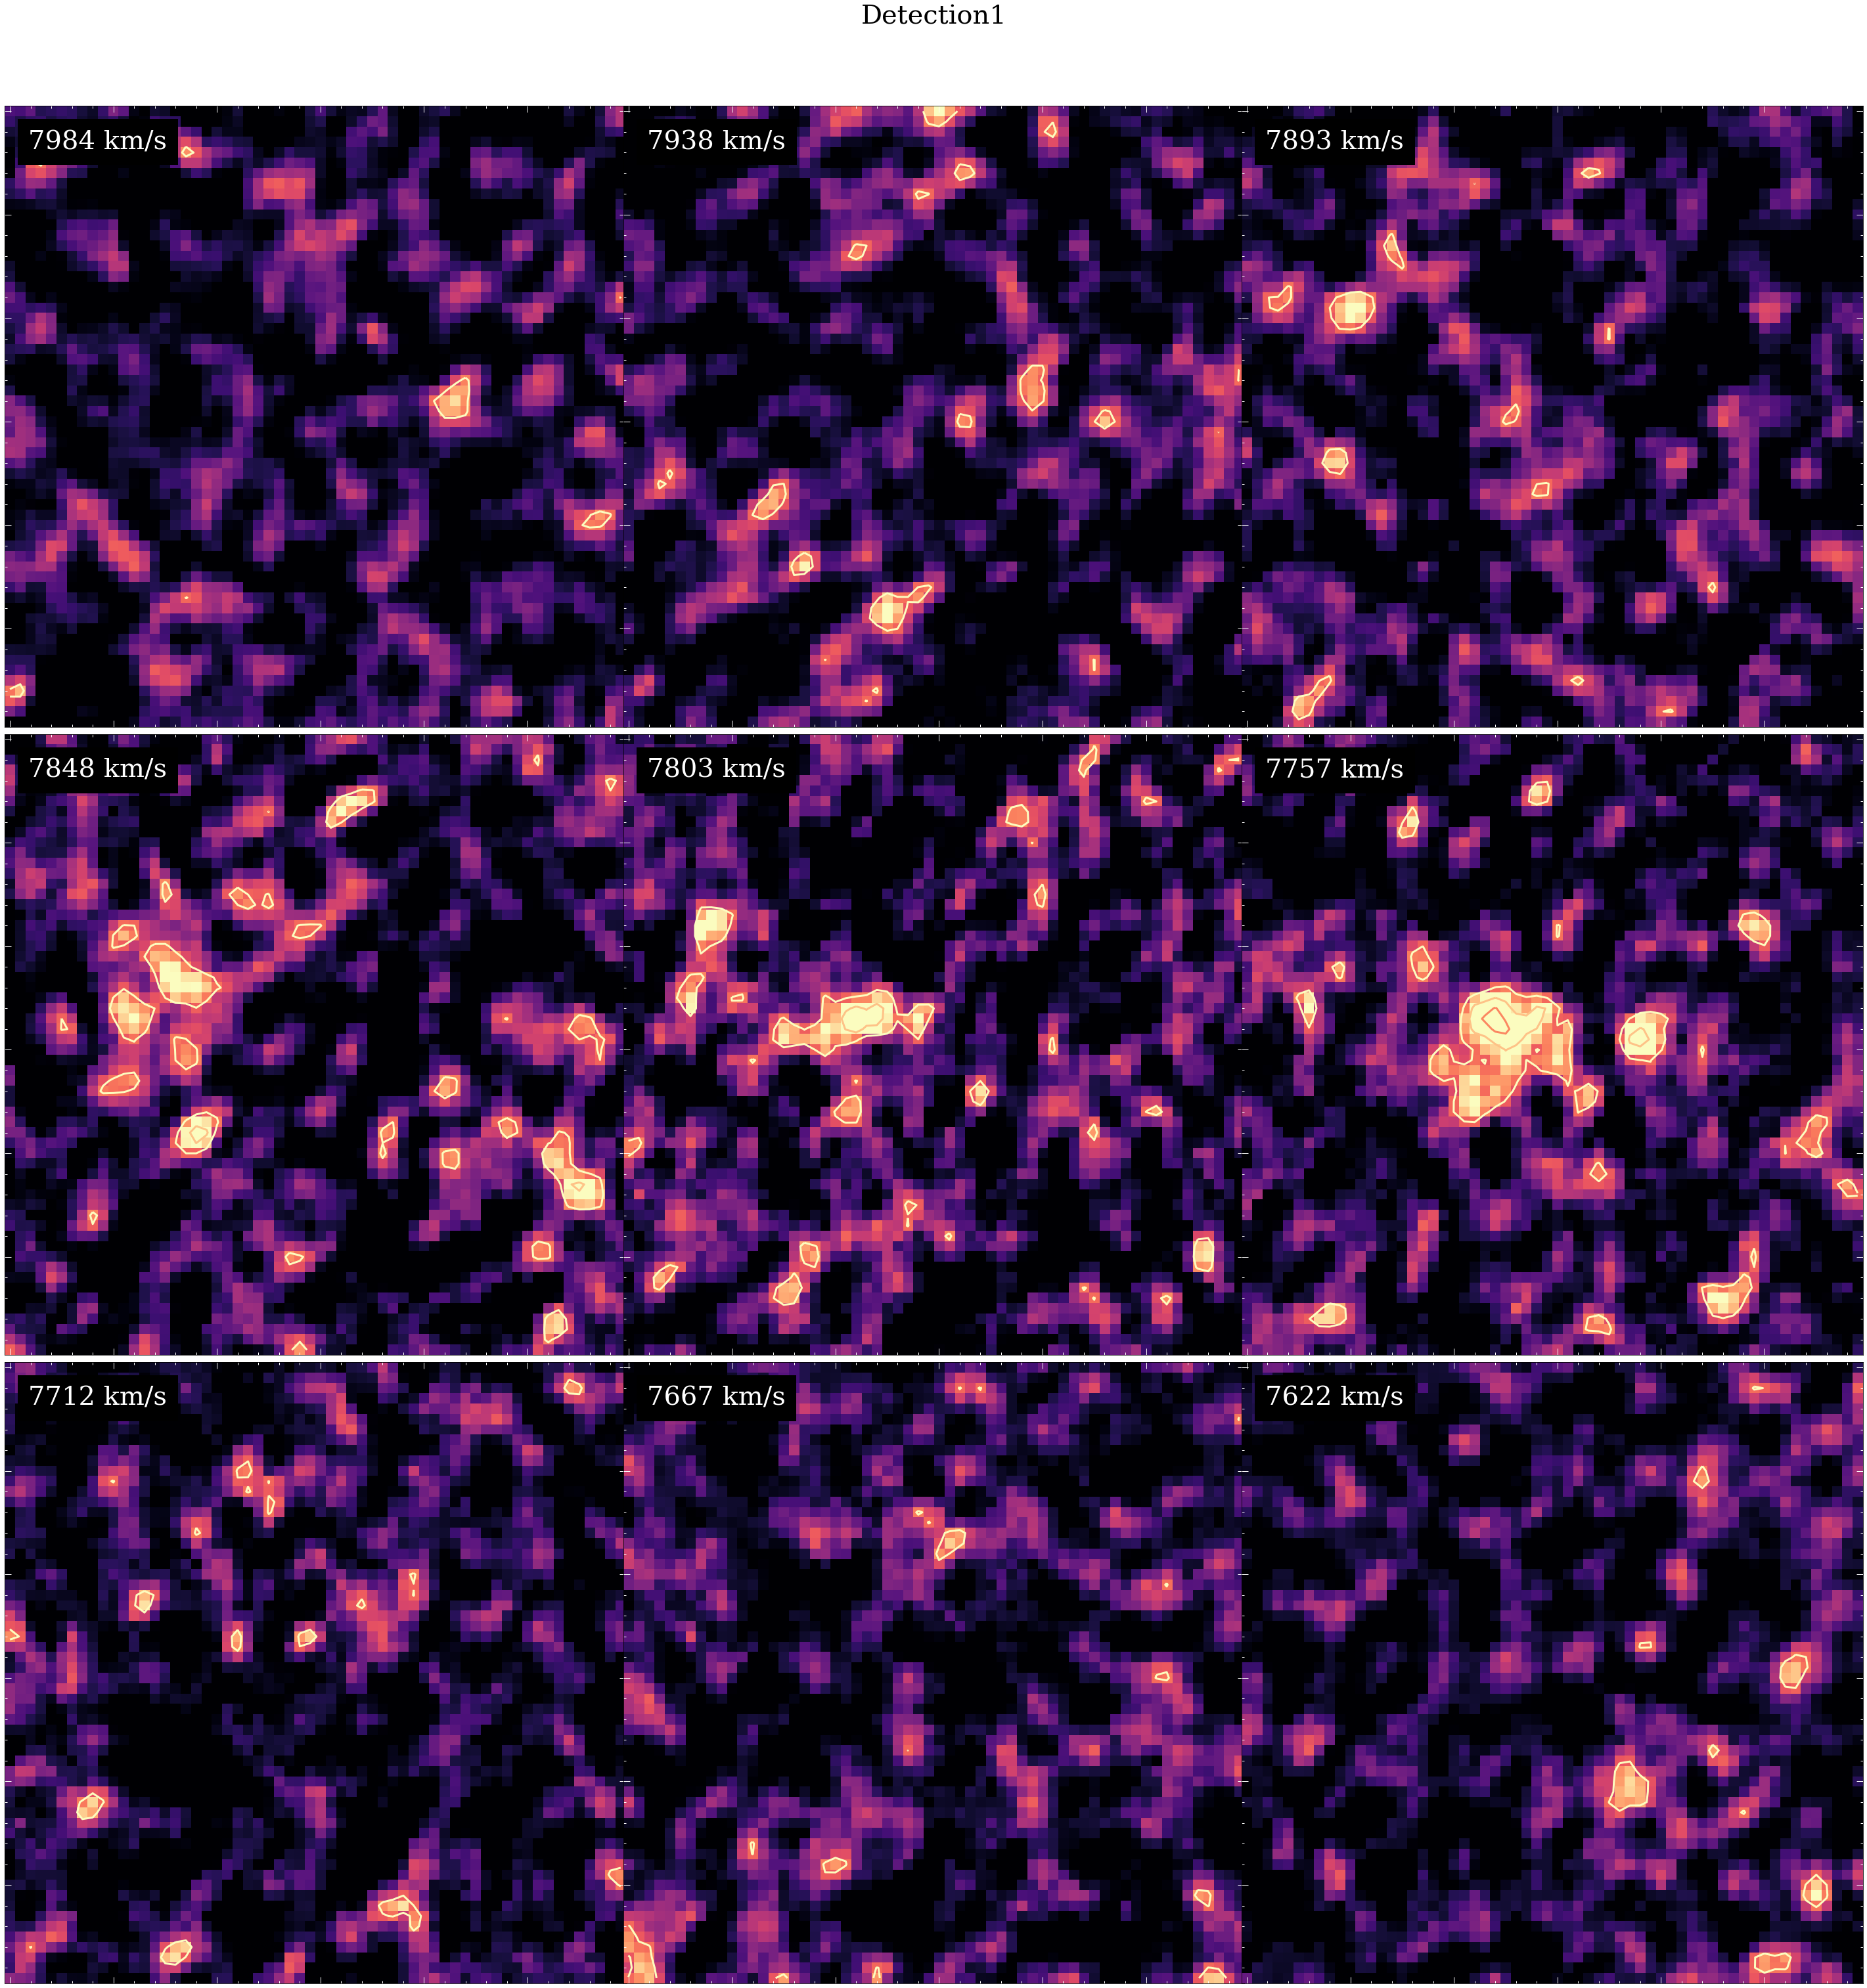

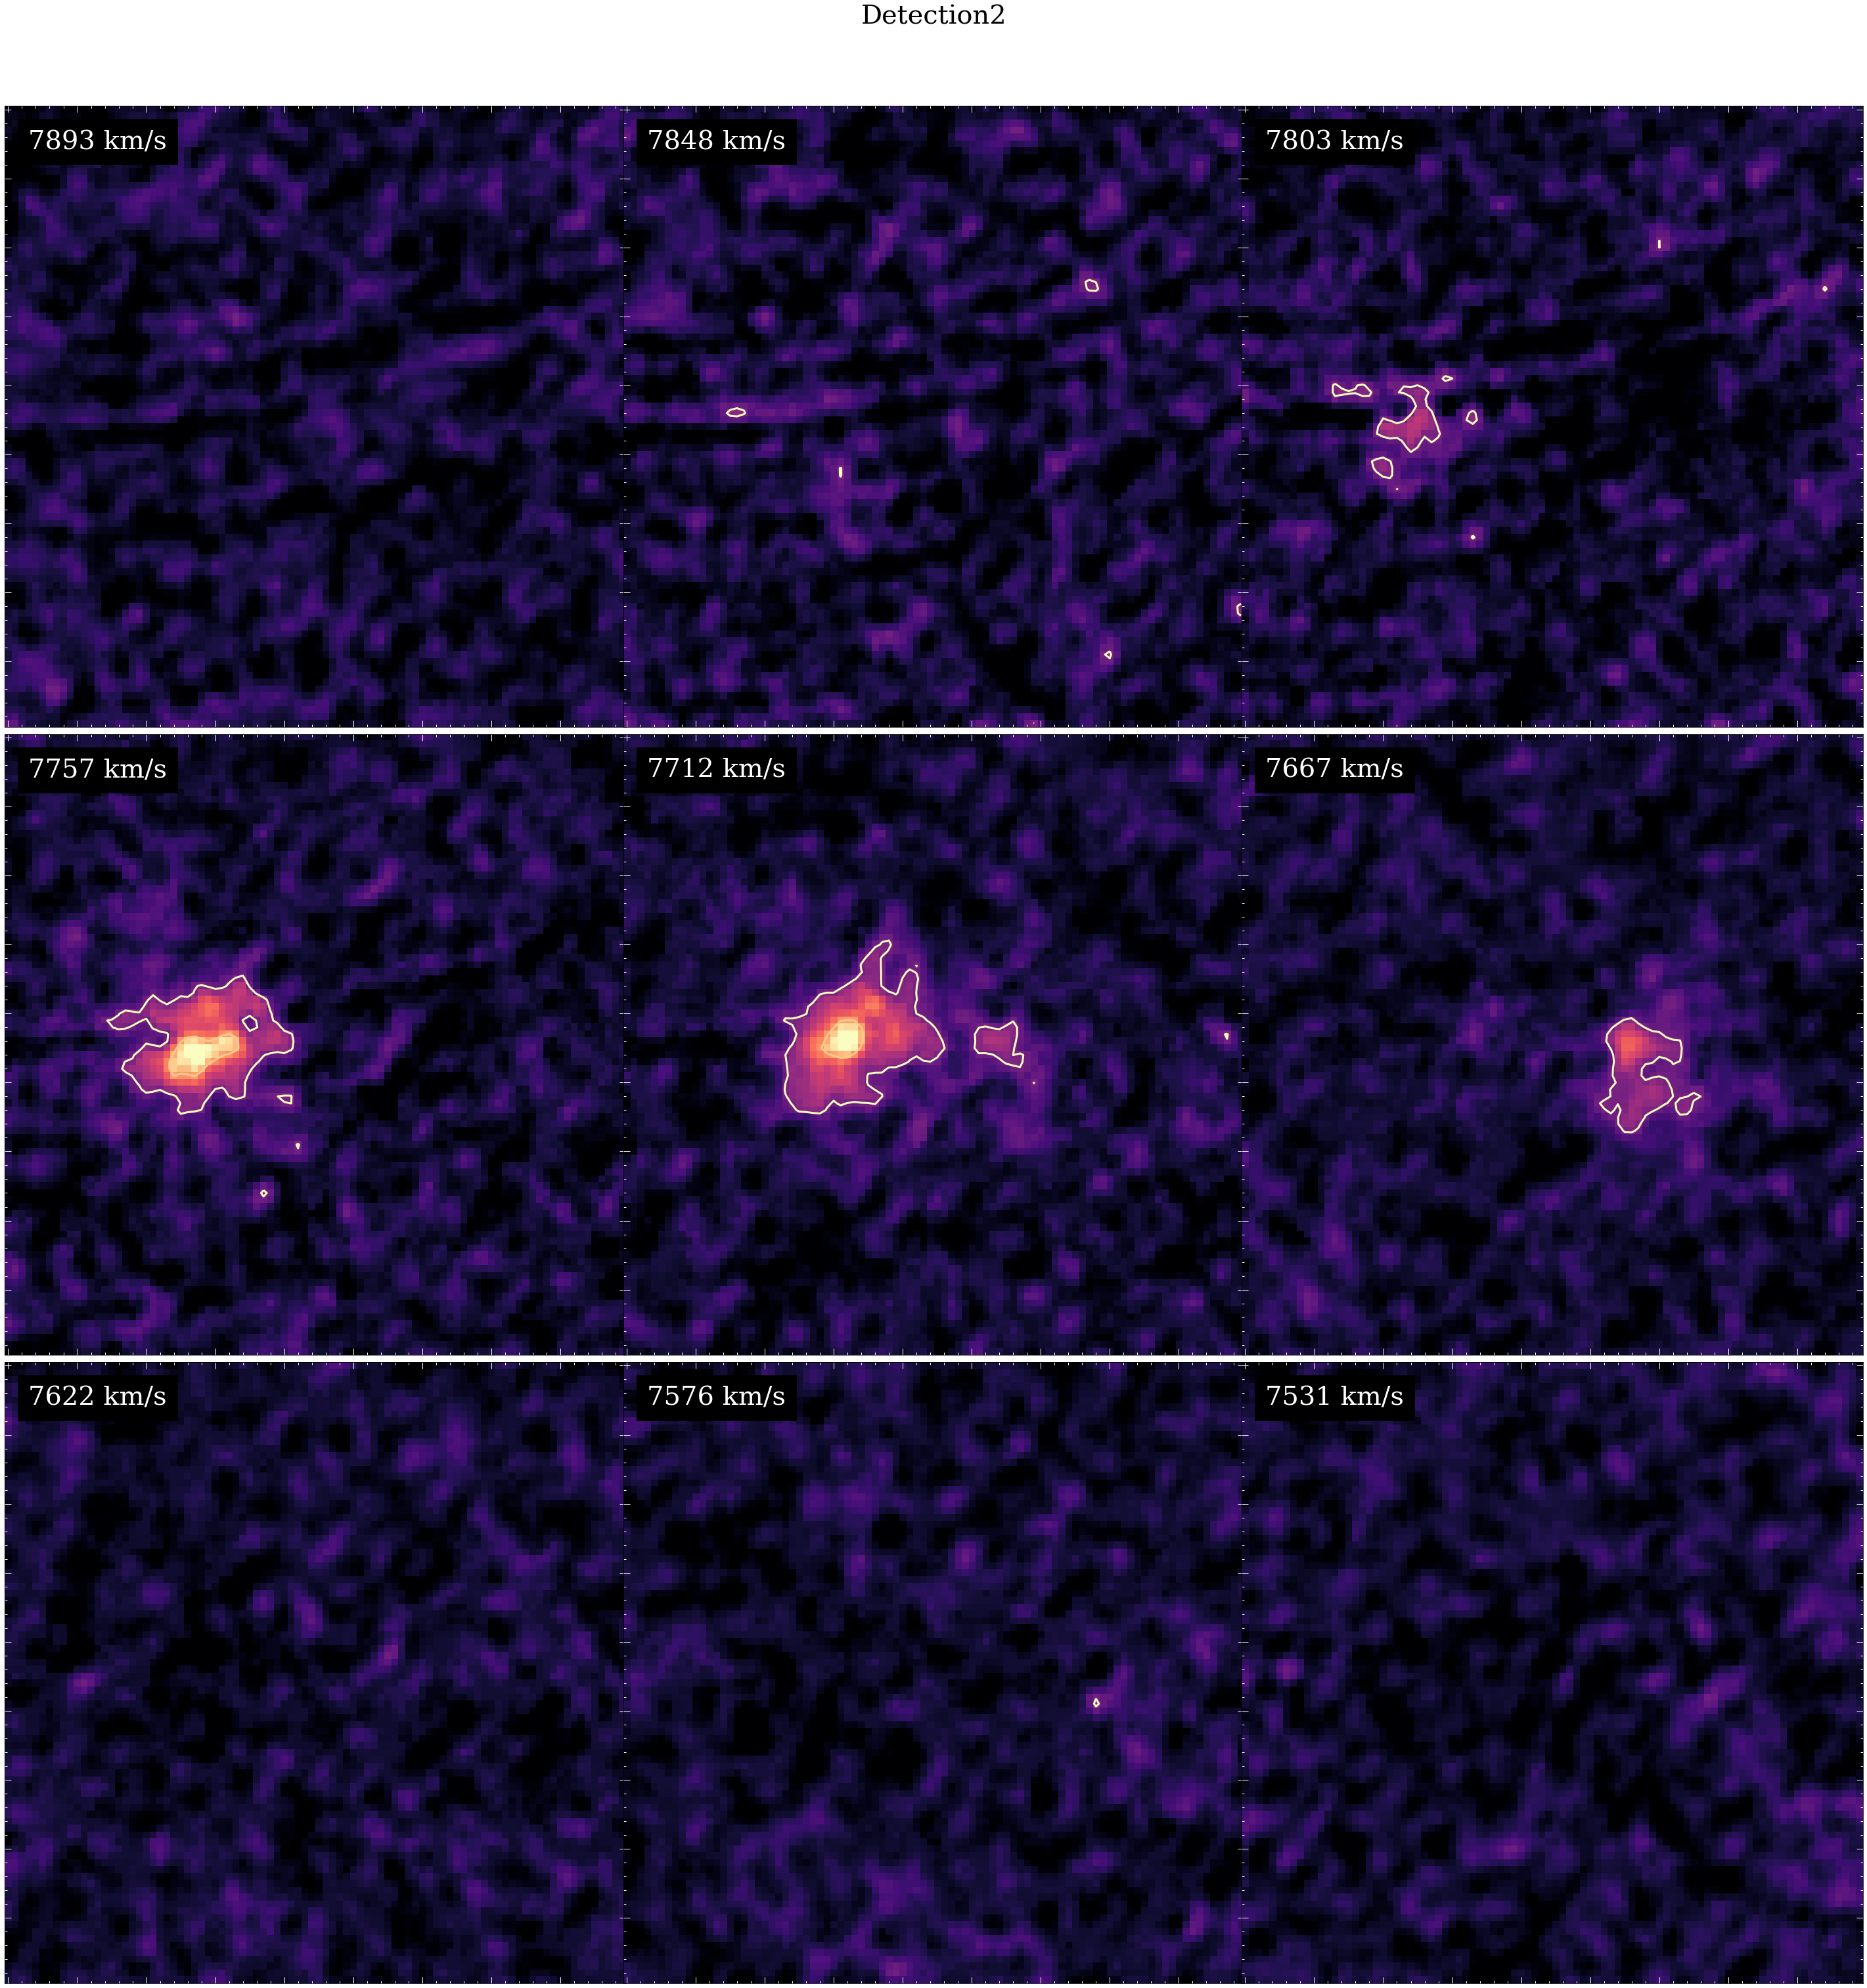

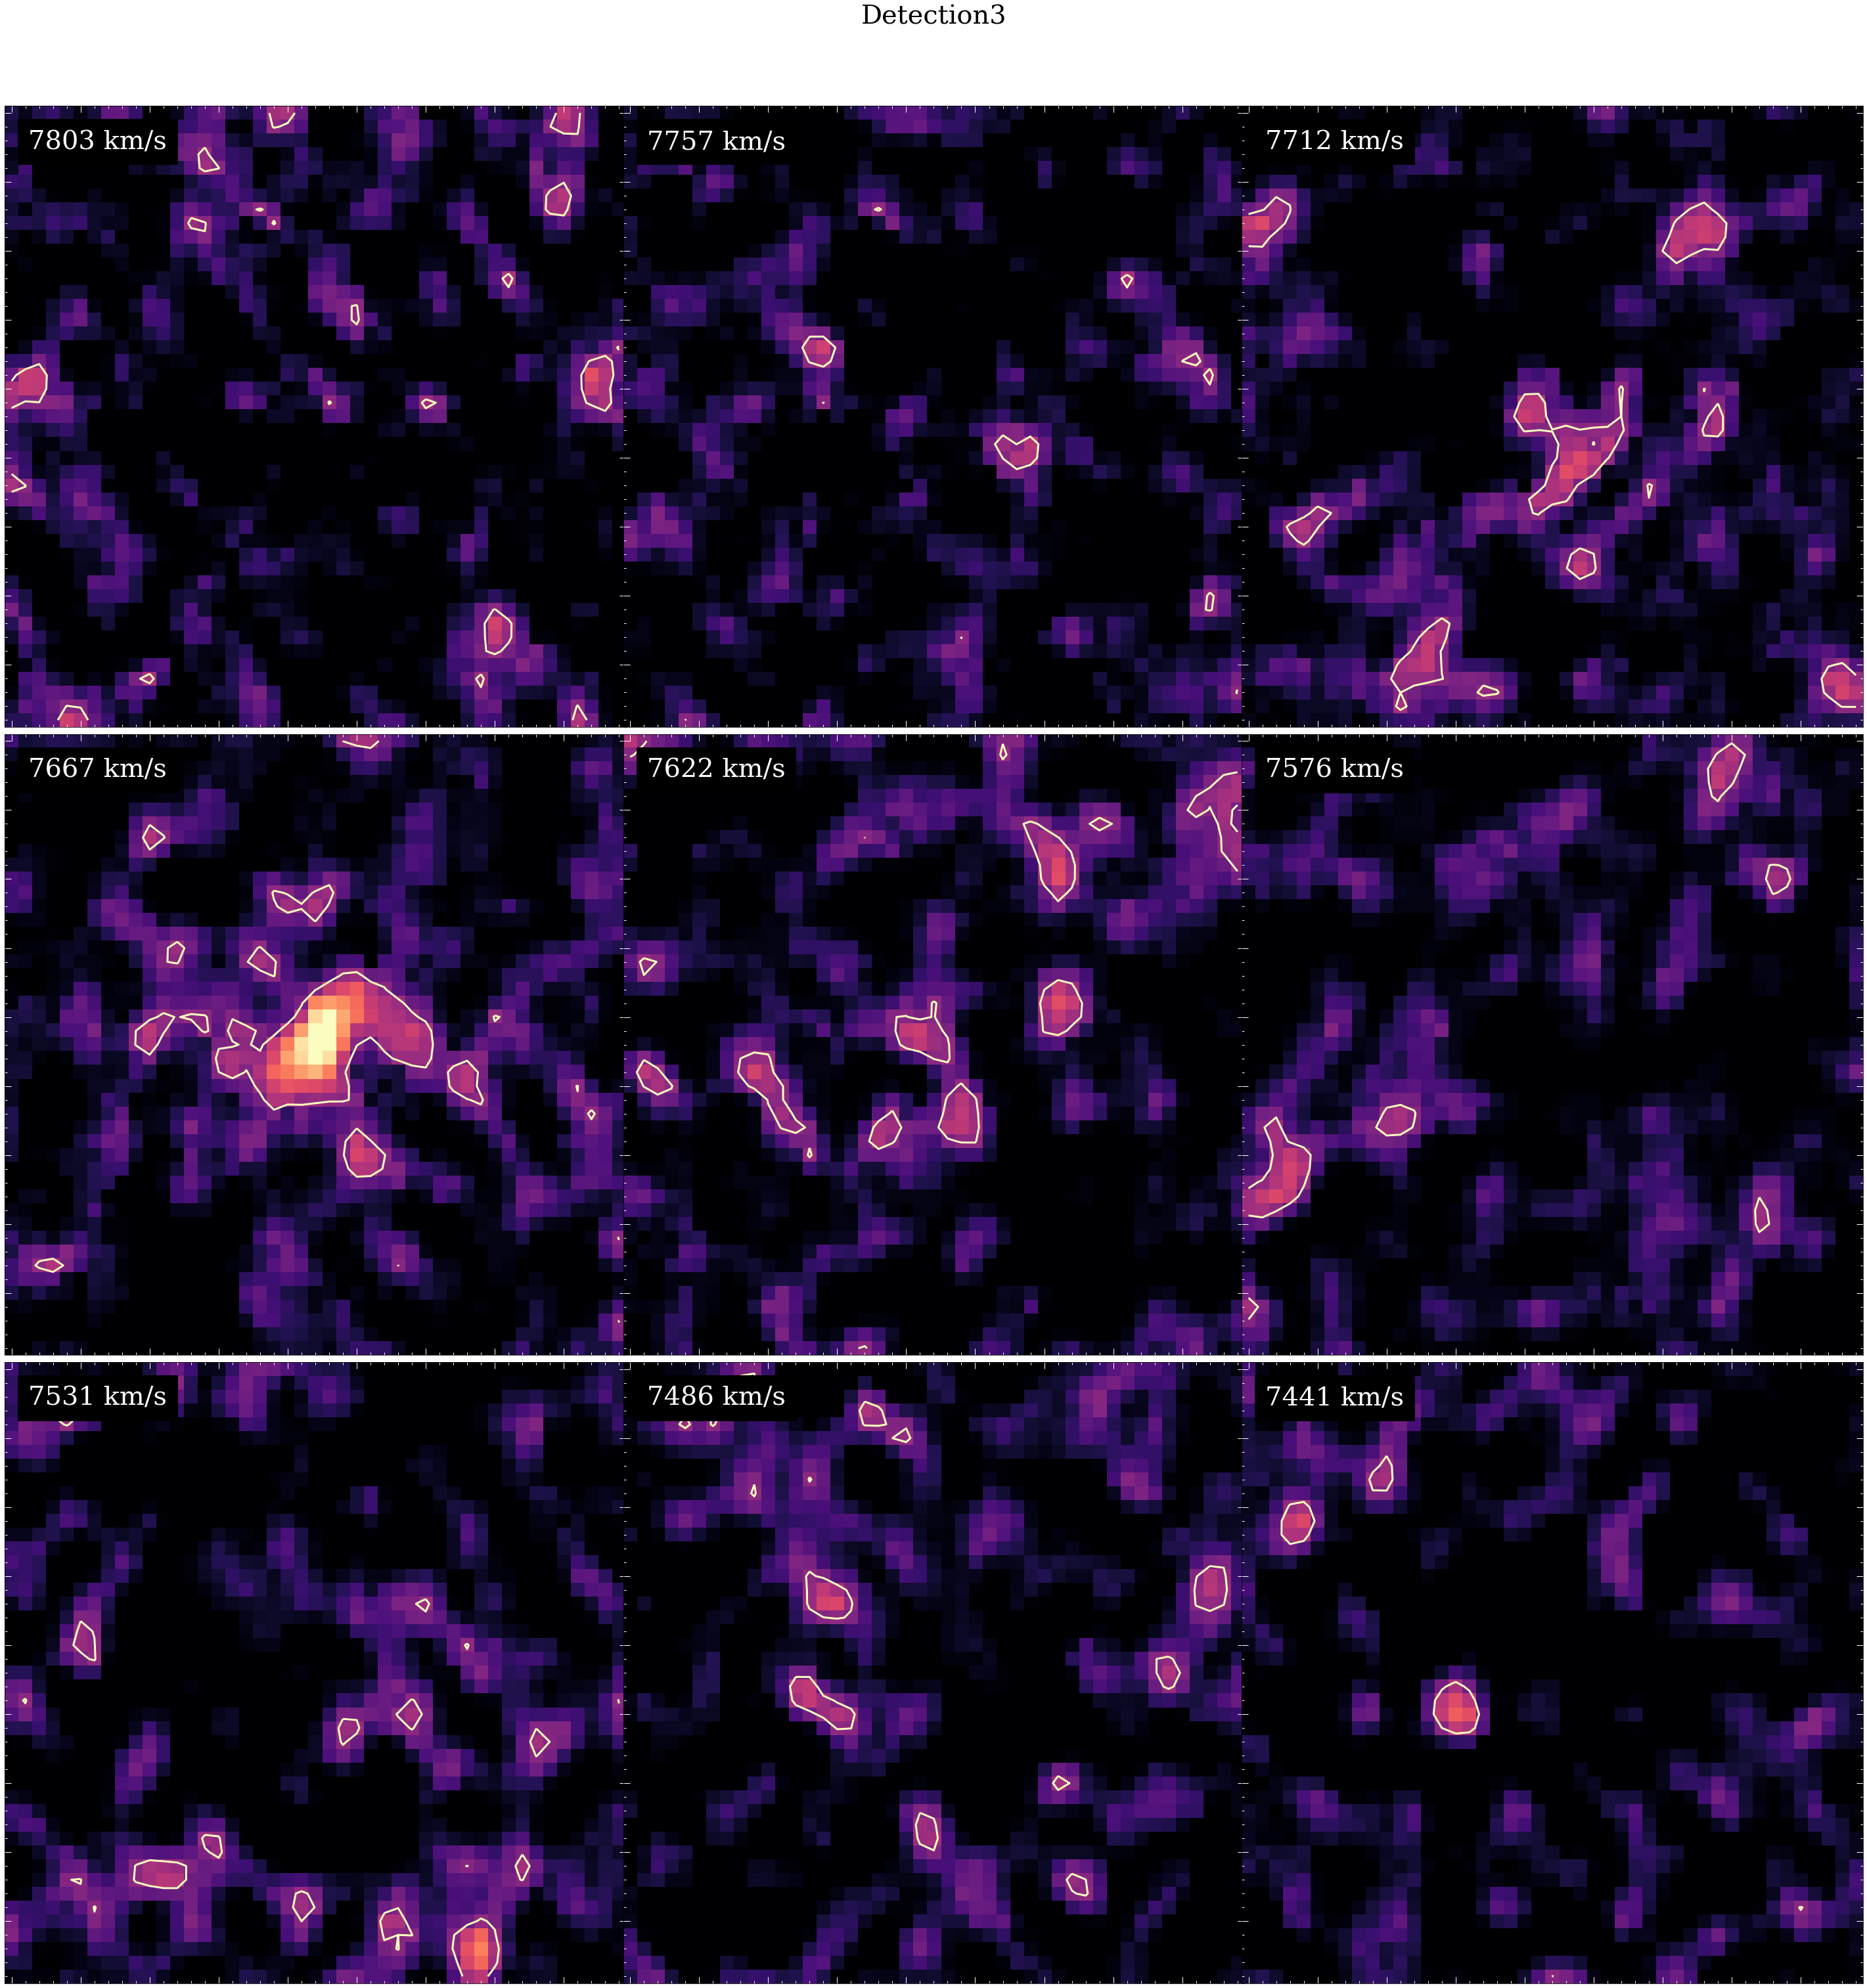

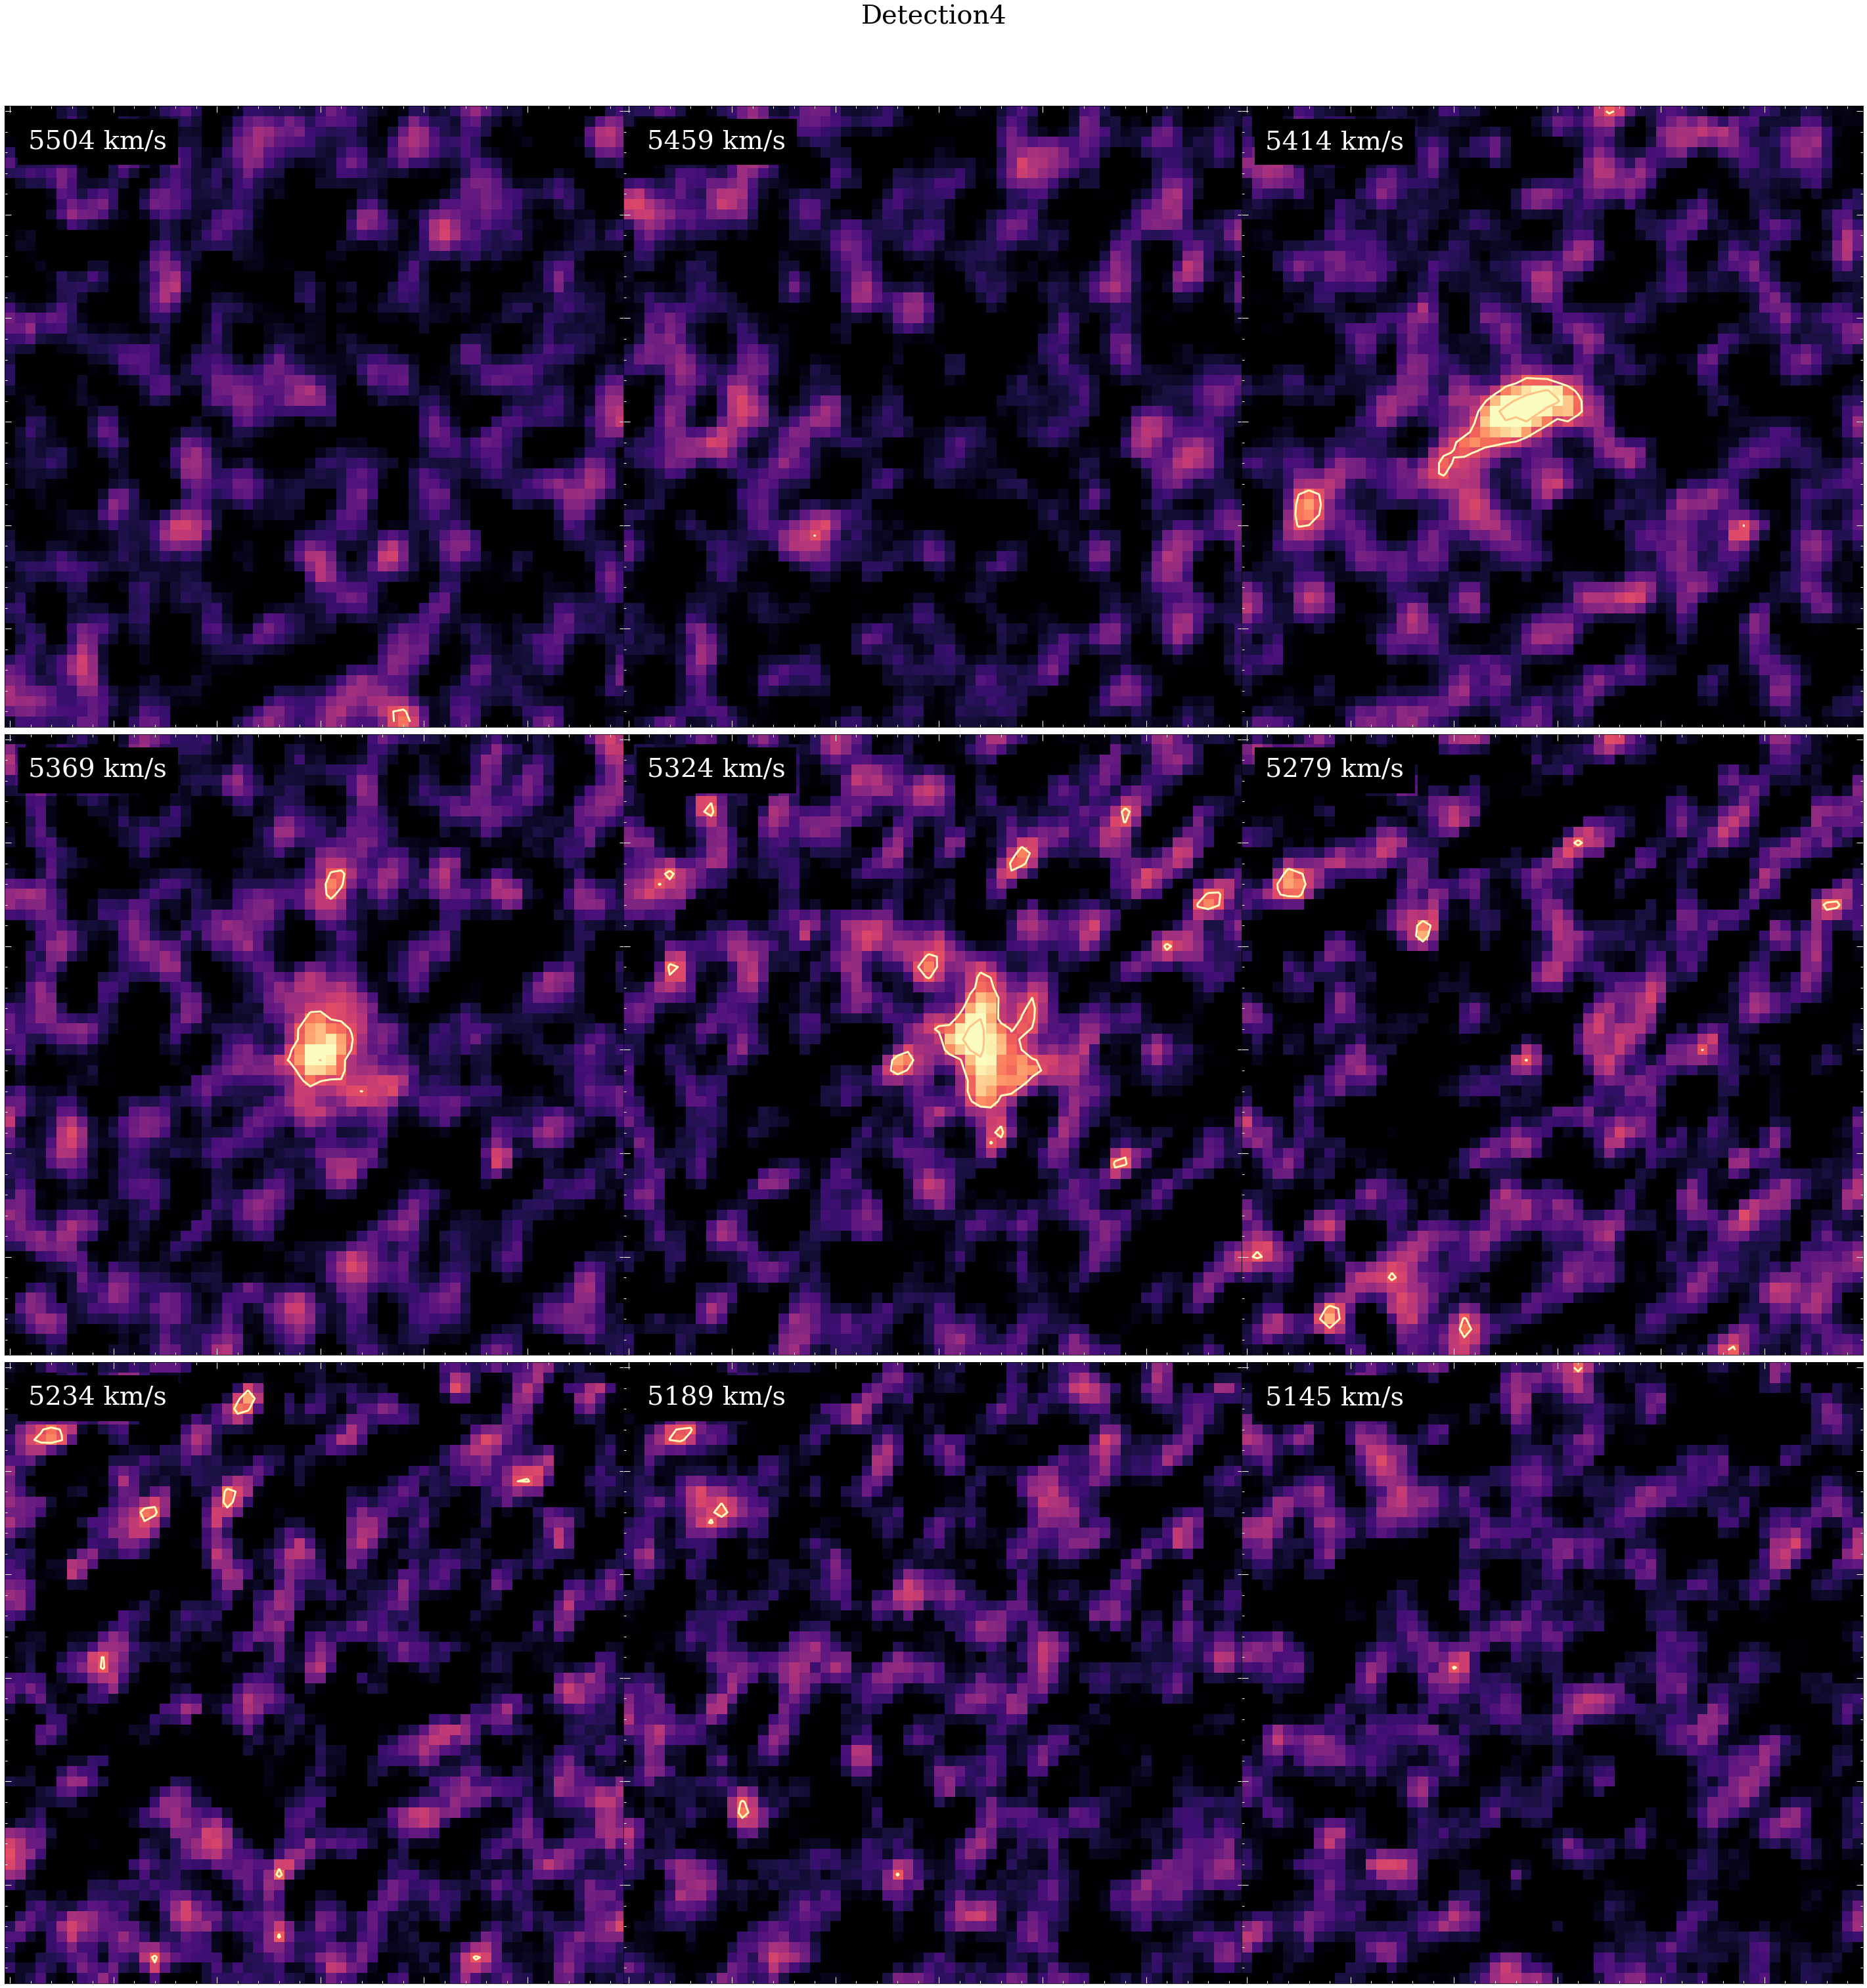

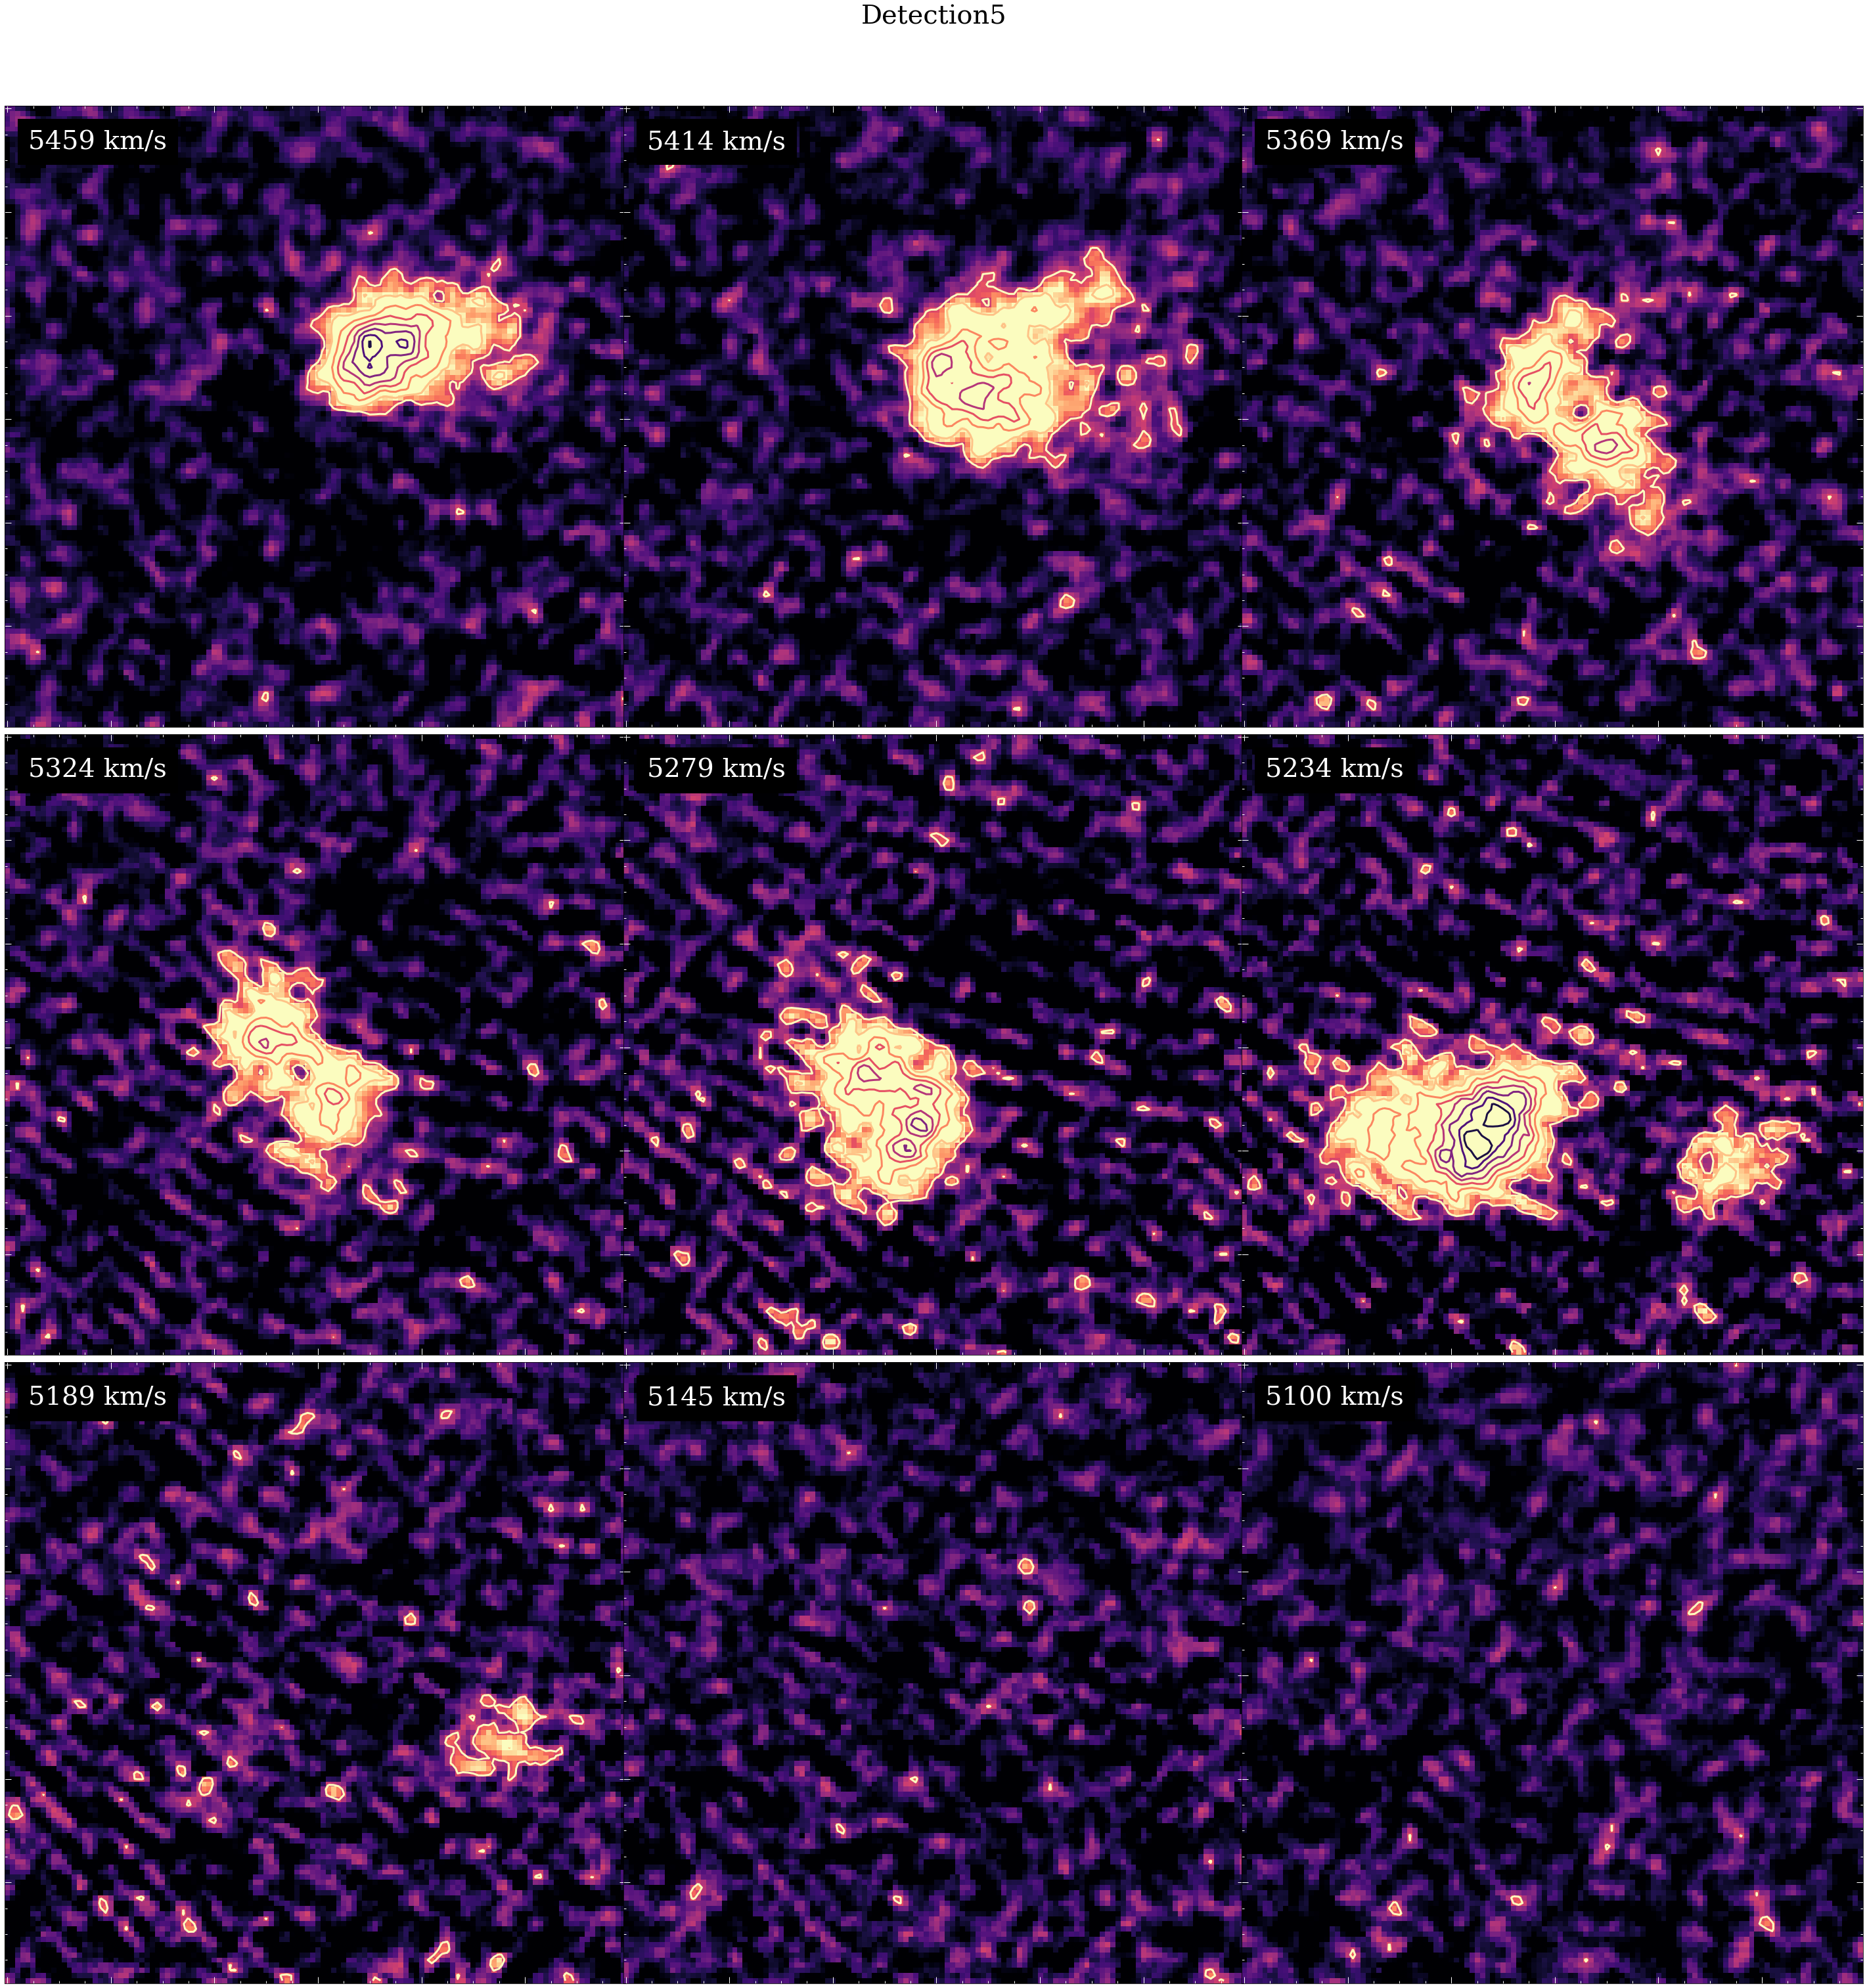

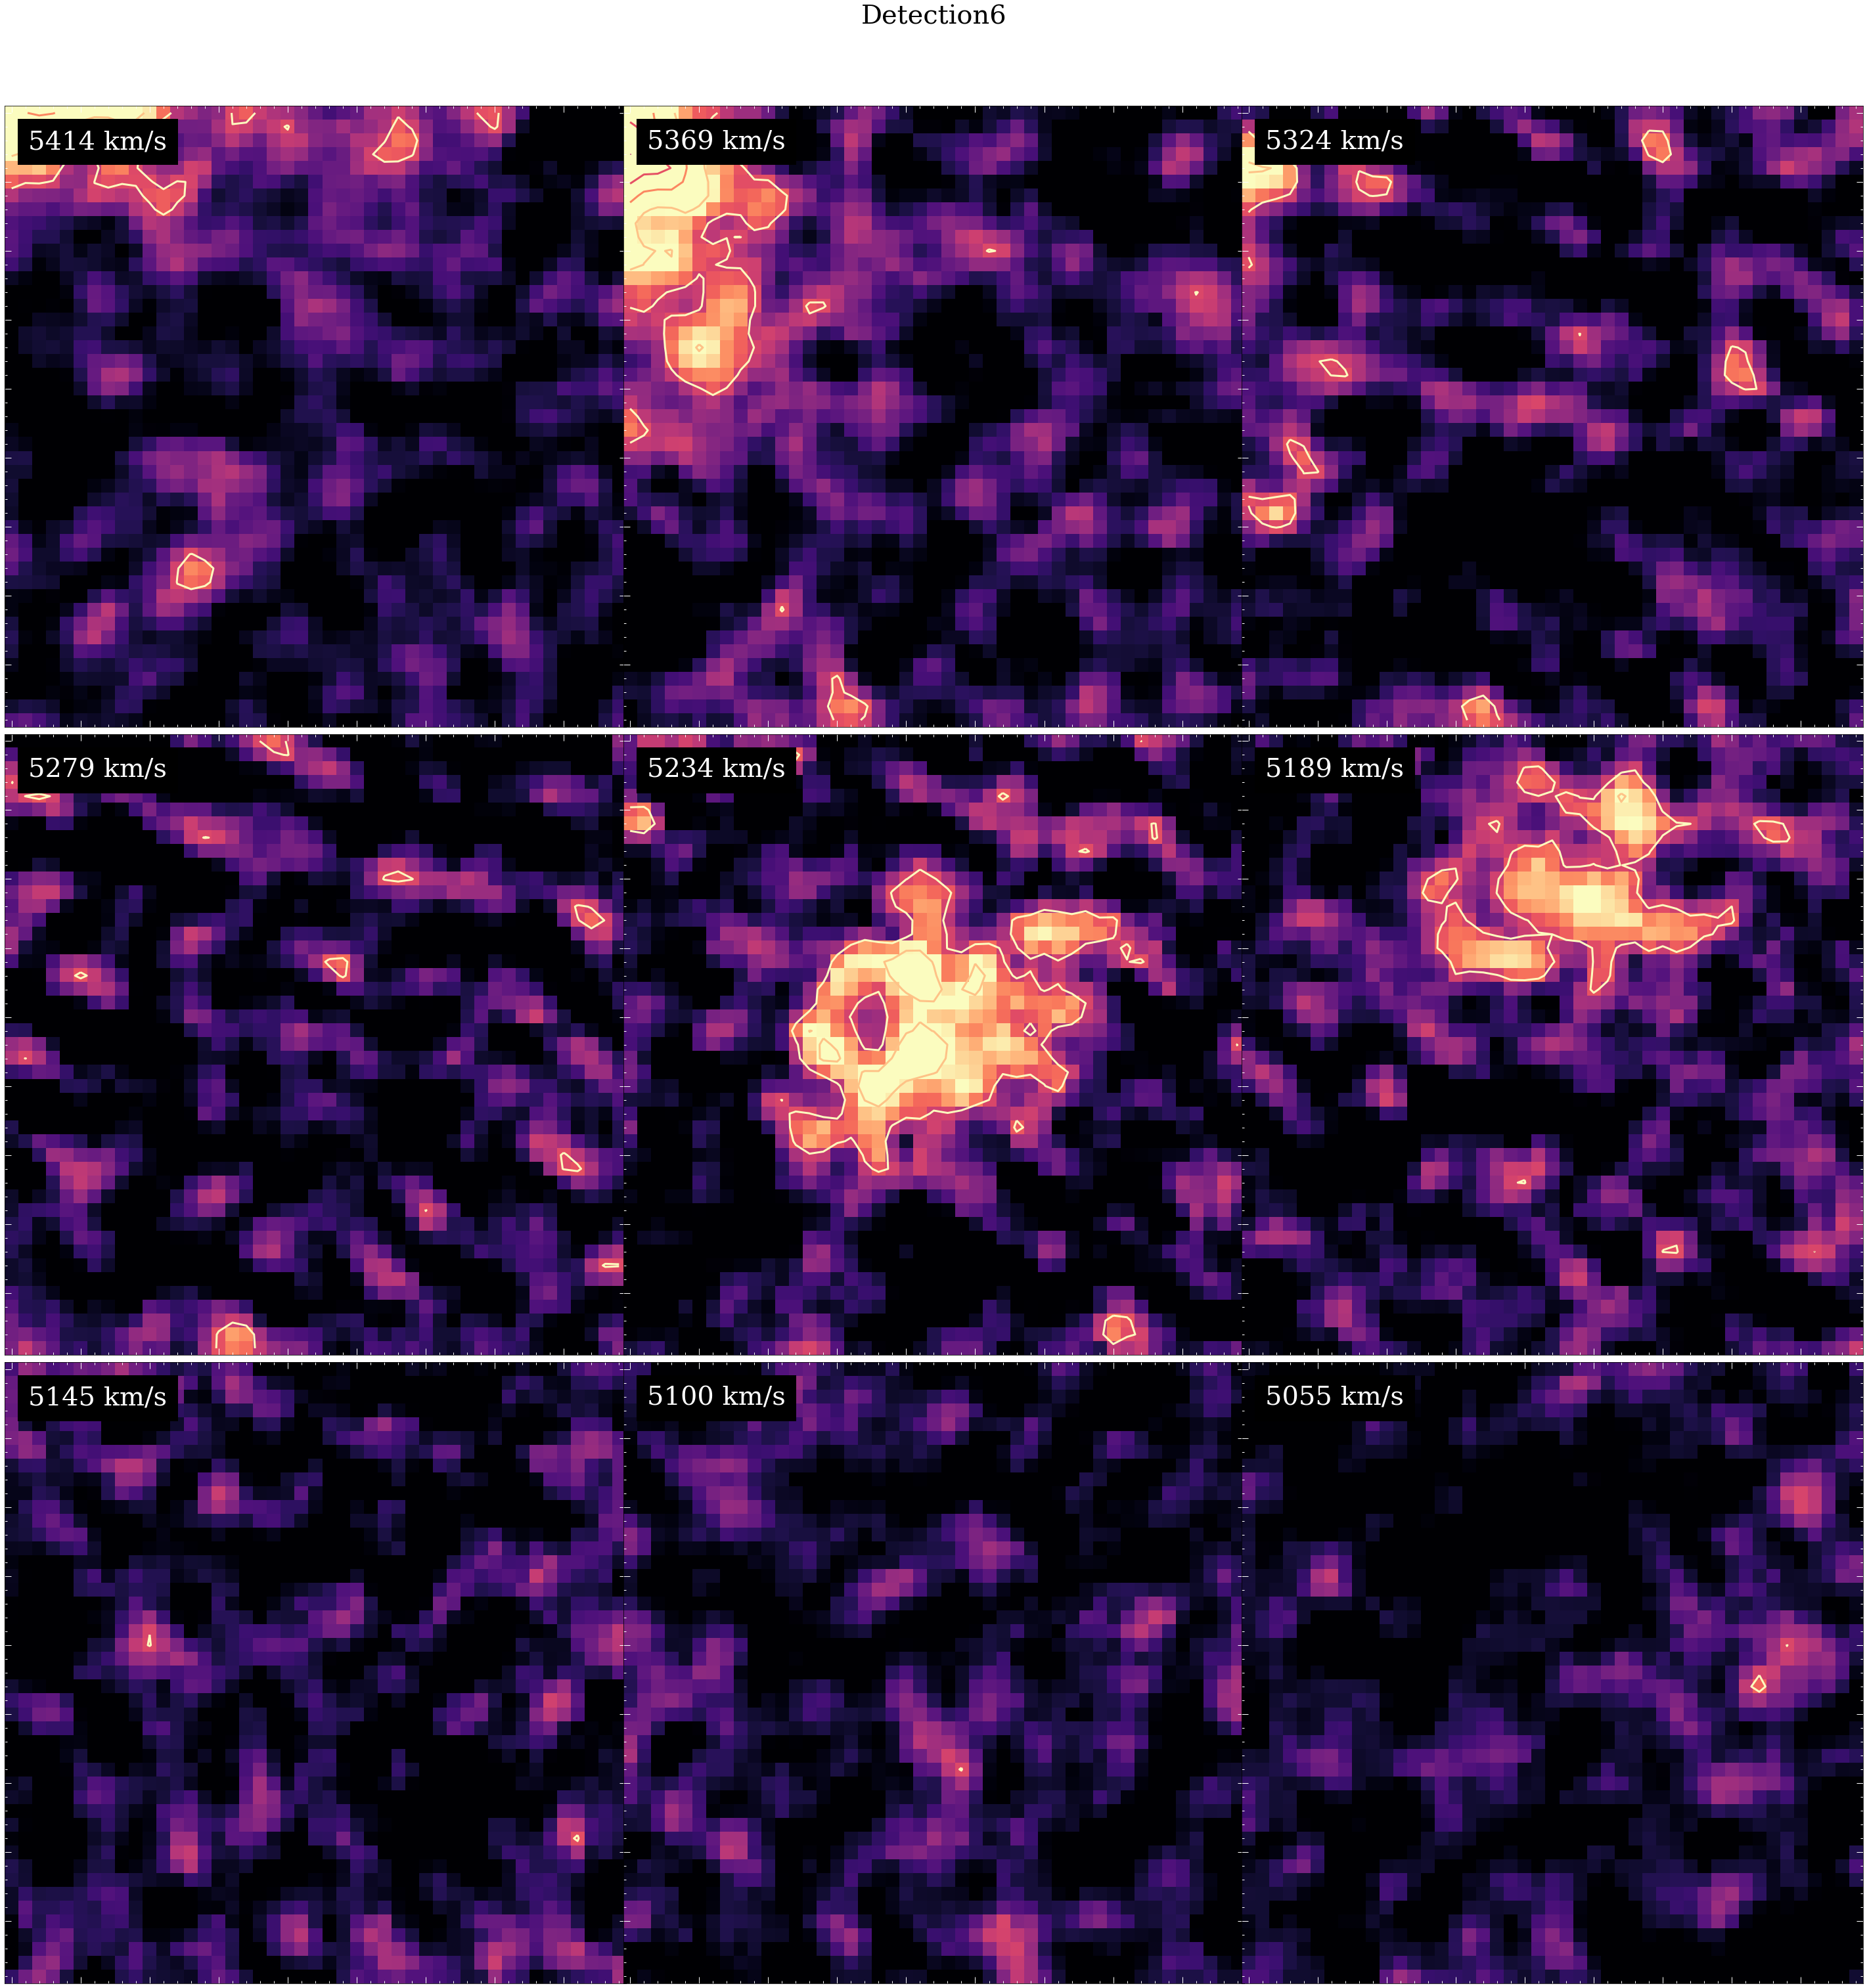

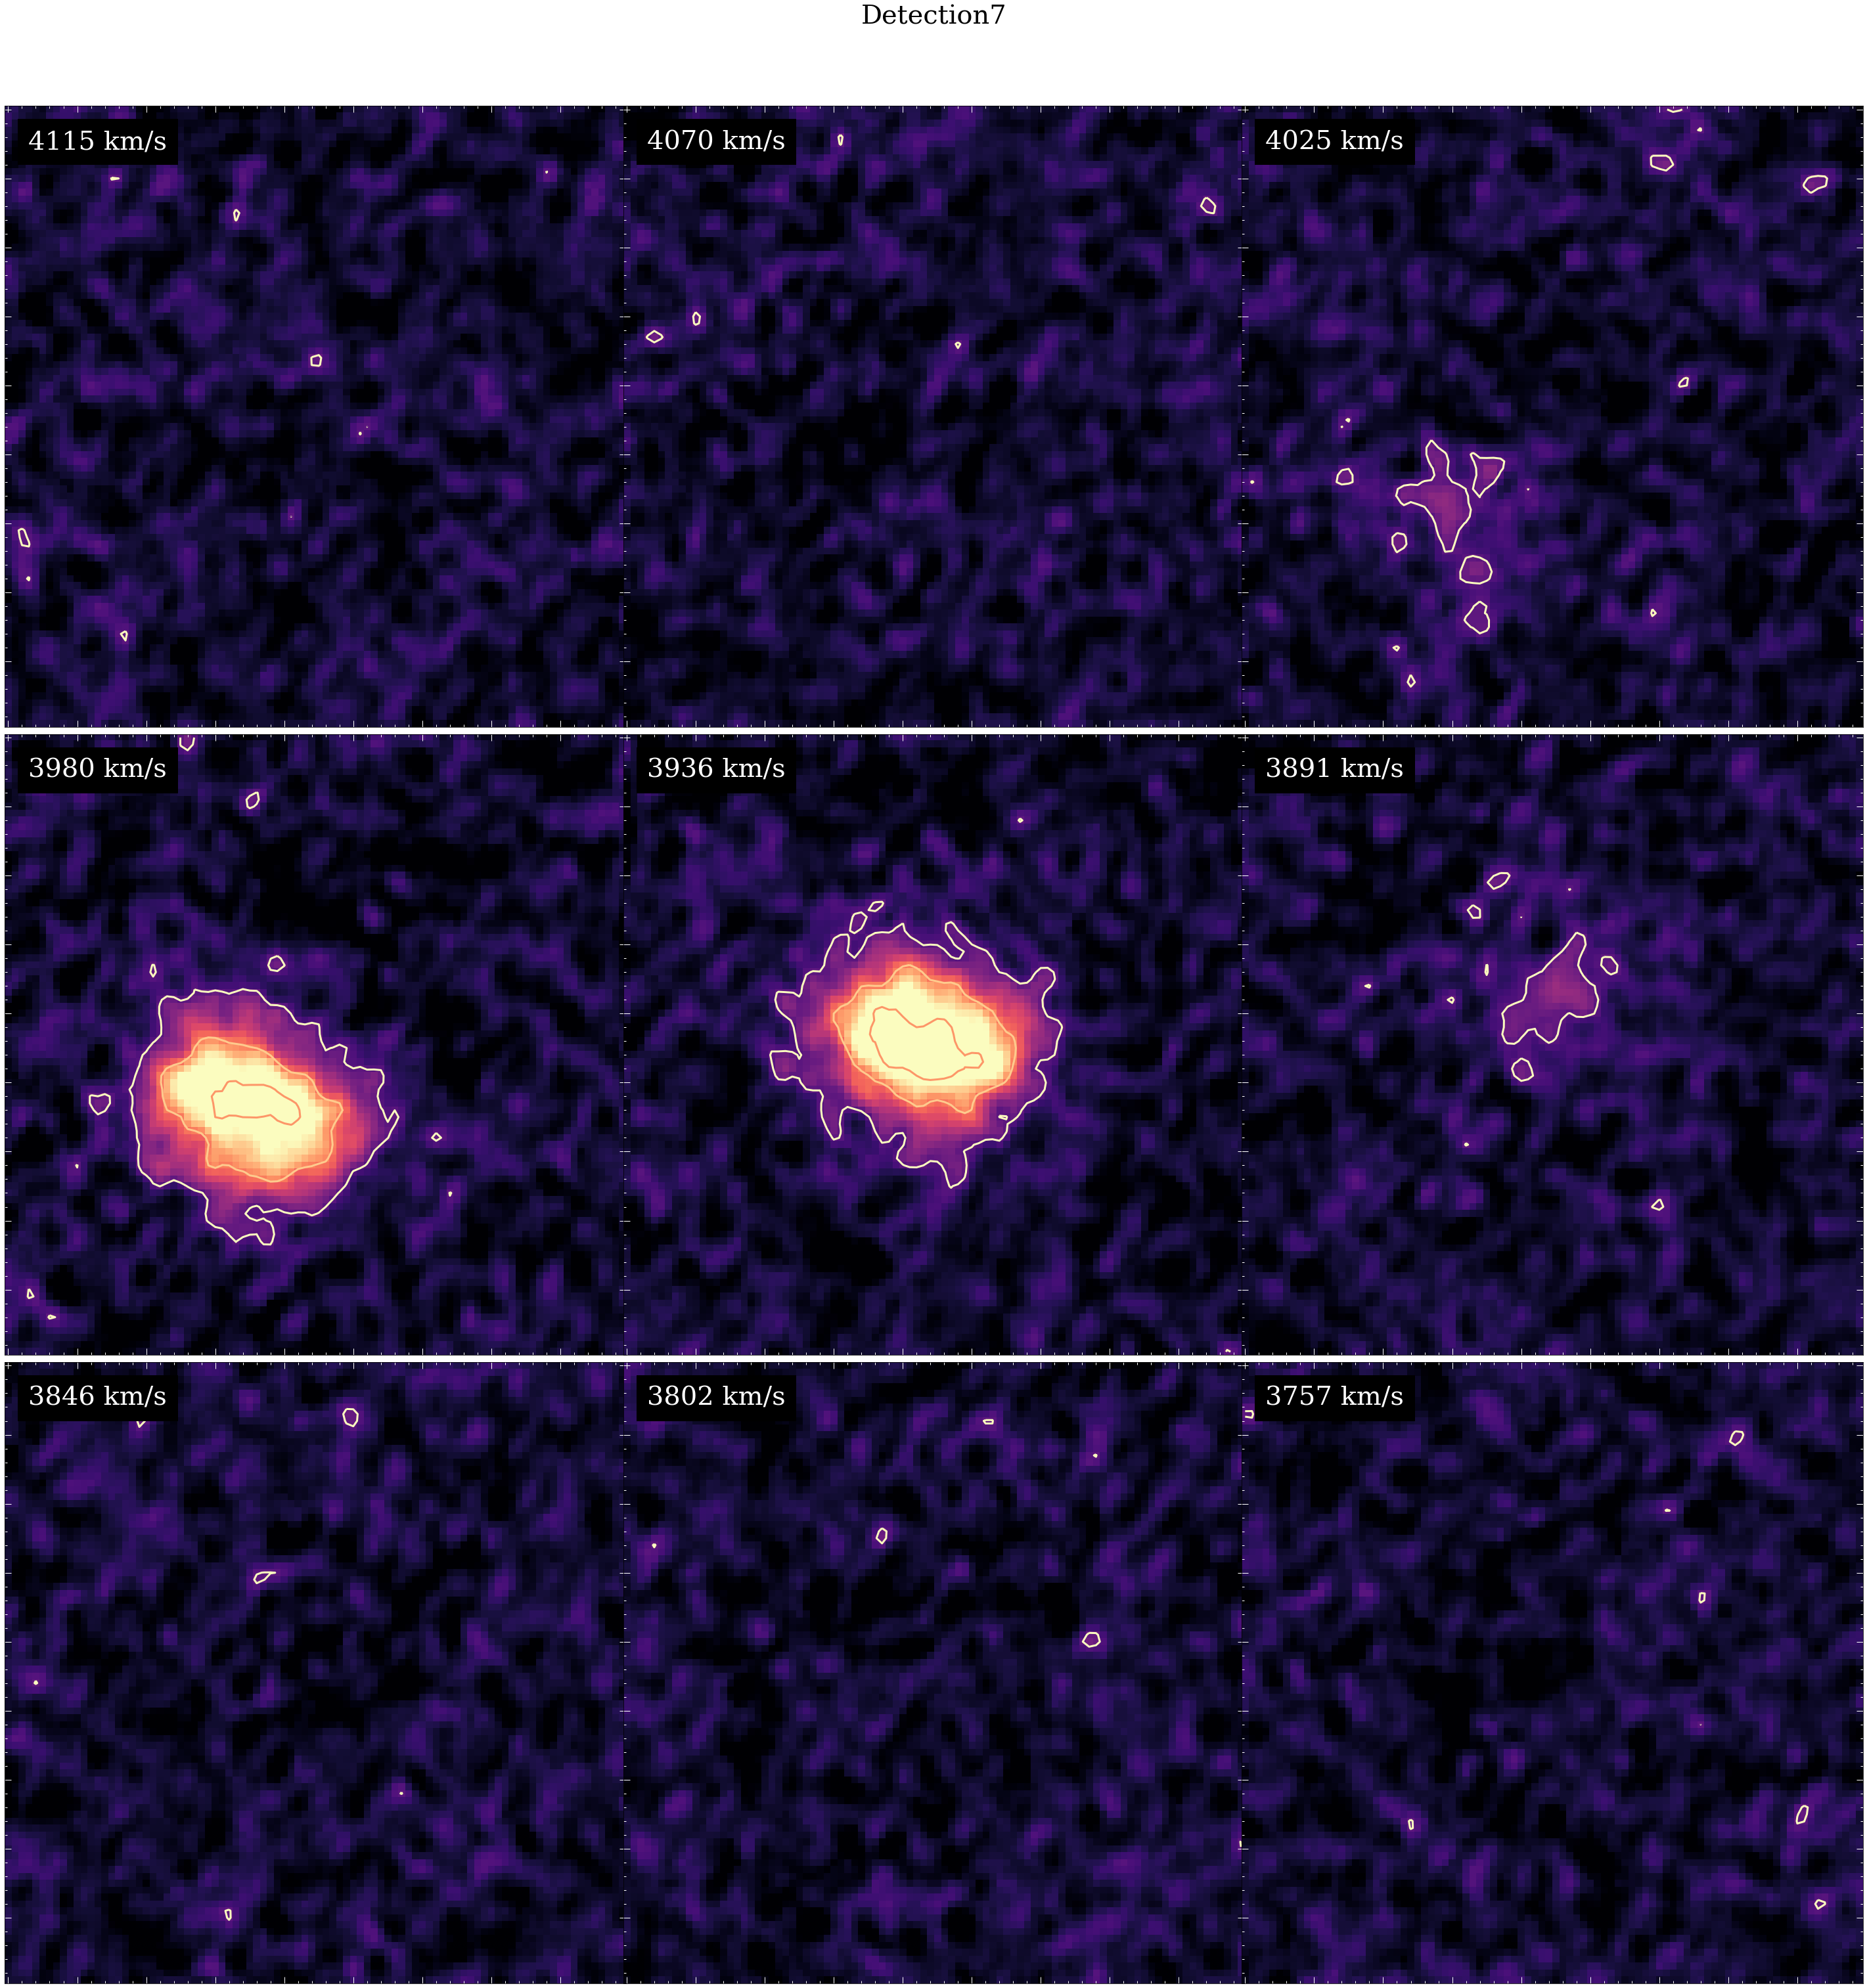

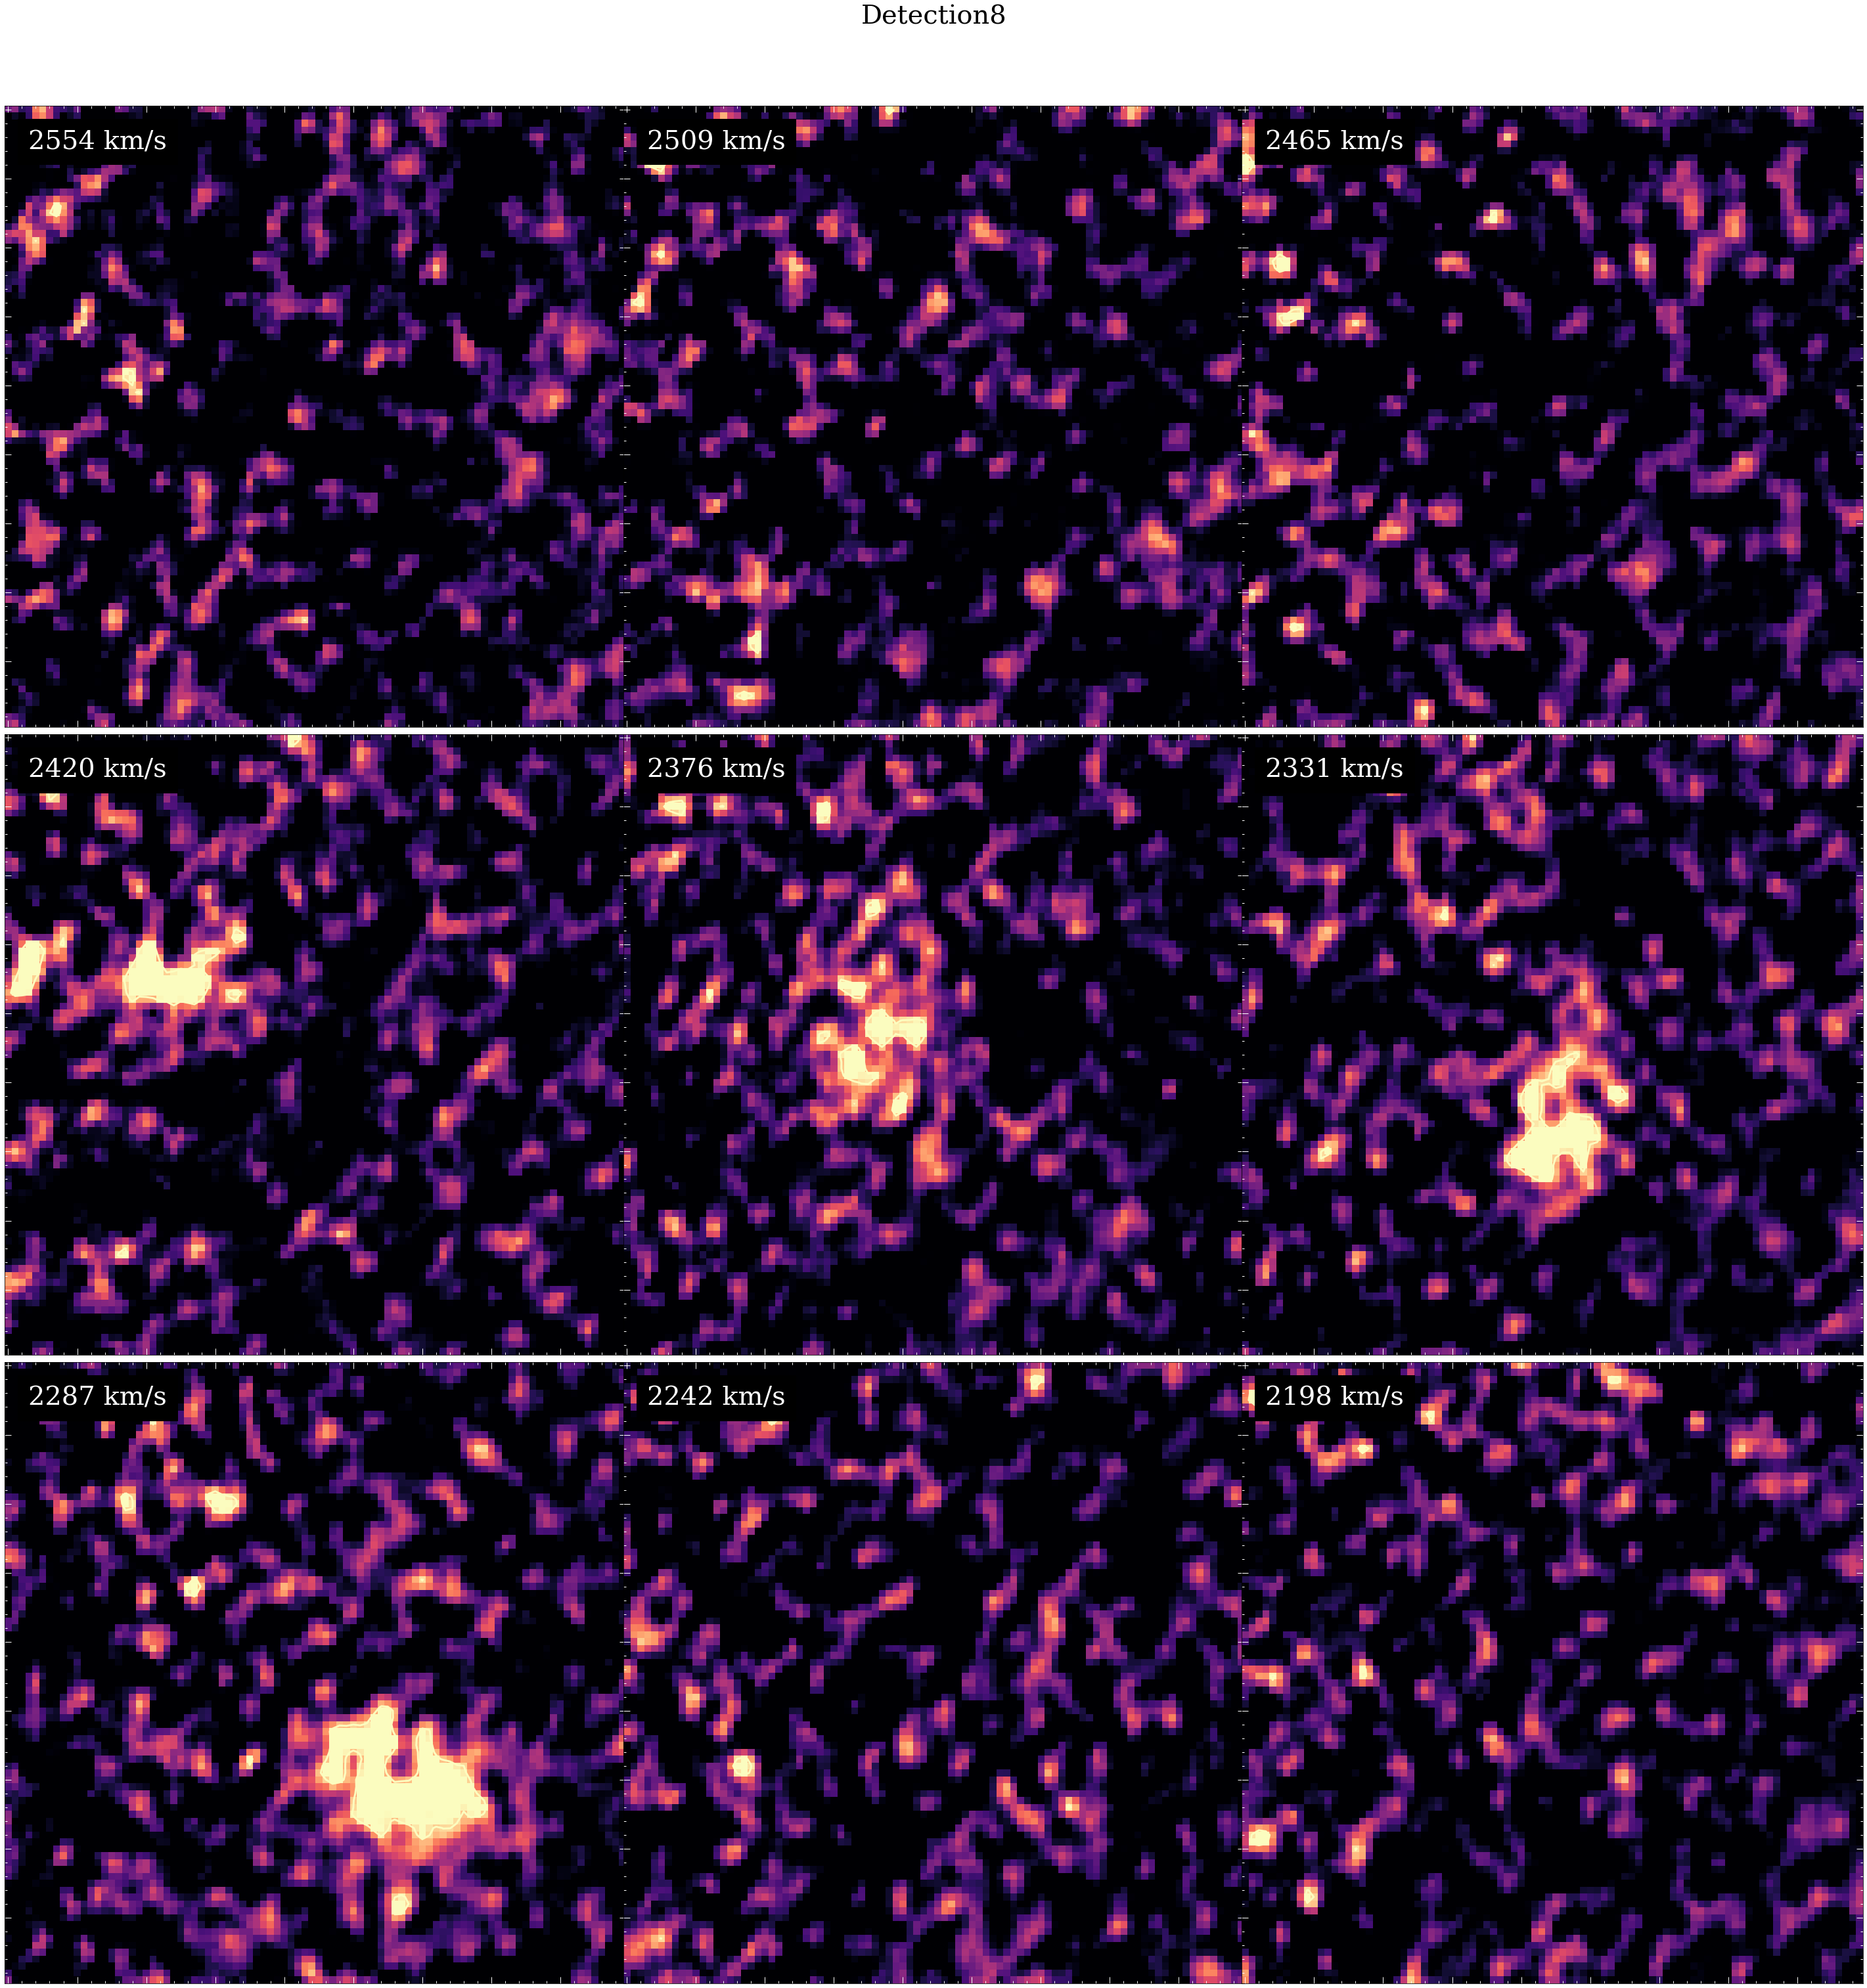

In [7]:
chan = [13, 15, 17, 30, 30, 29, 29, 29]#channels where the channel maps can start
sigma = [2,3,2,3,3,3,3,3]

for det in range(len(detections)):
    pl.figure(figsize=(40,40))
    #fig2, ax = pl.subplots()
    sli = vel_subcube[det][0,::1,:].array #for making contour levels
    # It is a 2D slice, so at least one axis should be fixed (and the two last one varies)
    noise = sigma[det]*np.std(sli[np.isfinite(sli)]) #3 sigma threshold, take the
    sub = 0
    for i in range(chan[det],chan[det]+9):
        pl.subplot(3,3,sub+1)
        #inversing the declination
        x = vel_subcube[det][i+1,::1,:].array
        pl.imshow(x[::-1,:], vmin=-0.1e-3, vmax=1e-3,cmap='magma') #I converted the declination axis because when I looked
        # into the detection with carta, the detections in python seems to be plotted with an inversed declination
        if det == 2:
            pl.imshow(x[::-1,:], vmin=-0.1e-4, vmax=3e-4,cmap='magma')
        if det == 7:
            pl.imshow(x[::-1,:], vmin=-0.1e-4, vmax=5e-3,cmap='magma')
            
        pl.contour(x[::-1,:], levels=np.arange(noise, 5e-3, 5e-4), 
                   colors=None,cmap='magma_r',linewidths=3) #changing the levels will change the contours
        ax = pl.gca()
        ax.minorticks_on()
        ax.tick_params(which='major', length=10, width=1, direction='in',color='white')
        ax.tick_params(which='minor', length=4, width=1, direction='in',color='white')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        int_vel = int(np.array(vel[det][i]))
        
        Afont = {'family': 'serif',
        'backgroundcolor': 'black',
        'alpha': 1,
        'color':  'white',
        'weight': 'normal',
        'size': 40,
        }
        anchored_text = AnchoredText(str(int_vel)+' km/s',loc=2, borderpad=0.5,frameon=True,prop=Afont)
        
             #bbox={'boxstyle': 'square','facecolor': 'black', 'alpha': 0.8}
             #)
        
        ax.add_artist(anchored_text)
        sub += 1
    pl.suptitle('Detection'+str(det+1),fontsize=40,y=1.05)
    pl.subplots_adjust(wspace=-0.05, hspace=0.0)
    pl.tight_layout()
    #pl.savefig('/users/aycha/MIGHTEE/Analysis/1380/plots/multi-channels_det'+str(det+1)+'.png', overwrite=True)

# Export subcubes and noisecubes into FITS files

This can also be used as a check, so that we can see if the noisecubes only contain noises, and if the detection is within the subcube.

In [ ]:
[vel_subcube[i].write('/users/aycha/MIGHTEE/Analysis/1380/Subcube'+str(i+1)+'.fits') for i in range(len(detections))]
[noisecube[i].write('/users/aycha/MIGHTEE/Analysis/1380/Noisecube'+str(i+1)+'.fits') for i in range(len(detections))]

# 7. Analysis 3: HI Global Profile

## 7.1 Conversion from frequency to velocity and vice versa
Instead of a frequency axis, we will need a velocity axis for the spectrum. This is already sorted out by the array `vel`.

However, the observed frequency of the detection is still in unit of Ghz, so we need to convert it into a central velocity in km/s in the next cell. Vice versa, we can also convert the relativistic velocity into 

\begin{equation}
\bbox[#F0F0F0, 10px, border:1px solid black]{V = \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c} \tag{1}
\end{equation}

\begin{equation}
\bbox[#F0F0F0, 10px, border:1px solid black]{\nu = \nu_0 \sqrt{\frac{c-V}{c+V}}} \tag{2}
\end{equation}

In [8]:
def freq_to_vel(obs_freq,nu_o=1.42040575, c=299792.458):
    '''
    This function is used for converting an observed frequency (GHz) into velocity (km/s)
    for a 21 cm emission using relativstic formula
    '''
    #v_r2 = c*((nu_o-obs_freq)/nu_o) #v_rad
    v_r = c*(nu_o**2-obs_freq**2)/(nu_o**2+obs_freq**2) #v_relativstic
    return v_r

def vel_to_freq(v_r,nu_o=1.42040575, c=299792.458):
    '''
    This function is used for converting a relativistic velocity (km/s) into a frequency in GHz.
    for a 21 cm emission using relativstic formula
    '''
    nu = nu_o*np.sqrt((c-v_r)/(c+v_r))
    return nu
    
#Converting the central frequency into velocity
central_vel = []
for i in range(len(detections)):
    cfreq = detections[i]['freq']
    central_vel.append(freq_to_vel(cfreq))

## 7.2 Raw spectrum

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


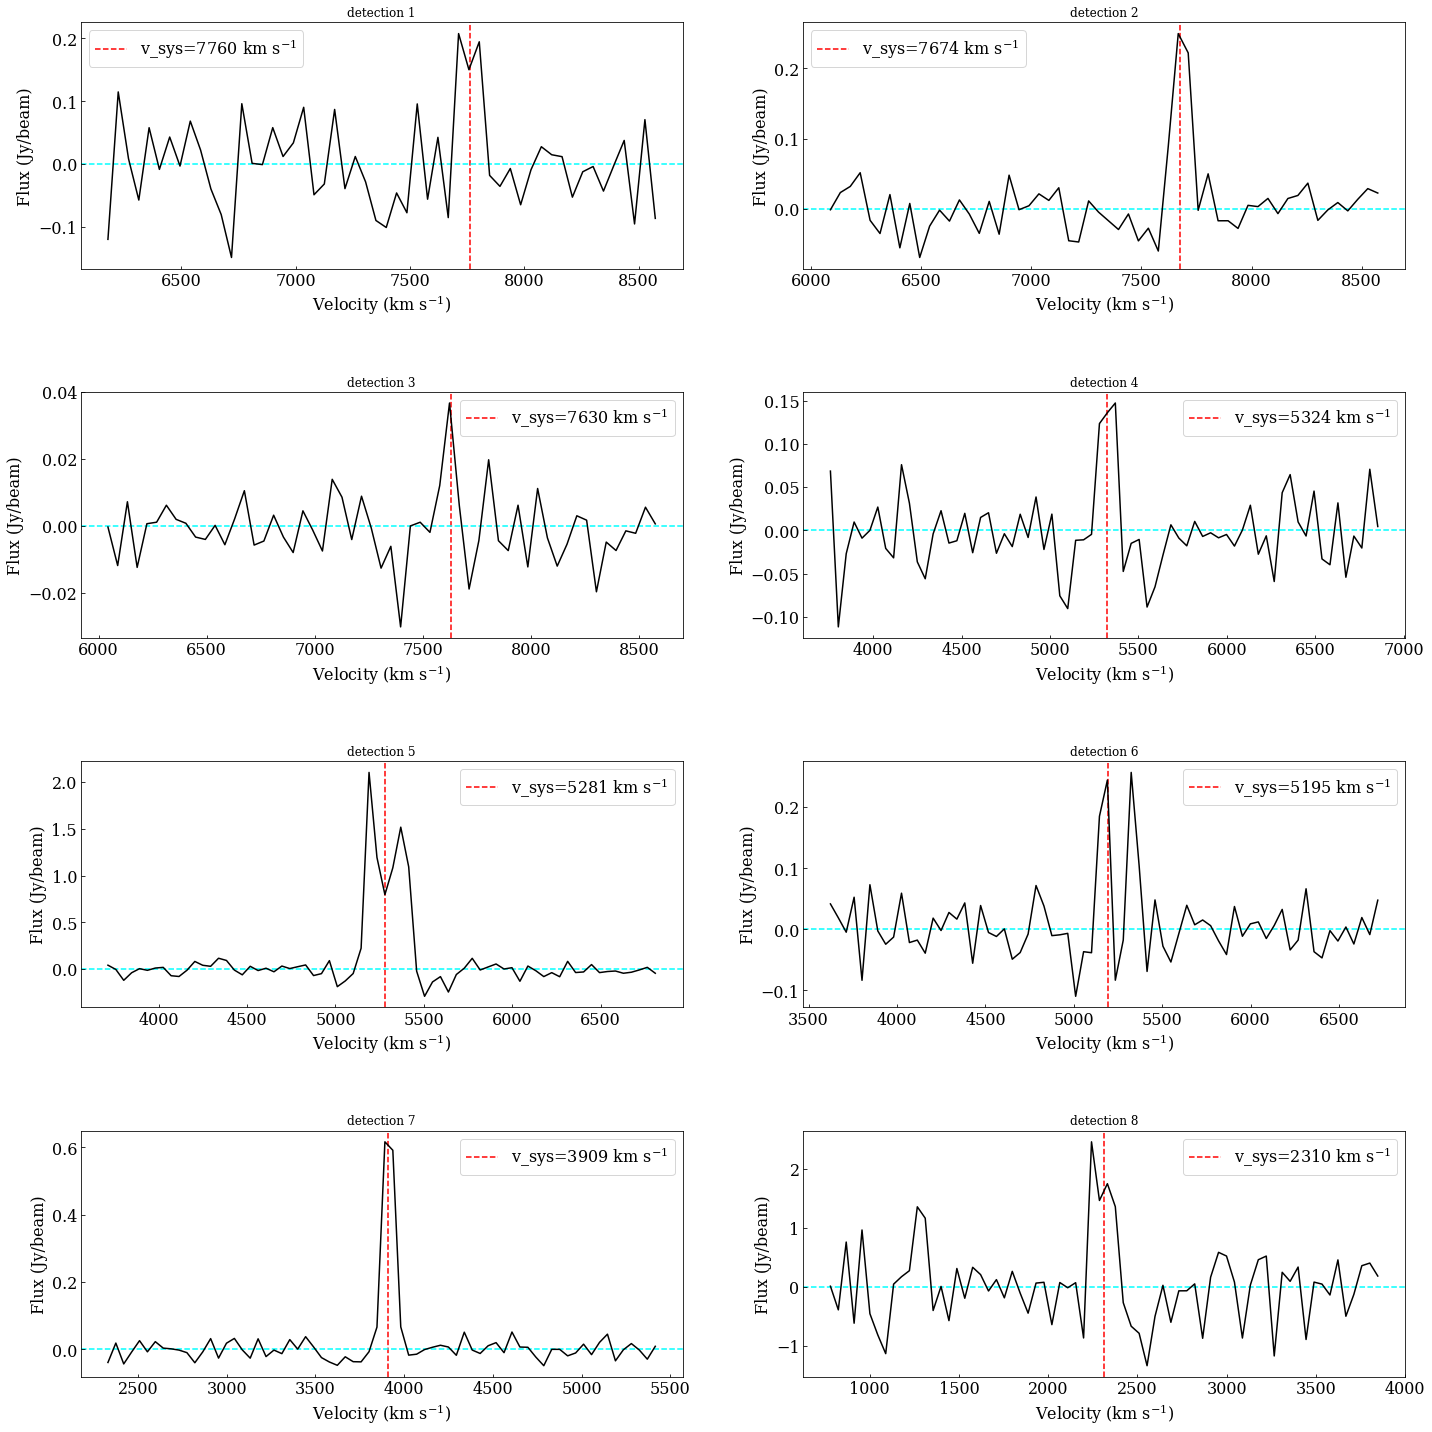

In [9]:
pl.figure(figsize=(20,20))
for i in range(len(detections)):
    pl.subplot(4,2,i+1)
    pl.plot(vel[i].value, tsum_convolved[i].array,'k',linewidth=1.5) 
    pl.axvline(x=central_vel[i], color='r', zorder=1,linestyle='--',label='v_sys='+str(int(central_vel[i]))+' km $\mathrm{s^{-1}}$')
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(i+1))
    pl.xlabel('Velocity (km $\mathrm{s^{-1}}$)')
    pl.ylabel('Flux (Jy/beam)')
    pl.tight_layout()
    pl.legend(fontsize=16,loc="best")
pl.subplots_adjust(hspace=0.5,wspace=0.2)
#pl.savefig('raw_spectrum_.png',overwrite=True)

### Getting the velocity limits of the emission

By observing the raw spectrum, we can take note in a file called `vel_limit.dat` all the velocity limits of the emission.

In [10]:
v_a = []
v_b = []
vel_limit = ascii.read('vel_limit.dat')
for i in range(len(detections)):
    v_a.append(vel_limit[i]['v_a'])
    v_b.append(vel_limit[i]['v_b'])

index_a = [] #precised index of the velocity limits
index_b = []
#central_vel = []
for i in range(len(detections)):
    x = vel[i].value
    #rather than demand an exact match, should find the closest one
    index_b.append(min(range(len(x)), key=lambda k: abs(x[k]-v_a[i])))
    index_a.append(min(range(len(x)), key=lambda k: abs(x[k]-v_b[i])))
    #central_vel.append(((vel[i][index_a[i]]+vel[i][index_b[i]])/2).value)

## 7.3 Spectral Profile fitting

As we can see from the raw spectrum, the baseline of the spectra are not yet flat enough, there are still some residual continuum left.
In order to measure the appropriate and more precised flux values. We first need to do a spectral profile fitting of the plot and again subtract the continuum. The main steps are:
*    Fit the baseline by excluding the emission
*    Subtract the baseline and correct the continuum
*    Measure the peak flux, profile widths and derive HI parameters

### 7.3.1 Off emission mask

When fitting the baseline, the region in which the emission appears should not be included. First of all, we therefore need to create a mask containing the off-emission fluxes only. This can be done easily since we already have the velocity limits of the emission.

Since the velocity is sorted from its biggest value, the smallest index `index_a` will characterize the upper limit velocity, and the biggest index `index_b` will characterize the lower limit velocity. We are only taking the fluxes below the lower velocity limit and above the upper velocity limit.

In [11]:
#creating a mask outside the profile_region
mask = []
for i in range(len(detections)):
    mask.append((vel[i].value < vel[i][index_b[i]].value) | (vel[i].value > vel[i][index_a[i]].value))

### 7.3.2 Polynomial fitting

We will do several polynomial fitting at once: from order 0 to order 3 applied to where `mask=True` and choose which polynomial is the most appropriate for the fit by making a chi-squared test.

Reduced Chi-square formula (Chi-squared per degree of freedom):
\begin{equation}
\chi_\nu^2 = \frac{\chi^2}{\nu}
\end{equation}
Where the degree of freedom or `dof`, $\nu =n-m$, equals the number of observations $n$ minus the number of fitted parameters $m$, and

<img src="./images/chi.png" width=300 height=300/>

In order to perform the fit, we will use `np.polyfit` with `full=True` which outputs the residuals (which are the sum of the squares of the error terms).

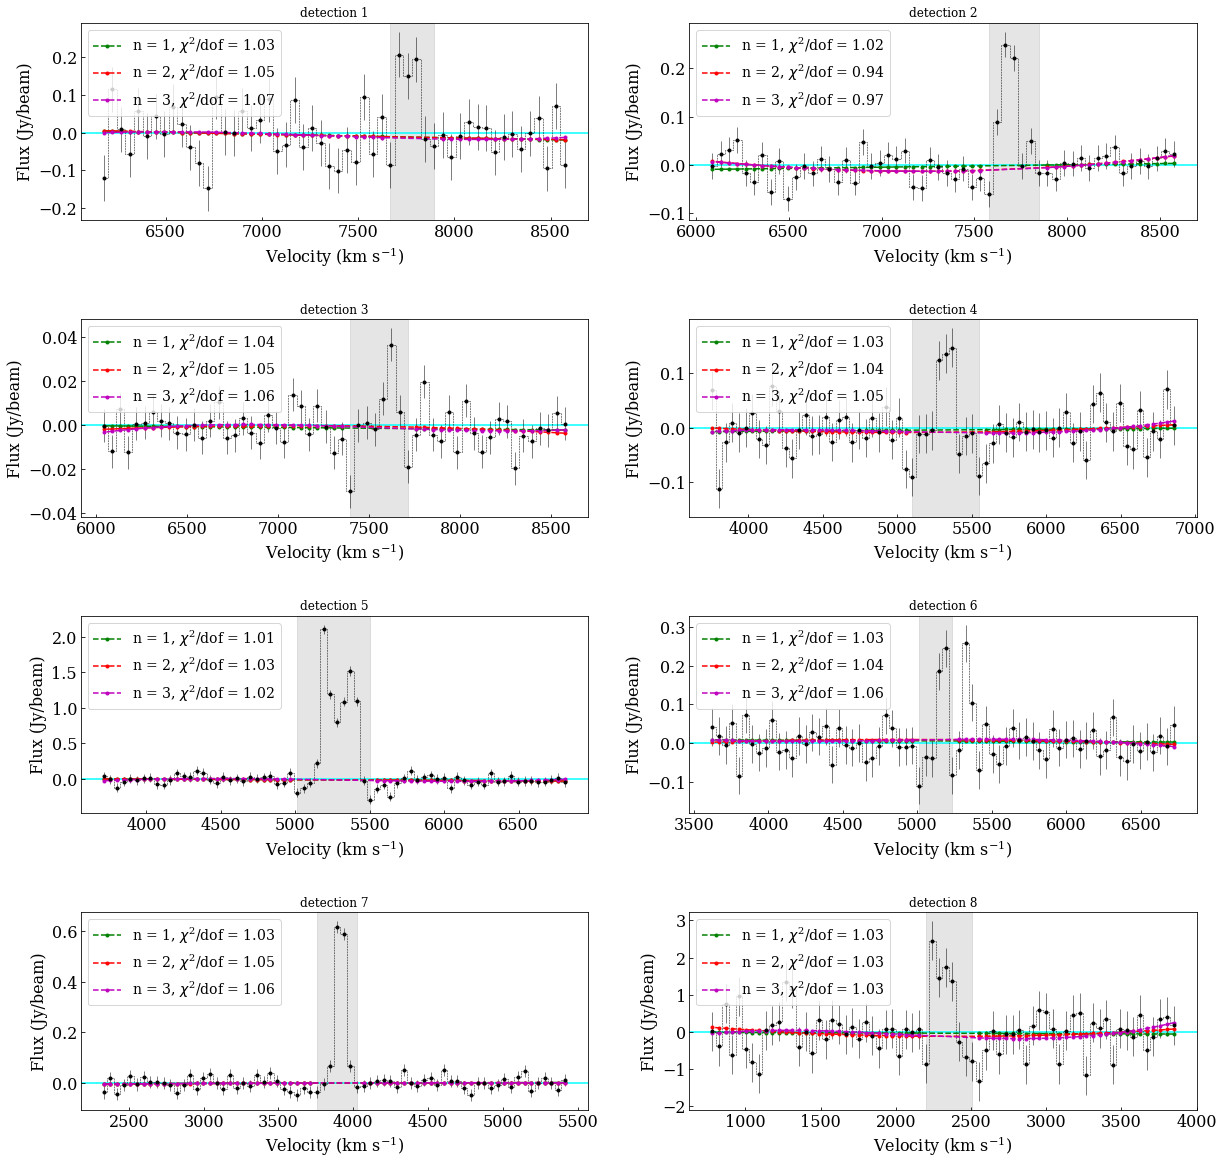

In [12]:
# Create lists to store the values
# fittedParameters are the constants polyfit returns 
# modelPredictions are the y-values evaluated at each x using the constants attained from polyfit
# res_cont are the residuals (the sum of the squares of the uncertainties in a, b, c and d)
fittedParameters_cont1 = [] # Fitting order: 1 (value of a and b in ax + b)
modelPredictions_cont1 = [] # Evaluate the fitted parameters at each x where mask == True
res_cont1 = [] # Residuals from the fit
fittedParameters_cont2 = [] # Fitting order: 2 (value of ax^2 + bx + c)
modelPredictions_cont2 = [] # Evaluate the fitted parameters at each x where mask == True
res_cont2 = [] # Residuals from the fit
fittedParameters_cont3 = [] # Fitting order: 3 (value of ax^3 + bx^2 + cx + d)
modelPredictions_cont3 = [] # Evaluate the fitted parameters at each x where mask == True
res_cont3 = [] # Residuals from the fit

# List to store the reduced chi squared values
red_chi1 = []
red_chi2 = []
red_chi3 = []

pl.figure(figsize=(20,20))

for i in range(len(detections)):
    # Do the fit on the continuum (i.e. only where mask == True)
    # n = 1
    pol1, res1, _, _, _ = np.polyfit(vel[i][mask[i]].value, tsum_convolved[i][mask[i]].value, 1,full=True)
    fittedParameters_cont1.append(pol1)
    modelPredictions_cont1.append(np.polyval(fittedParameters_cont1[i], vel[i][mask[i]].value))
    res_cont1.append(res1)
    
    # Calculate the reduced chi for the fit
    
    red_chi1.append(np.sum(pow(modelPredictions_cont1[i] - tsum_convolved[i][mask[i]].value,2)/pow(np.std(tsum_convolved[i][mask[i]].value),2))/
                      (len(tsum_convolved[i][mask[i]].value) - len(fittedParameters_cont1[i])))
    
    # n = 2
    pol2, res2, _, _, _ = np.polyfit(vel[i][mask[i]].value, tsum_convolved[i][mask[i]].value, 2,full=True)
    fittedParameters_cont2.append(pol2)
    modelPredictions_cont2.append(np.polyval(fittedParameters_cont2[i], vel[i][mask[i]].value))
    res_cont2.append(res2)
    
    # Calculate the reduced chi for the fit
    red_chi2.append(np.sum(pow(modelPredictions_cont2[i] - tsum_convolved[i][mask[i]].value,2)/pow(np.std(tsum_convolved[i][mask[i]].value),2))/
                      (len(tsum_convolved[i][mask[i]].value) - len(fittedParameters_cont2[i])))
    
    # n = 3
    pol3, res3, _, _, _ = np.polyfit(vel[i][mask[i]].value, tsum_convolved[i][mask[i]].value, 3,full=True)
    fittedParameters_cont3.append(pol3)
    modelPredictions_cont3.append(np.polyval(fittedParameters_cont3[i], vel[i][mask[i]].value))
    res_cont3.append(res3)
    
    # Calculate the reduced chi for the fit
    red_chi3.append(np.sum(pow(modelPredictions_cont3[i] - tsum_convolved[i][mask[i]].value,2)/pow(np.std(tsum_convolved[i][mask[i]].value),2))/
                      (len(tsum_convolved[i][mask[i]].value) - len(fittedParameters_cont3[i])))
    
    # Plot the profiles as well as the fits
    pl.subplot(4,2,i+1)
    pl.step(vel[i].value, tsum_convolved[i].array,'k',linestyle='dashed',linewidth=0.5,where='mid')
    #pl.plot(vel[i].value[mask[i]],tsum_convolved[i][mask[i]].value,'o')
    
    # Polynomial fits
    pl.plot(vel[i].value[mask[i]],modelPredictions_cont1[i],'g--.', 
            label=r'n = 1, $\chi^2$/dof = %.2f'%red_chi1[i])
    pl.plot(vel[i].value[mask[i]],modelPredictions_cont2[i],'r--.', 
            label=r'n = 2, $\chi^2$/dof = %.2f'%red_chi2[i])
    pl.plot(vel[i].value[mask[i]],modelPredictions_cont3[i],'m--.', 
            label=r'n = 3, $\chi^2$/dof = %.2f'%red_chi3[i])
    
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='-')
    pl.title('detection '+str(i+1))
    pl.xlabel('Velocity (km $\mathrm{s^{-1}}$)')
    pl.ylabel('Flux (Jy/beam)')
    pl.tick_params(which='major', direction='in')
    pl.legend(fontsize=14,loc="upper left")
    ax = pl.gca()
    ax.axvspan(vel[i][index_a[i]].value, vel[i][index_b[i]].value, alpha=0.2, color='grey')
    pl.errorbar(vel[i].value, tsum_convolved[i].array, yerr=np.std(tsum_convolved[i][mask[i]].value), fmt='k.',linewidth=0.5)
    
pl.subplots_adjust(hspace=0.5)

The grey region indicates the masked region where the emission lies. Errorbars (standard deviations) are plotted for the fluxes. We will now have to choose orders that best describes the continua, i.e. orders with a reduced chi-square $\chi^2$/dof closest to $1$.

* `Choice of polynomial order:`

In [13]:
model_no = [] # List to store the order of the models for each detection

# Loop through each detection
for i in range(len(detections)):
    # Store each order's value in a list
    chi_n1 = red_chi1[i]
    chi_n2 = red_chi2[i]
    chi_n3 = red_chi3[i]
    chi_list = [chi_n1, chi_n2, chi_n3]
    
    # Check to see which polynomial fit has a reduced chi squared closest to 1
    min_chi = min(range(len(chi_list)), key=lambda i: abs(chi_list[i] - 1))
    model_no.append(min_chi + 1)
    
# List to store the model predictions of the flux and the final fitted parameters
modelPredictions = []
fitparam = []

# List to store the corresponding residuals
cont_res = []

for i in range(len(detections)):
    if model_no[i] == 1:
        modelPredictions.append(modelPredictions_cont1[i])
        fitparam.append(fittedParameters_cont1[i])
        cont_res.append(res_cont1[i])
        
    elif model_no[i] == 2:
        modelPredictions.append(modelPredictions_cont2[i])
        fitparam.append(fittedParameters_cont2[i])
        cont_res.append(res_cont2[i])
        
    elif model_no[i] == 3:
        modelPredictions.append(modelPredictions_cont3[i])
        fitparam.append(fittedParameters_cont3[i])
        cont_res.append(res_cont3[i])

Let's now see how the chosen fit look like

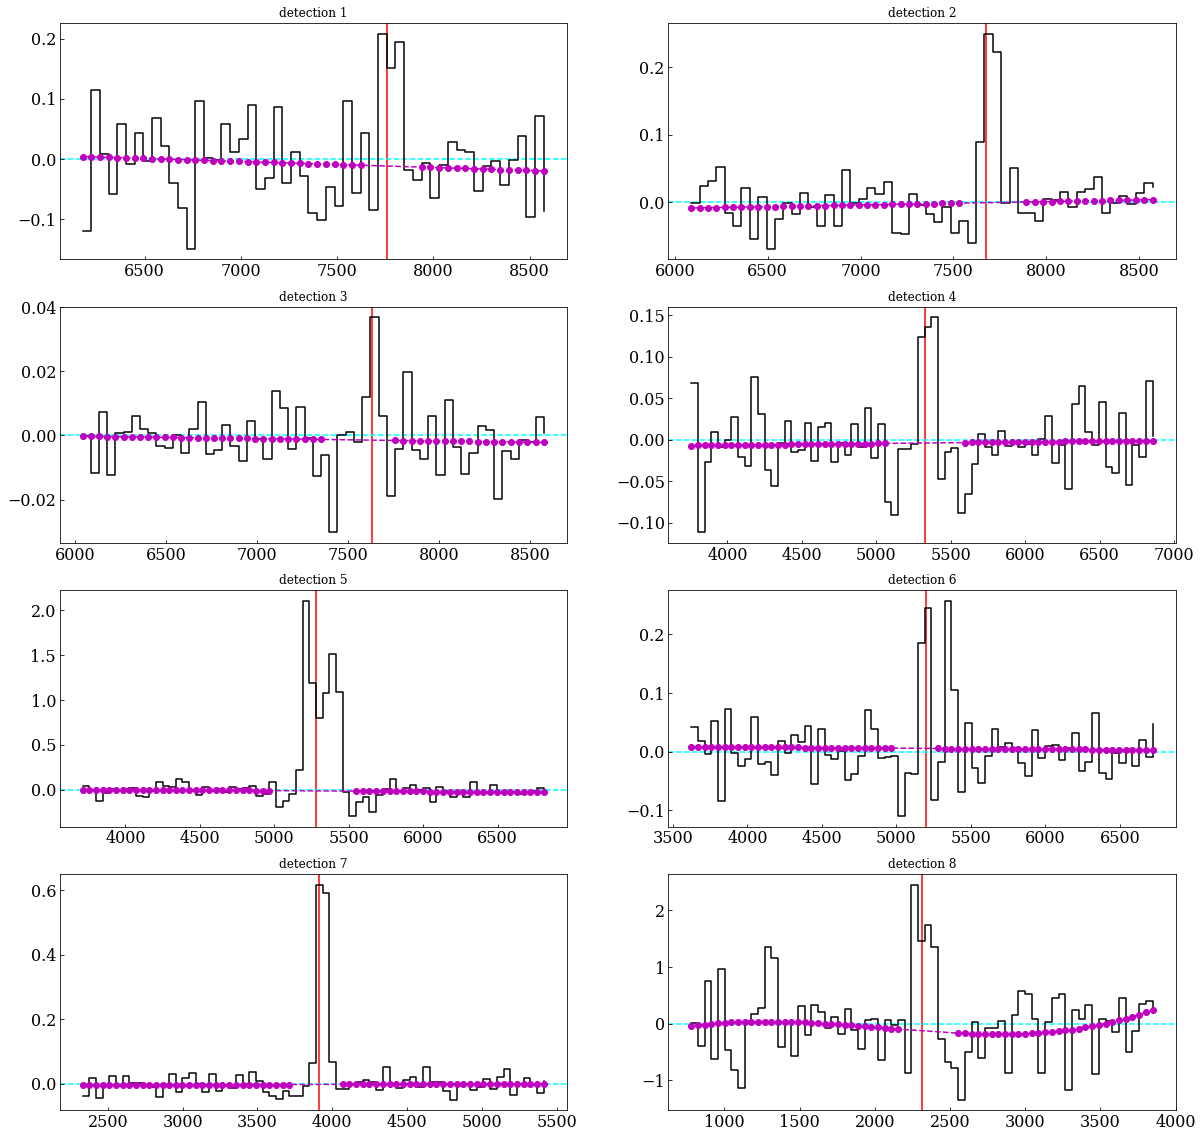

In [14]:
pl.figure(figsize=(20,20))
for i in range(len(detections)):
    pl.subplot(4,2,i+1)
    pl.step(vel[i].value, tsum_convolved[i].array,'k',linewidth=1.5) 
    pl.plot(vel[i].value[mask[i]],modelPredictions[i],'--om') #baseline
    
    pl.axvline(x=central_vel[i], color='red', zorder=1)
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(i+1))
pl.subplots_adjust(hspace=0.2)

Since the fitted values (`modelPredictions`) and the initial data do not have the same length, we need to get the fitted points between the masked value.
* ` Get the index where the velocity is masked`

We already now where the emission is masked, it is where `mask = False`. Since we already have the fitted parameters value, we can just apply these parameters to the masked region in velocity, insert it into the `modelPredictions` list, then we obtain the fitted baseline.
Note: the velocity is proportionnaly inversed to the frequency, an index = 0, indicates the maximum velocity.

The beginning of the array value of the velocity axis is therefore on the right and ends on the left

In [15]:
baseline = []
new_model = [] #Fitted baseline for the emission only
for i in range(len(detections)):
    new_model.append(np.polyval(fitparam[i], vel[i][np.argwhere(mask[i]== False)].value.flatten()))
    #flatten into a 1D array, get the velocity range where mask == False
    #new_model.append(np.polyval(fitparam[i], vel[i][index_a[i]:index_b[i]+1].value) #Similar
    baseline.append(np.insert(modelPredictions[i],index_a[i],new_model[i]))

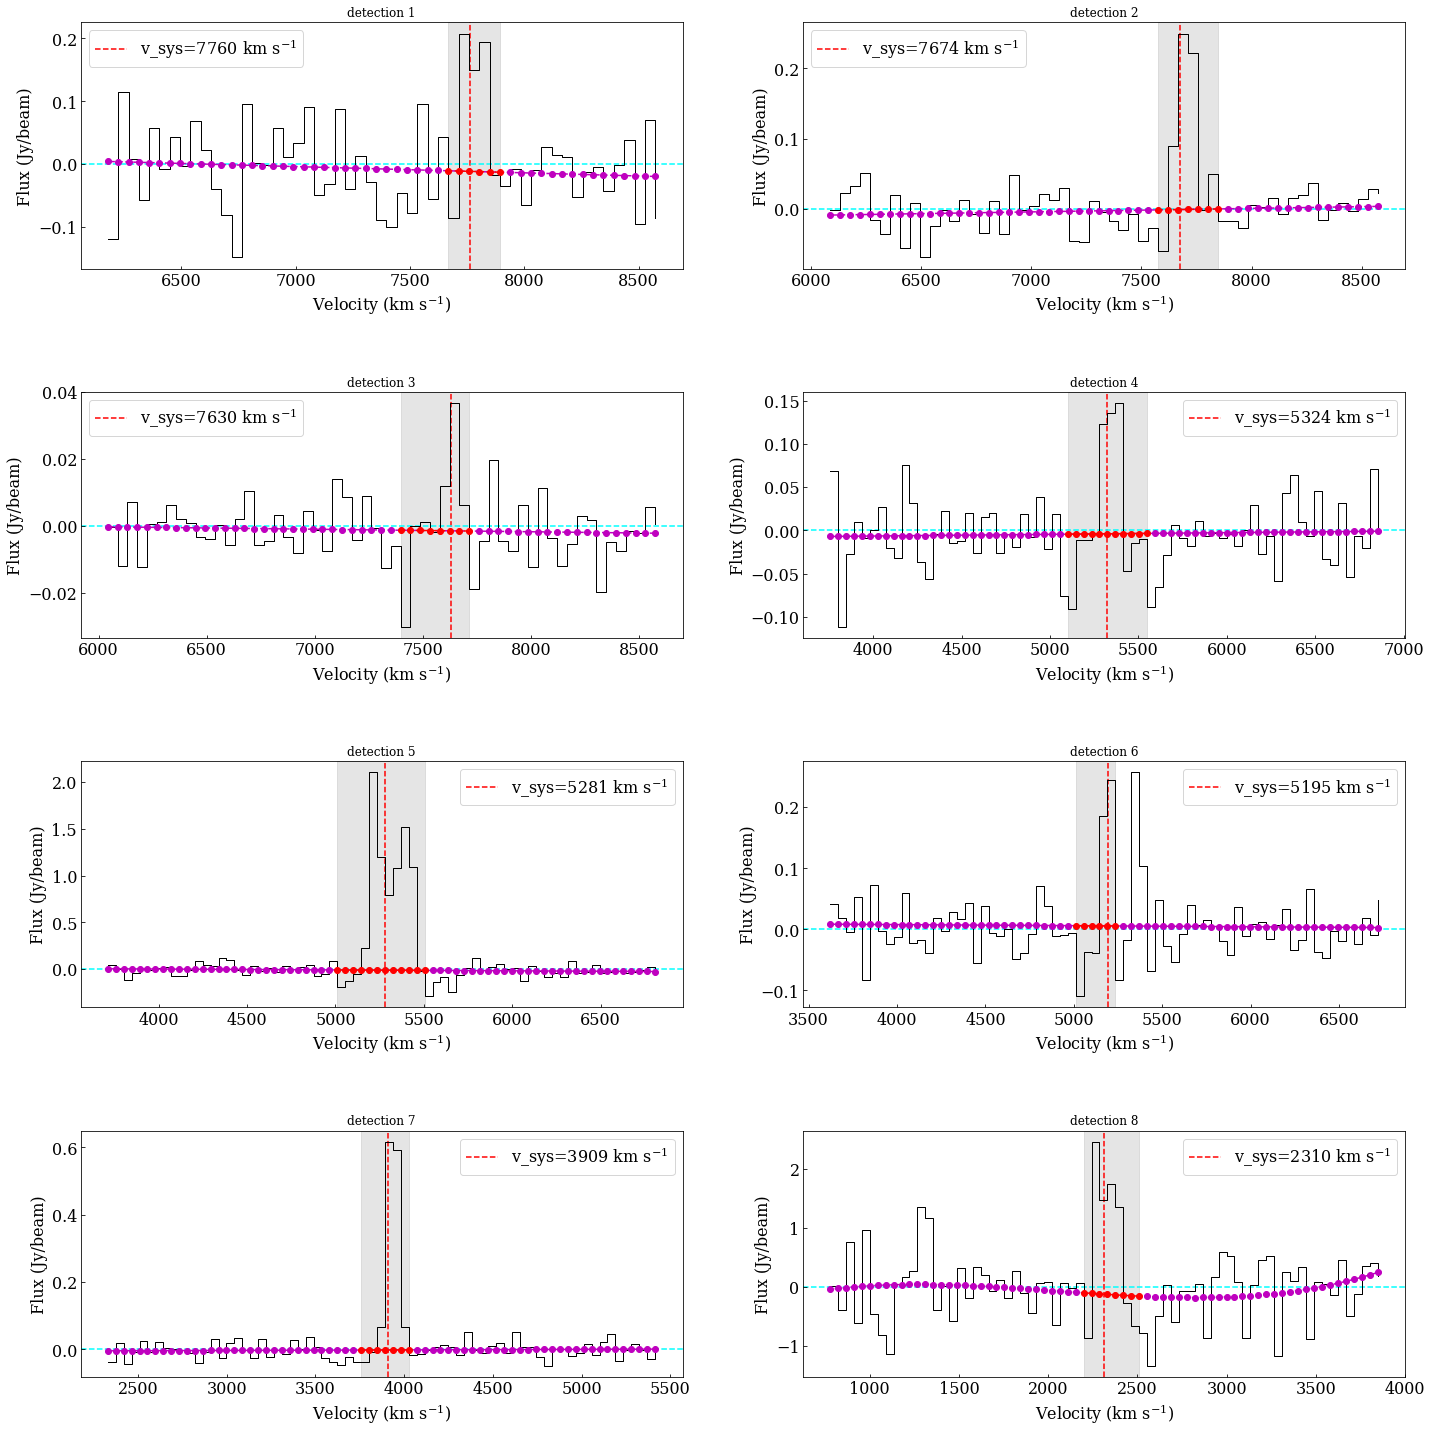

In [16]:
pl.figure(figsize=(20,20))
for i in range(len(detections)):
    pl.subplot(4,2,i+1)
    pl.step(vel[i].value, tsum_convolved[i].array,'k',linewidth=1) 
    pl.axvline(x=central_vel[i], color='r', zorder=1,linestyle='--',label='v_sys='+str(int(central_vel[i]))+' km $\mathrm{s^{-1}}$')
    pl.plot(vel[i].value[mask[i]],modelPredictions[i],'--om') #baseline
    pl.plot(vel[i].value[index_a[i]:index_b[i]+1],new_model[i],'--or')
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(i+1))
    pl.xlabel('Velocity (km $\mathrm{s^{-1}}$)')
    pl.ylabel('Flux (Jy/beam)')
    pl.tight_layout()
    ax = pl.gca()
    ax.axvspan(vel[i][index_a[i]].value, vel[i][index_b[i]].value, alpha=0.2, color='grey')
    pl.legend(fontsize=16,loc="best")
pl.subplots_adjust(hspace=0.5,wspace=0.2)
#pl.savefig('raw_spectrum_.png',overwrite=True)

### 7.3.3 Continuum subtraction

Let's correct the baseline by subtracting it to the initial flux. We are therefore obtaining baseline fitted fluxes in Jy/beam called `contsub_flux`

In [17]:
contsub_flux = []
for i in range(len(detections)):
    contsub_flux.append(np.subtract(tsum_convolved[i],baseline[i]))

### 7.3.4 Before and After baseline fitting

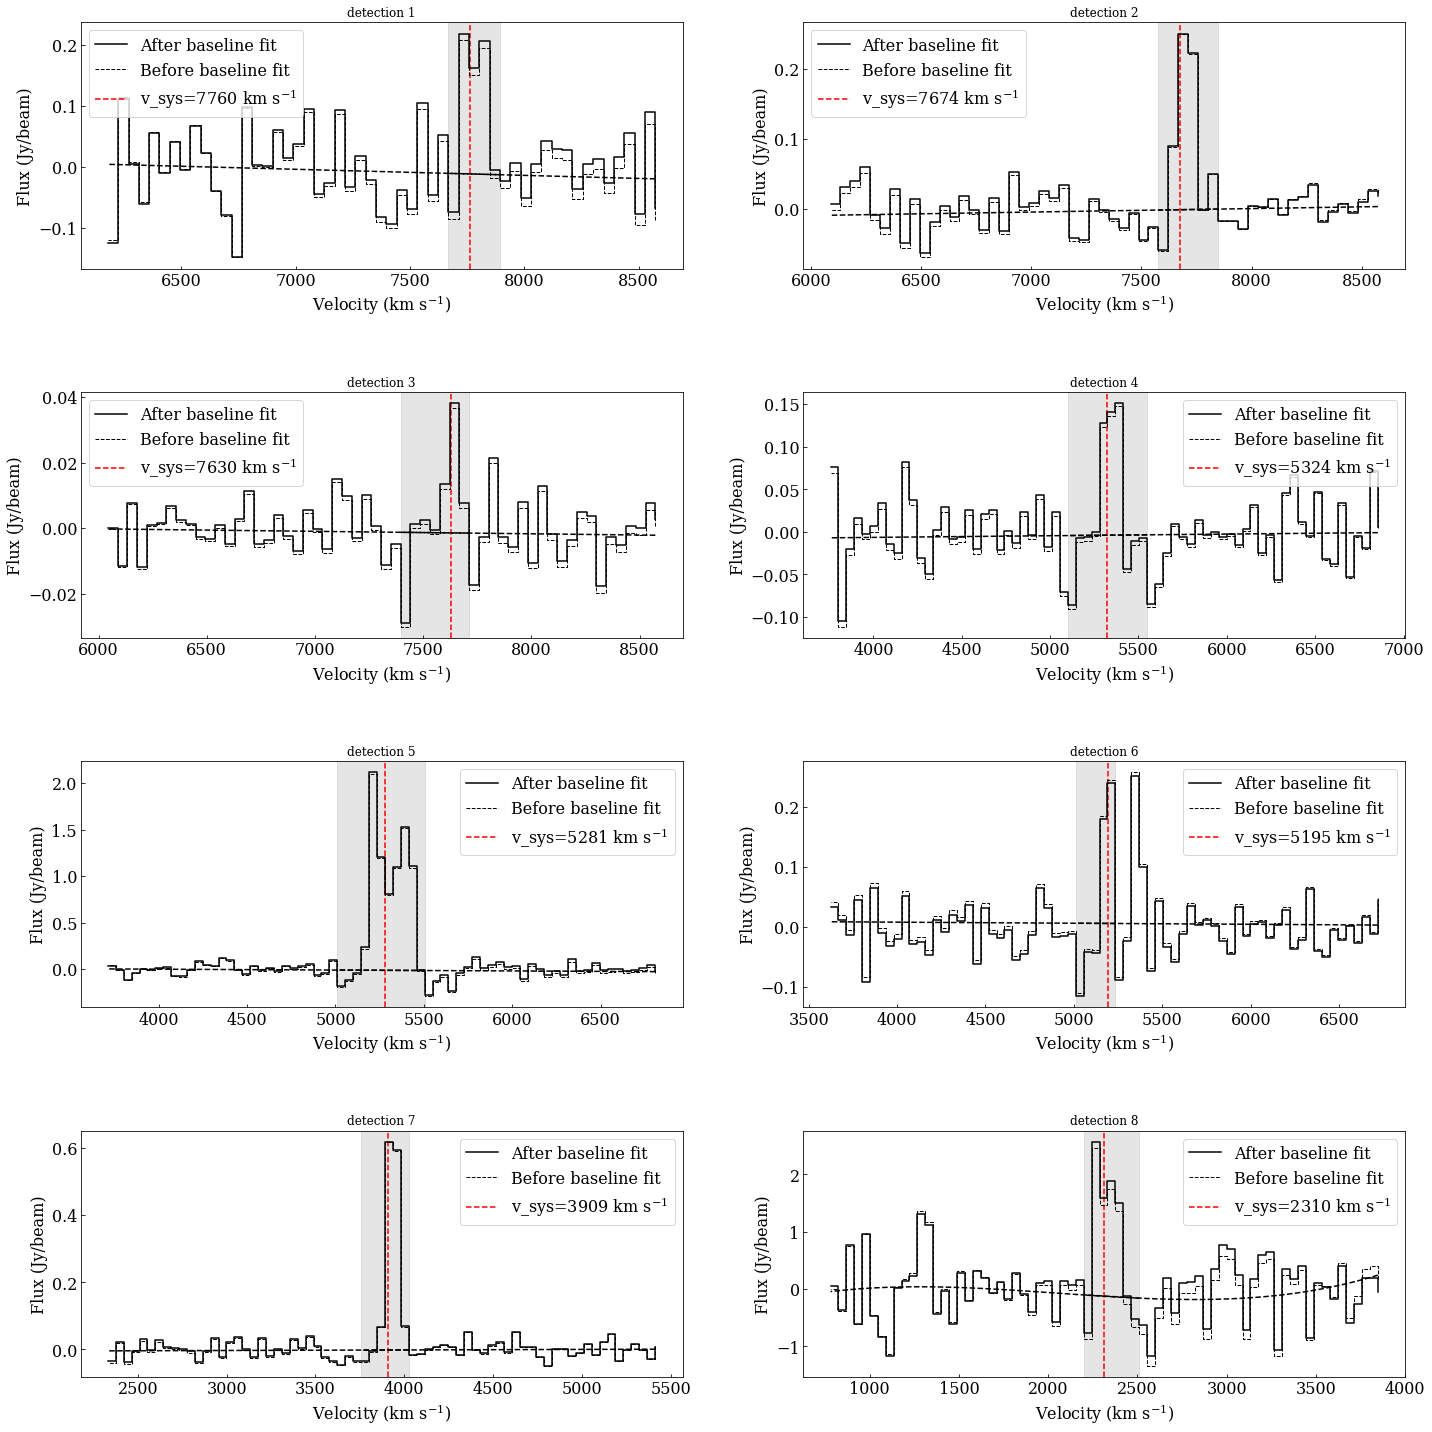

In [18]:
pl.figure(figsize=(20,20))
for i in range(len(detections)):
    pl.subplot(4,2,i+1)
    pl.step(vel[i].value, contsub_flux[i],'k',linewidth=1.5, label = 'After baseline fit')
    pl.step(vel[i].value, tsum_convolved[i].array,'k--',linewidth=1, label = 'Before baseline fit')
    pl.axvline(x=central_vel[i], color='r', zorder=1,linestyle='--',label='v_sys='+str(int(central_vel[i]))+' km $\mathrm{s^{-1}}$')
    pl.plot(vel[i].value[mask[i]],modelPredictions[i],'--k') #baseline
    pl.plot(vel[i].value[index_a[i]:index_b[i]+1],new_model[i],'--k')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(i+1))
    pl.xlabel('Velocity (km $\mathrm{s^{-1}}$)')
    pl.ylabel('Flux (Jy/beam)')
    pl.tight_layout()
    pl.legend(fontsize=16,loc="best")
    ax = pl.gca()
    ax.axvspan(vel[i][index_a[i]].value, vel[i][index_b[i]].value, alpha=0.2, color='grey')
pl.subplots_adjust(hspace=0.5,wspace=0.2)
#pl.savefig('spectrum_.png',overwrite=True)

# 8. Analysis 4: Flux density calculations and HI masses

## 8.1 Flux density: Conversion from Jy/beam to Jy 

To convert from Jy/beam to Jy, we need to multiply the fluxes by a scaling factor which includes the beam. So first, we need to know our beams.

In our case, we have a 2D Gaussian beam. For a Gaussian, the beam area can be obtained by its solid angle (see this [astropy](http://docs.astropy.org/en/stable/api/astropy.units.equivalencies.brightness_temperature.html) document about brightness temperature and beam area):
$$ \Omega_B = 2 \times \pi \times \sigma^2 $$
but where the σ of the Gaussian beam can be calculated from the major and minor axes of the ellipse equal to the FWHM values of the gaussian.
References: 
* https://www.eaobservatory.org/jcmt/faq/how-can-i-convert-from-mjybeam-to-mjy/
* http://tsrice-research.blogspot.com/2016/05/how-to-manually-extract-flux-in-jy-from.html

$$\text{FWHM} = 2 \sigma \sqrt{2 ln2}$$

The beam solid angle or **beam area** $\Omega_B$ has a relation with the physical area at its FWHM given by:

\begin{equation}
\bbox[#F0F0F0, 10px, border:1px solid black]{\Omega_B = \frac{\pi b_\text{maj}b_\text{min}}{4\text{ln}2}} \tag{1}
\end{equation}
(See in eq. 3G4 from https://www.cv.nrao.edu/course/astr534/Interferometers2.html)

$b_\text{maj}$ and $b_\text{min}$ can be expressed either in *arcsec* or *radians*. It will not change the equivalency value. But we need to take that into account for other calculations.

The number of pixels contained in a beam is
$$ \text{Number of pixels in a beam} = \frac{\Omega_B}{\text{dpix}^2} $$
Ref: https://www.eaobservatory.org/jcmt/faq/how-can-i-convert-from-mjybeam-to-mjy/

**N.B:** when the number of pixels in a beam is inverted, we obtain a scaling factor that is absolutely needed when converted Jy/beam to Jy, especially when we use the `sum values of all the pixels in the region` to get the flux.
$$\bbox[10px, border:1px solid black]{\text{Scaling beam factor} = \frac{\text{dpix}^2}{\Omega_B}}$$

As seen in the image below from Meyer et al (2017), we have to **multiply by the pixel area and divide by the area of the telescope beam**

If the fluxes were obtained from the sum intensity, or the brightness temperature, we just need to multiply them by the scaling factor:
$$\bbox[#F0F0F0, 10px, border:1px solid black]{\text{F(Jy/beam)} \times \text{Scaling beam factor} = \text{F(Jy)}}$$ 

<img src="./images/Picture 3.png" width=1000 height=1000 />

In [19]:
def scale_factor_common(cube): #if common beam
    FWHM = np.pi/(4*np.log(2))
    dpix = cube.header['CDELT2']*3600
    bmaj = cube.beam.major.to(u.arcsec).value
    bmin = cube.beam.minor.to(u.arcsec).value
    beam_area = FWHM*bmaj*bmin
    scale_factor = dpix**2/beam_area #one number
    return scale_factor

def scale_factor_multiple_beams(cube): #if multiple beams
    FWHM = np.pi/(4*np.log(2))
    dpix = cube.header['CDELT2']*3600
    bmaj = cube.beams.major.value
    bmin = cube.beams.minor.value
    beam_area = FWHM*bmaj*bmin #arcsec
    scale_factor = dpix**2/beam_area #array
    return scale_factor

def adjust_flux(flux,scaling): #Similar to Jy_beam_to_Jy but for baseline fitted flux
    return flux*scaling

def Jy_beam_to_Jy(cube):
    flux = []
    for i in range(len(detections)):
        try:
            flux.append(np.nan_to_num(cube[i].sum(axis=(1,2)).value*scale_factor_common(cube[i])))
        except Exception:
            flux.append(np.nan_to_num(cube[i].sum(axis=(1,2)).value*scale_factor_multiple_beams(cube[i])))
    return flux

In [20]:
# Flux density baseline fitted and non fitted
flux_fit = [] #Contsub flux into Jy
flux = [] #tsum convolved into Jy
for i in range(len(detections)):
    flux_fit.append(adjust_flux(contsub_flux[i].value,scale_factor_common(subcube[i])))
    flux.append(adjust_flux(tsum_convolved[i].value,scale_factor_common(subcube[i])))

## HI Global Profile

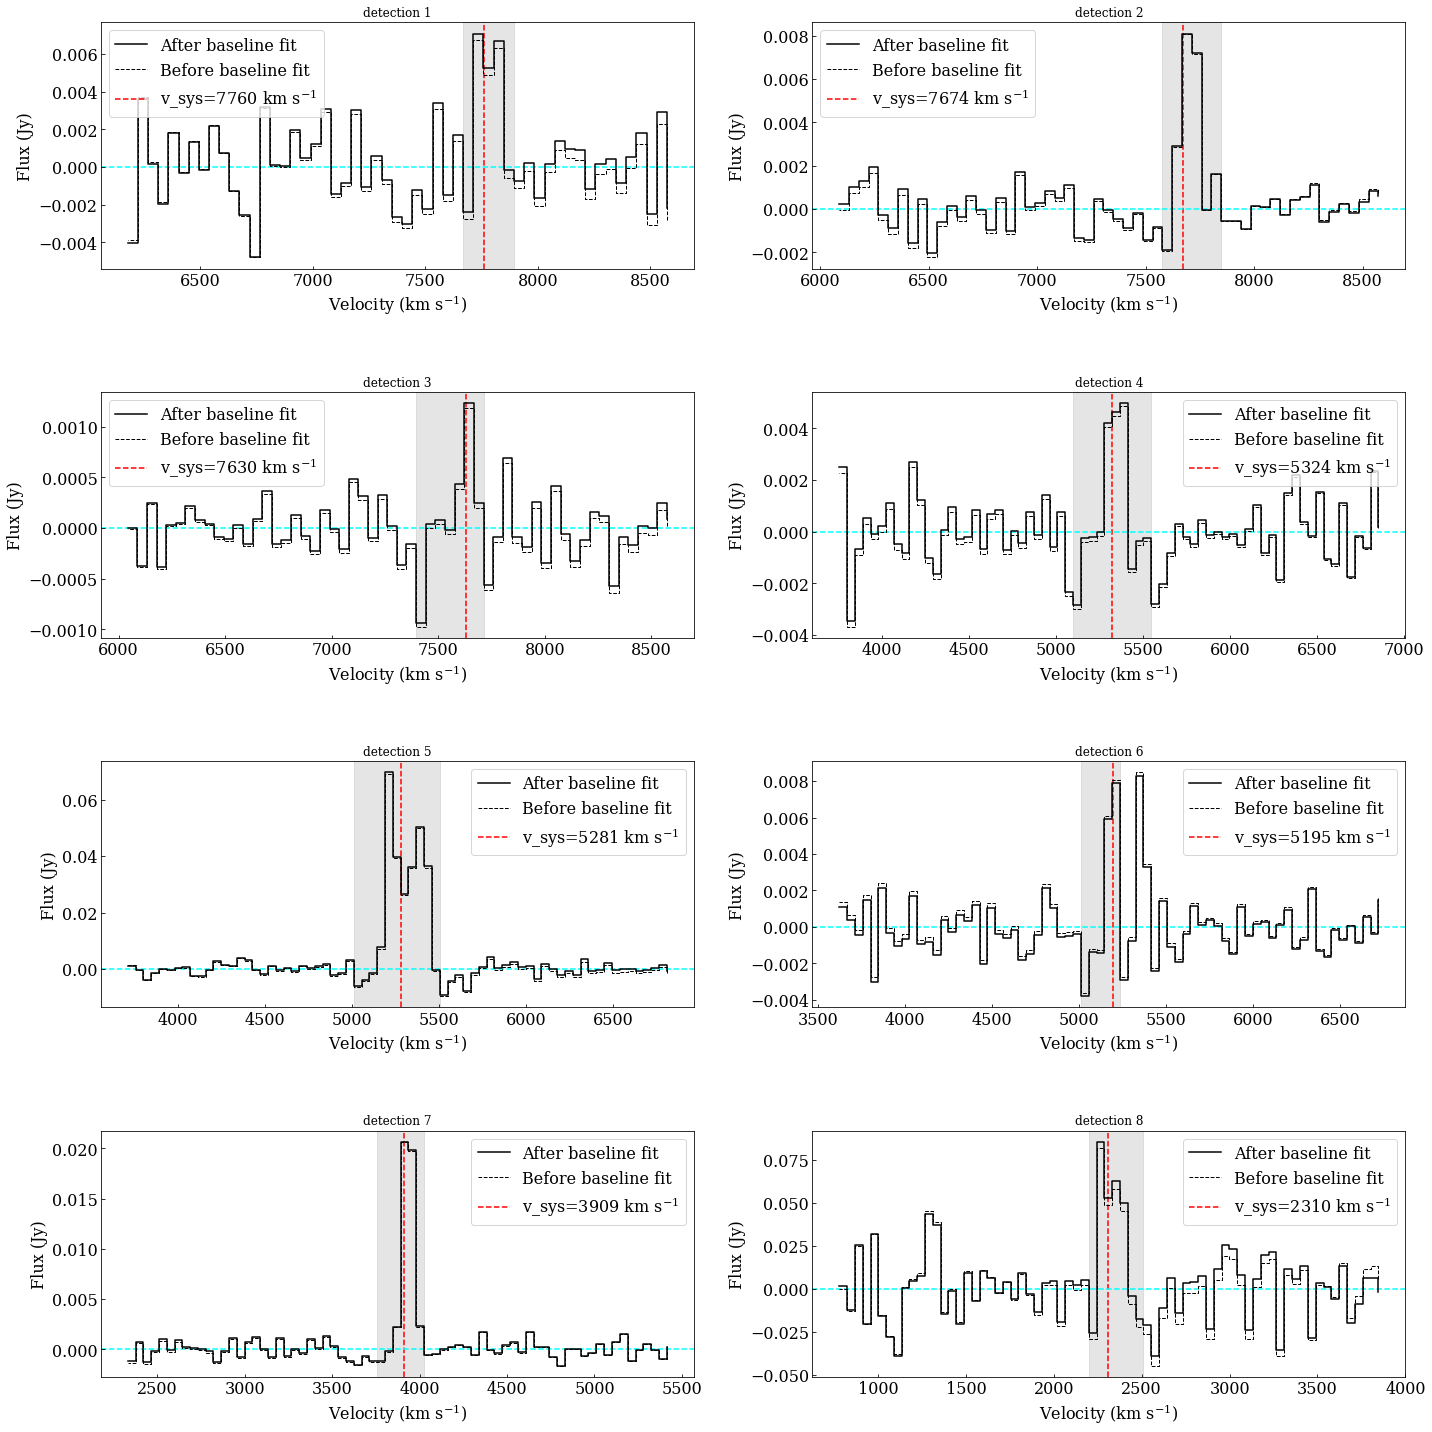

In [21]:
pl.figure(figsize=(20,20))
for i in range(len(detections)):
    pl.subplot(4,2,i+1)
    pl.step(vel[i].value, flux_fit[i],'k',linewidth=1.5, label = 'After baseline fit')
    pl.step(vel[i].value, flux[i],'k--',linewidth=1, label = 'Before baseline fit')
    pl.axvline(x=central_vel[i], color='r', zorder=1,linestyle='--',label='v_sys='+str(int(central_vel[i]))+' km $\mathrm{s^{-1}}$')
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(i+1))
    pl.xlabel('Velocity (km $\mathrm{s^{-1}}$)')
    pl.ylabel('Flux (Jy)')
    pl.tight_layout()
    pl.legend(fontsize=16,loc="best")
    ax = pl.gca()
    ax.axvspan(vel[i][index_a[i]].value, vel[i][index_b[i]].value, alpha=0.2, color='grey')
pl.subplots_adjust(hspace=0.5,wspace=0.2)
#pl.savefig('spectrum_.png',overwrite=True)

## 8.2 Flux density calculations from the Brightness Temperature
***
In order to get flux densities, another method available for us is to convert the intensity into Kelvin. This can be done directly in `SpectralCube` by converting the cube unit. But it can also be done manually, which is explained below.

### Conversion from Jy/beam to Kelvin using formula

The brightness temperature in Kelvin of a blackbody can be converted into the same intensity as the source. $T_B$ can be obtained from the spectral axis of the cube (frequency or wavelength) and the sum intensity $I_{\nu}$ using the following formulae from https://ned.ipac.caltech.edu/level5/March17/Watson/Watson3.html and https://science.nrao.edu/facilities/vla/proposing/TBconv:

\begin{align}
\left(\frac{T_\nu}{\text{K}}\right) &= 13.6 \left(\frac{\lambda}{\text{mm}}\right)^2\left(\frac{I_\nu}{\text{Jy/beam}}\right)\left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{"}\times1^{"}}\right)^{-1},  \tag{2} \\
                                    &= 13.6 \left(\frac{\lambda}{10^{-1}\text{cm}}\right)^2\left(\frac{I_\nu}{\text{Jy/beam}}\right)\left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{"}\times1^{"}}\right)^{-1}, \\
 \left(\frac{T_\nu}{\text{K}}\right)&= 1.36 \times 10^3 \left(\frac{\lambda}{\text{cm}}\right)^2\left(\frac{I_\nu}{\text{Jy/beam}}\right)\left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{"}\times1^{"}}\right)^{-1}. \tag{3} \\
                                    &= 1.36 \times 10^7 \left(\frac{\lambda}{\text{m}}\right)^2\left(\frac{I_\nu}{\text{Jy/beam}}\right)\left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{"}\times1^{"}}\right)^{-1}
\end{align}

In radio observations, the frequency is rather used. From the equation 
$$\bbox[#F0F0F0, 10px, border:1px solid black]{\nu[\text{Hz}] = \frac{c[\text{m/s}]}{\lambda[\text{m}]}}$$ where c = 299792458 m/s, then
\begin{align}
\left(\frac{T_\nu}{\text{K}}\right) &= 1.36 \times 10^7 \left(\frac{c}{\text{m/s}}\right)^2 \left(\frac{\nu}{\text{Hz}}\right)^{-2}\left(\frac{I_\nu}{\text{Jy/beam}}\right)\left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{"}\times1^{"}}\right)^{-1},\\
                                    &= 1.222 \times 10^{24} \left(\frac{\nu}{\text{Hz}}\right)^{-2}\left(\frac{I_\nu}{\text{Jy/beam}}\right)\left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{"}\times1^{"}}\right)^{-1} \\
\left(\frac{T_\nu}{\text{K}}\right) &= 1.222 \times 10^6 \left(\frac{\nu}{\text{GHz}}\right)^{-2}\left(\frac{I_\nu}{\text{Jy/beam}}\right)\left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{"}\times1^{"}}\right)^{-1} \tag{4}
\end{align}

In [22]:
# Function to convert Jy/beam to K and scaled
def Jy_beam_to_K_from_lambda(cube_list, F, sum_br):
    '''
    cube_list is the list of subcubes. Used to get the beams of each subcube
    F is the list of frequencies in Hz for each subcube
    sum_br is the array of brightness values in Jy/beam
    '''
    Br_T = [] # List to store the list of brightness temperatures for each subcube
    
    for i in range(len(detections)):
        # Store the subcube in a variable
        subcube = cube_list[i]
        
        # List to store brightness temperature of this subcube 
        T = []
        
        for j in range(len(subcube)):
            # Convert each sum brightness in the subcube spectrum to brightness temperature
            # Calculate wavelength in mm from the frequency
            Lambda = (F[i][j]).to(u.mm, equivalencies=u.spectral()).value
            
            # Sum brightness
            I_nu = sum_br[i][j].value
            
            try:
                bmaj = subcube.beams[j].major.to(u.arcsec).value #beam values for each channel if mutli beam
                bmin = subcube.beams[j].minor.to(u.arcsec).value
            except Exception:
                bmaj = subcube.beam.major.to(u.arcsec).value #beam values for each channel if mutli beam
                bmin = subcube.beam.minor.to(u.arcsec).value
                
            # Brightness temperature at the jth value of the subcube
            Tj = 13.6*pow(Lambda,2)*I_nu*pow(bmaj*bmin,-1)
            
            
            T.append(Tj*scale_factor_common(subcube)) 
        # Store brightness temperatures for each subcube    
        Br_T.append(T)
        
    return Br_T

#### The baseline fitted flux in Jy/beam can be converted into brightness temperature using:

In [23]:
freq = [] #list of frequency
for i in range(len(detections)):
    freq.append(subcube[i].spectral_axis)

T_b_fit = Jy_beam_to_K_from_lambda(subcube, freq, contsub_flux) #Jy/beam to K and scaled from beam

However, there is a direct and quicker method from the subcube:
### Direct conversion of cube unit from Jy/beam to K and scaling

N.B: This will be the brightness temperature directly read from the cube, no baseline correction

We can also convert the noise cubes into Kelvin

In [24]:
kcube = []
knoisecube = []
T_b = [] #Brightness temperature from the cube with unit Kelvin and scaled.
T_b_beam = [] #Brigthness temperature in K/beam
for i in range(len(detections)):
    kcube.append(vel_subcube[i].to(u.K))
    knoisecube.append(noisecube[i].to(u.K))
    x = kcube[i].sum(axis=(1,2))/kcube[i].unit #k/beam
    T_b_beam.append(x)
    T_b.append(adjust_flux(x,scale_factor_common(kcube[i])).value) #Brightness temperature scaled

### Brightness temperature to Flux density in Jy

The brightness temperature is a unit very commonly used in radio astronomy. See, e.g., “Tools of Radio Astronomy” (Wilson 2009) eqn 8.16 and eqn 8.19 (these pages are available on [google books](https://books.google.co.za/books?id=9KHw6R8rQEMC&pg=PA179&source=gbs_toc_r&redir_esc=y#v=onepage&q&f=false)).

<img src="./images/b1.png" width=700 height=700 />

Now that we have the brightness temperature $T_\nu$, we can calculate the flux $S_\nu$ in terms of Jy using

\begin{align}
T_\nu &= \frac{c^2}{2\nu^2k}\left(\frac{S_\nu}{\Omega_B}\right)
\end{align}
$$ => \bbox[#F0F0F0, 10px, border:1px solid black]{S_\nu = \frac{2\nu^2kT_\nu \Omega_B}{c^2}}$$


where $\nu = \nu_{\text{HI}}$ is the frequency in Hz of the HI line, $k$ is the Boltmann's constant in J K$^{-1}$ or m$^2$kgs$^{-2}$ K$^{-1}$ in SI (section 2.2.2, table 3, [SI brochure](https://www.bipm.org/utils/common/pdf/si_brochure_8.pdf)), and $\Omega_B$ is the solid angle of the source and has the relation with the physical area given by equation (1):

\begin{align}
\Omega_B = \frac{\pi b_\text{maj}b_{min}}{4\text{ln}2}, \\
\end{align}

in units of steradians (radians squared, radian SI base unit = m m$^{-1}$) or m$^2$m$^{-2}$ (Section 2.2.2, Table 3 at https://www.bipm.org/utils/common/pdf/si_brochure_8.pdf). To know what units to parse into the equation for $S_\nu$, we can perform dimensional analysis:

\begin{align}
S_\nu &= \frac{2\nu^2kT_\nu \Omega_B}{c^2} \\
    &= \frac{[\text{Hz}^2][\text{J K}^{-1}][\text{sr}][\text{K}]}{[\text{m}^2\text{s}^{-2}]} \\
    &= \frac{[\text{s}^{-2}][\text{m}^2\text{kgs}^{-2}\text{ K}^{-1}][\text{m}^2\text{m}^{-2}][\text{K}]}{[\text{m}^2\text{s}^{-2}]} \\
    &= \text{kg s}^{-2} \\
    &= 10^{26} \text{ Jy},
\end{align}

where Watt in SI is W = J s$^{-1}$ = m$^2$kg s$^{-3}$ and we know that:

\begin{align}
1 \text{ Jy} &= 10^{-26}\text{ W m}^{-2}\text{Hz}^{-1} \text{in Burke & Graham-Smith, 2009.}\\
            &= 10^{-26} \text{ m}^2\text{kg s}^{-3}\text{m}^{-2}\text{s} \\
            &= 10^{-26} \text{ kg s}^{-2} \\
\therefore 10^{26} \text{ Jy} &= \text{kg s}^{-2} 
\end{align}


By Reading the section 14 Brightness temperature, Meyer et al. 2017, and for a relativistic Universe we have:
<img src="./images/b2.png" width=700 height=700 />

In that case we have:
\begin{align}
\left(\frac{S_{\nu}}{\text{kg}\text{ s}^{-2}}\right) &= \frac{\pi k \nu_{\text{HI}}^2}{\text{2ln2 } c^2} \left(\frac{b_{\text{maj}}b_{\text{min}}}{\text{rad} \times \text{rad}}\right) \frac{T_{\nu}}{(1+z)^3}
\end{align}

If $\nu_{\text{HI}} = 1.42040575 \times 10^9$Hz, $k = 1.3806485 \times 10^{-23}$ J K${^{-1}}$ and $c = 2.9979246 \times 10^8 \text{m s}^{-1}$

In [25]:
nu_0 = 1.42040575e9
constant = (np.pi*const.k_B.value*(nu_0**2))/(2*np.log(2)*(const.c.value**2))
constant

7.023619651038907e-22

By calculating all the constants:

\begin{align}
\left(\frac{S_{\nu}}{\text{kg}\text{ s}^{-2}}\right) &= 7.024 \times 10^{-22} \left(\frac{b_{\text{maj}}b_{\text{min}}}{\text{rad} \times \text{rad}}\right) \frac{T_{\nu}}{(1+z)^3} \\
\left(\frac{S_{\nu}}{10^{-26}\text{ kg}\text{ s}^{-2}}\right) &= \frac{7.024 \times 10^{-22}}{10^{-26}} \left(\frac{b_{\text{maj}}b_{\text{min}}}{\text{rad} \times \text{rad}}\right) \frac{T_{\nu}}{(1+z)^3}
\end{align}

$$ => \bbox[#F0F0F0, 10px, border:1px solid black]{\left(\frac{S_{\nu}}{\text{Jy}}\right) = 7.024 \times 10^{4} \left(\frac{b_{\text{maj}}b_{\text{min}}}{\text{rad} \times \text{rad}}\right) \frac{T_{\nu}}{(1+z)^3}} $$

\begin{align}
\left(\frac{S_{\nu}}{\text{Jy}}\right) &= \frac{7.024 \times 10^4}{206265^2} \left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{''} \times 1^{''}}\right) \frac{T_{\nu}}{(1+z)^3}
\end{align}

$$ => \bbox[#F0F0F0, 10px, border:1px solid black]{\left(\frac{S_{\nu}}{\text{Jy}}\right) = 1.65 \times 10^{-6} \left(\frac{b_{\text{maj}}b_{\text{min}}}{1^{''} \times 1^{''}}\right) \frac{T_{\nu}}{(1+z)^3}} $$

Which corresponds to Meyer et al. 2017,

<img src="./images/b3.png" width=700 height=700 />

In [26]:
# Conversion using brightness temperature
def brightness_to_Jy_radians(bright_T, subcube_list,redshift):
    '''
    bright_T is the brightness temperature values in K
    subcube_list is the list of subcubes
    '''
    # Array to store the flux in Jy for each subcube
    S = []
    nu_0 = 1.42040575e9 #HI line frequency
    
    for i in range(len(detections)):
        # Store the subcube in a variable
        subcube = subcube_list[i]
        z = redshift[i]
        
        # List to store flux in Jy for current subcube
        Sj = []
    
        # Calculate the flux in Jy for each subcube
        for j in range(len(subcube)):        
            # Convert beam values from arcseconds to radians
            # 1 steradian is radians squared
            try:
                bmaj = subcube.beams[j].major.to(u.rad).value #beam values for each channel if mutli beam
                bmin = subcube.beams[j].minor.to(u.rad).value
            except Exception:
                bmaj = subcube.beam.major.to(u.rad).value #beam values for each channel if mutli beam
                bmin = subcube.beam.minor.to(u.rad).value
        
            constant = (np.pi*const.k_B.value*(nu_0**2))/(2*np.log(2)*(const.c.value**2))
            flux = constant*bmaj*bmin*bright_T[i][j]/pow((1+z),3)
            
            Sj.append(pow(10,26)*flux)
            
        S.append(Sj)
        
    return S

# Conversion using brightness temperature
def brightness_to_Jy_arcsec(bright_T, subcube_list, redshift):
    '''
    freq_arr is the array of frequencies in Hz
    bright_T is the brightness temperature values in K
    subcube_list is the list of subcubes
    '''
    # Array to store the flux in Jy for each subcube
    S = []
    nu_0 = 1.42040575e9 #HI line frequency
    
    for i in range(len(detections)):
        # Store the subcube in a variable
        subcube = subcube_list[i]
        z = redshift[i]
        
        # List to store flux in Jy for current subcube
        Sj = []
    
        # Calculate the flux in Jy for each subcube
        for j in range(len(subcube)):        
            # Beams in arcseconds
            try:
                bmaj = subcube.beams[j].major.to(u.arcsec).value #beam values for each channel if mutli beam
                bmin = subcube.beams[j].minor.to(u.arcsec).value
            except Exception:
                bmaj = subcube.beam.major.to(u.arcsec).value #beam values for each channel if mutli beam
                bmin = subcube.beam.minor.to(u.arcsec).value
        
            constant = (np.pi*const.k_B.value*(nu_0**2))/(2*np.log(2)*(const.c.value**2))
            constant2 = constant/pow(1*u.rad.to(u.arcsecond),2) #conversion from radians to arcsecond
            flux = constant2*bmaj*bmin*bright_T[i][j]/pow((1+z),3)
            
            Sj.append(pow(10,26)*flux)
            
        S.append(Sj)
        
    return S

### Distance and redshift
1- from optical velocity: $z = v_{\text{opt}}/c$, but we do not know the central velocity in optical or radio yet, so it is quicker to just use the observed frequency

2- from the frequency: $$ z = \frac{\nu_0 - \nu}{\nu}$$
Hubble relation:
$$ cz = H_0 \times D$$

Before converting from Kelvin to Jy, we need to know the redshift and the distances of the detections.

In [27]:
# Function to calculate the redshift
def calc_z(nu):
    '''
    nu is the observed frequency in GHz
    '''
    nu_0 = 1.42040575 # Rest frequency
    return (nu_0 - nu)/nu

redshift = []
hubble_D = []
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315) #Cosmological parameters
central_freq = []
for i in range(len(detections)):
    central_freq.append(vel_to_freq(central_vel[i]))
    redshift.append(calc_z(central_freq[i]))
    hubble_D.append(Distance_package.Distance(z=redshift[i],cosmology=cosmo).value) #in Mpc

### Conversion

In [28]:
S_1 = brightness_to_Jy_radians(T_b, subcube, redshift) #these are not baseline fitted
#S_2 = brightness_to_Jy_arcsec(T_b, subcube, redshift)

### Fitted baseline brightness temperature

The brightness temperature was directly read from the cube so was not baseline fitted.
We therefore have two choices, since we have the brightness temperature `T_b_fit (K)` derived from the baseline fitted flux in Jy/beam, if we convert that into Jy, we directly obtain the corresponding flux. On the other hand, we can just use the previous baseline and the previous fitted parameters but scaled with the beam values, then apply it to the flux obtained from the brightness temperature (this second method is not that accurate).

In [29]:
S_fit2 = brightness_to_Jy_arcsec(T_b_fit, subcube, redshift)

In [30]:
S_fit = [] #In Jy
for i in range(len(detections)):
    baseline_scaled = baseline[i]*scale_factor_common(subcube[i])
    S_fit.append(np.subtract(S_1[i],baseline_scaled))

In [31]:
S_fit[0][0], S_fit2[0][0], flux_fit[0][0]

(-0.0021017673509404074, -0.002114895773375793, -0.0021583014260613035)

As a result we have different values of the scaled flux before and after baseline fitting that we can compare:
* `flux` Non baseline fitted flux density in Jy 
* `flux_fit` baseline fitted in Jy
* `S_1` Non baseline fitted from T_b in Jy
* `S_fit2` Baseline fitted flux from derived from `T_b_fit`
* `T_b` brightness temperature in K, non baseline fitted, directly read from the cube in Kelvin
* `T_b_fit` brightness temperature derived from the baseline fitted flux (in Jy/beam)

In this calculation, we will only consider the baseline fitted values i.e `flux_fit`, `S_fit2` and `T_b_fit`

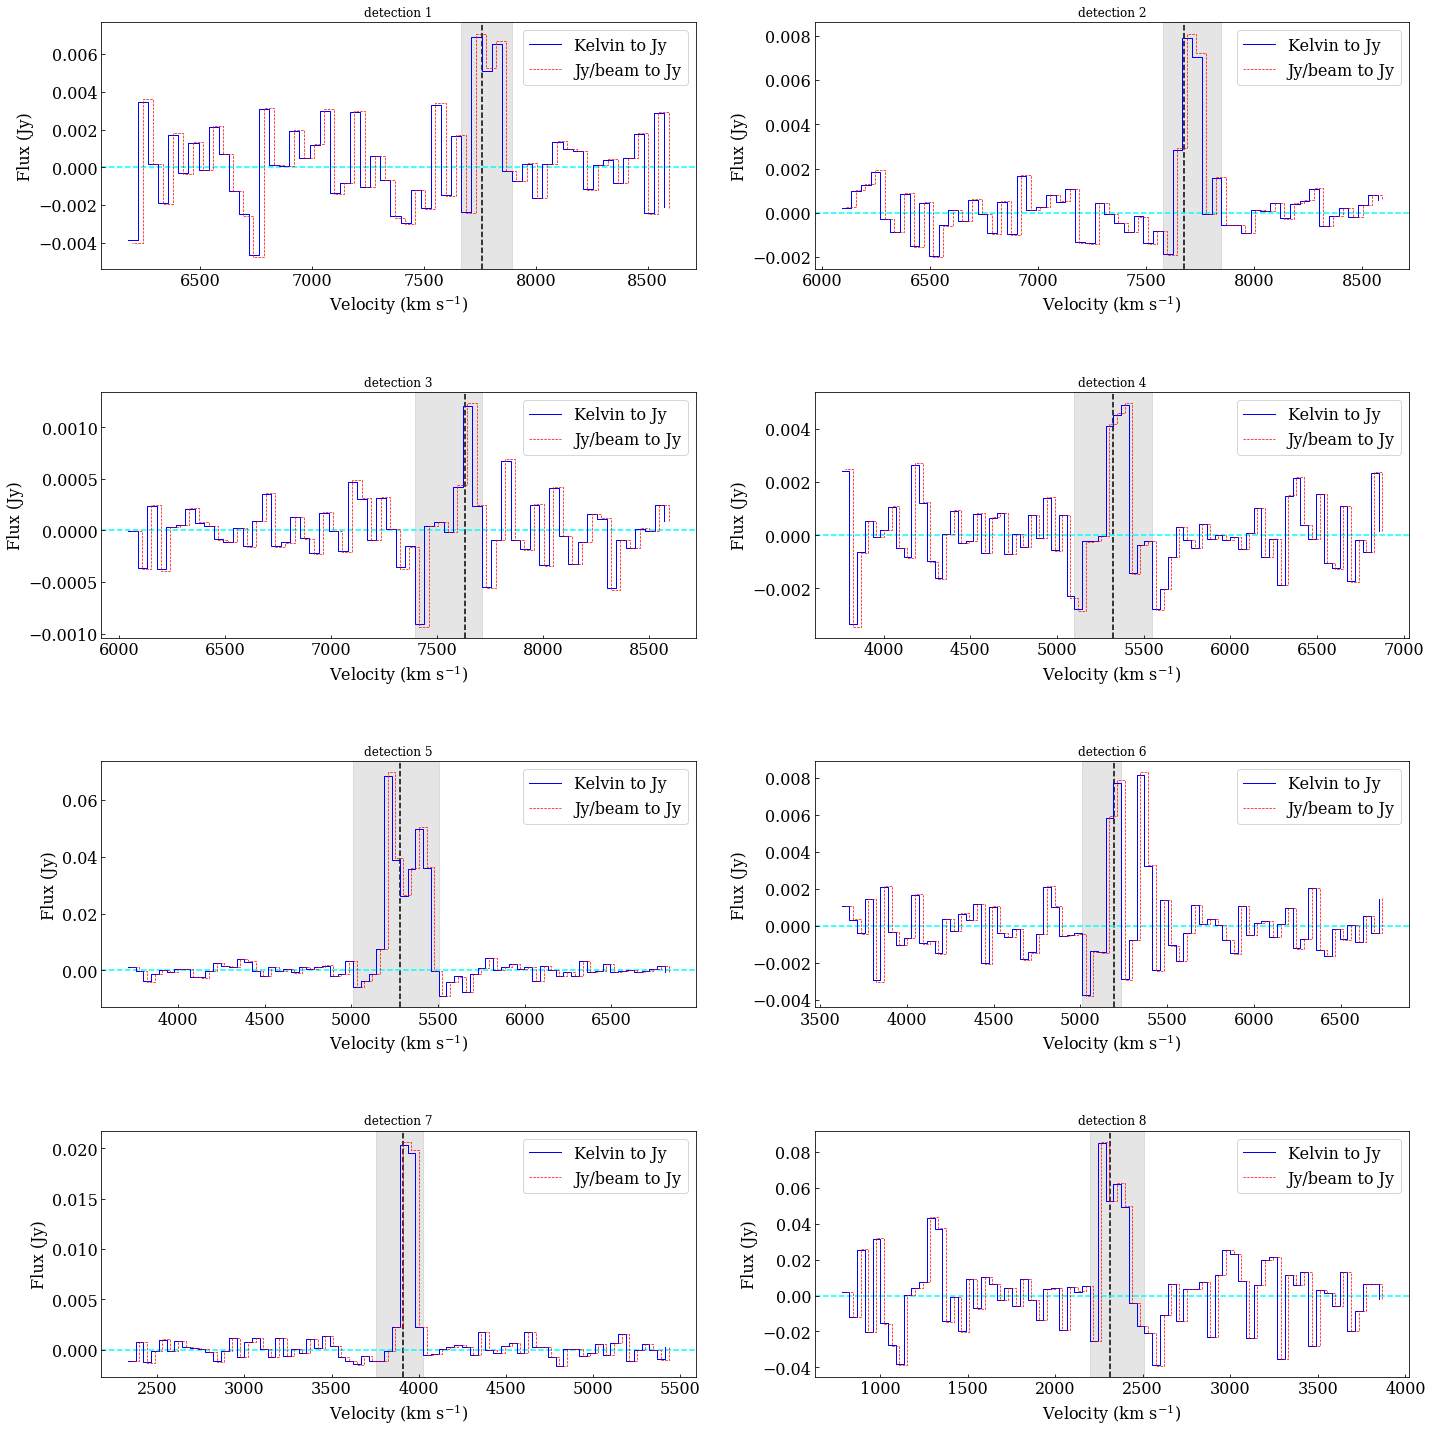

In [32]:
#Baseline fitted fluxes
pl.figure(figsize=(20,20))
for i in range(len(detections)):
    pl.subplot(4,2,i+1)
    pl.step(vel[i].value, S_fit2[i],'b',linewidth=1,label='Kelvin to Jy')
    pl.step(vel[i].value+20, flux_fit[i],'r--',linewidth=0.7,label='Jy/beam to Jy') #shifted in velocity
    pl.axvline(x=central_vel[i], color='k', zorder=1,linestyle='--')
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(i+1))
    pl.xlabel('Velocity (km $\mathrm{s^{-1}}$)')
    pl.ylabel('Flux (Jy)')
    pl.tight_layout()
    ax = pl.gca()
    ax.axvspan(vel[i][index_a[i]].value, vel[i][index_b[i]].value, alpha=0.2, color='grey')
    
    pl.legend(fontsize=16,loc="best")
pl.subplots_adjust(hspace=0.5,wspace=0.2)
#pl.savefig('raw_spectrum_.png',overwrite=True)

As we can see they are almost the same but the flux from Jy/beam to Jy is slightly higher by ~ 2% due to certain approximations

### 8.4 Cube masking

#### Step 1: Convolving into a circular beam cube and get the mean rms from noise cubes

In [33]:
def beam_convolution_and_mean_rms(cube,noise_cube,beam,detections_list):
    '''
    Cube to be convolved
    Detections list
    '''
    convolved_cube = []
    convolved_noise_cube = []
    mean_rms = []
    # Loop through each detections
    for i in range(len(detections_list)):
        
        convolved_cube.append(cube[i].convolve_to(beam))
        convolved_noise_cube.append(noise_cube[i].convolve_to(beam))
        x = convolved_noise_cube[i].std(axis=(1,2))/convolved_noise_cube[i].unit #getting the std for each channel
        mean_rms.append(np.mean(x.value)) #std then mean std
    '''
    mean_rms = mean of the standard deviation of the flux in each channel
    '''
    return convolved_cube, mean_rms

In [34]:
circular_beam_axis = 20
circular_beam = Beam(major=circular_beam_axis*u.arcsec, minor=circular_beam_axis*u.arcsec, 
                   pa=0*u.deg)
smoothed_cube, mean_rms_circ = beam_convolution_and_mean_rms(vel_subcube, noisecube, circular_beam, detections)

In [35]:
#mean_rms_circ[5] = mean_rms_circ[4] #changing the rms of detection 6 to be the same as its main galaxy, detection 6 is a companion of detection 5

#### Step 2: Masking the common beam cube with the smoothed cube with x sigma threshold

The choice of the sigma level is decisive for the results.

<p style="color:red;">That method is still uncertain, so I have decided to mask the common beam cube with itself, not the smoothed cube.</p>

In [174]:
masked_cube = []
#sigma = [2.6,5,3,3,10,7.8,7,2]
sigma = [2.6,3,2.6,2.6,3.8,4.3,2.8,1.5]
for i in range(len(detections)):
    masked_cube.append(vel_subcube[i].with_mask(vel_subcube[i] > sigma[i]*mean_rms[i]*vel_subcube[i].unit))

#### Step 3: Getting the flux density from the masked cube

In [175]:
flux_masked = Jy_beam_to_Jy(masked_cube) #not baseline corrected

In [176]:
#Get the masked flux corrected from baseline correction
flux_masked_fit = []
for i in range(len(detections)):
    x = []
    for j in range(len(flux_masked[i])):
        if j < index_a[i]:
            x.append(flux_masked[i][j])
        elif j > index_b[i]:
            x.append(flux_masked[i][j])
        else:
            g = 0
            if flux_masked[i][j] == 0:
                x.append(0)
            else:
                x.append(flux_masked[i][j] - (new_model[i][g]*scale_factor_common(vel_subcube[i]))) #subtract the baseline
            g+=1
    flux_masked_fit.append(x)

### Global profile

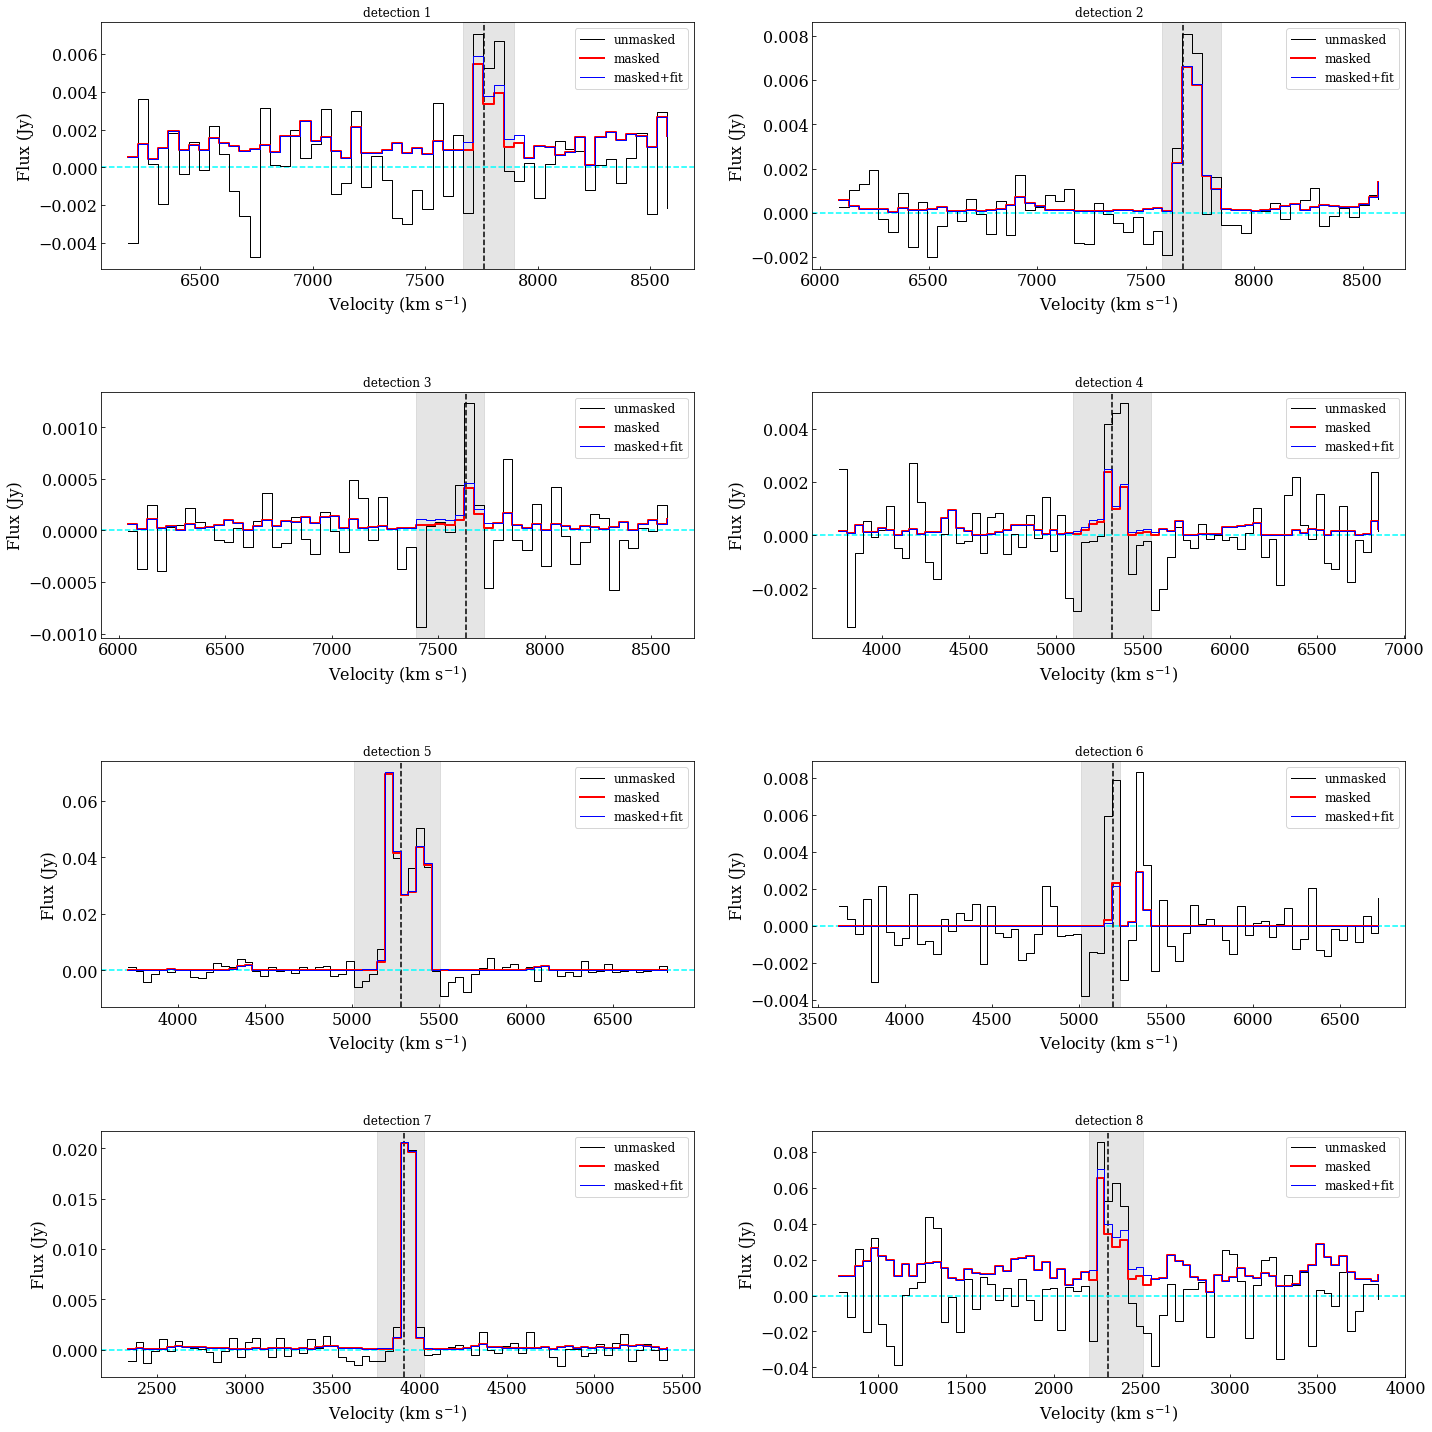

In [177]:
#Baseline fitted fluxes
pl.figure(figsize=(20,20))
for i in range(len(detections)):
    pl.subplot(4,2,i+1)
    pl.step(vel[i].value, flux_fit[i],'k',linewidth=1,label='unmasked')
    pl.step(vel[i].value, flux_masked[i],'r',linewidth=2,label='masked')
    pl.step(vel[i].value, flux_masked_fit[i],'b',linewidth=1,label='masked+fit')
    pl.axvline(x=central_vel[i], color='k', zorder=1,linestyle='--')
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(i+1))
    pl.xlabel('Velocity (km $\mathrm{s^{-1}}$)')
    pl.ylabel('Flux (Jy)')
    pl.tight_layout()
    ax = pl.gca()
    ax.axvspan(vel[i][index_a[i]].value, vel[i][index_b[i]].value, alpha=0.2, color='grey')
    
    pl.legend(fontsize=12,loc="best")
pl.subplots_adjust(hspace=0.5,wspace=0.2)
#pl.savefig('raw_spectrum_.png',overwrite=True)

## Relation between peak flux and rms

In [40]:
S_peak = []
for i in range(len(detections)):
    S_peak.append(np.max(flux_fit[i][index_a[i]:index_b[i]+1]))

In [42]:
S_peak #Peak flux of the unmasked cubes in Jy

[0.007071807193983425,
 0.008099029855840429,
 0.0012346024833589625,
 0.004982649177807766,
 0.06968288930076448,
 0.007873379524184917,
 0.02065490897558407,
 0.08546672910983415]

In [44]:
#Converting the rms to mJy
mean_rms_mJy = [mean_rms[i]*u.Jy.to(u.mJy) for i in range(len(detections))]
mean_mf = np.mean(mean_rms_mJy)
median_mf = np.median(mean_rms_mJy)

In [45]:
I = {'Peak flux (mJy)': [str(round(S_peak[i]*1e3,2)) for i in range(len(detections))],
     'rms common cube (mJy)': [str(round(mean_rms_mJy[i].value,2)) for i in range(len(detections))],
     'rms smoothed cube (mJy)': [str(round(mean_rms_circ[i]*1e3,2)) for i in range(len(detections))],
     'sigma masking': [str(sigma[i]) for i in range(len(detections))]
    }


df = pd.DataFrame(I, columns = ['Peak flux (mJy)','rms common cube (mJy)','rms smoothed cube (mJy)','sigma masking'])

# create output widgets
widget1 = widgets.Output()

# render in output widgets
with widget1:
    display.display(df)


# create HBox
hbox = widgets.HBox([widget1])

# render hbox
print('Relation peak flux and rms for understanding masking')
print('mask = smoothed cube > sigma*rms smoothed cube')
hbox

Relation peak flux and rms for understanding masking
mask = smoothed cube > sigma*rms smoothed cube


### Channel width calculation

In [46]:
chan_width = [] #channel width or spectral resolution, changing depending on the observed frequency
for i in range(len(detections)):
    width = [] # we reinitialize the width because i changes
    for j in range(len(vel[i].value)-1): 
        width.append(vel[i][j].value - vel[i][j+1].value)
        #the v[i]<v[i+1] since the velocity is inverted but it does not matter
    chan_width.append(np.mean(width)*u.km/u.s)

### Get the correction factor for the integrated flux when masking

This is needed if we only want to convert the integrated flux from unmasked to masked

In [48]:
correction_factor = [] #integrated flux for the baseline correction
for i in range(len(detections)):
    correction_factor.append(np.sum(new_model[i])*chan_width[i].value*scale_factor_common(vel_subcube[i]))
correction_factor

[-0.10206844677974652,
 -0.00910328059120932,
 -0.01652966097129157,
 -0.0652655422446459,
 -0.2242151262157706,
 0.0514183589329074,
 -0.02020680960318379,
 -1.5853486553816813]

# 9. Propagation of errors
Basic rules at: https://courses.washington.edu/phys431/propagation_errors_UCh.pdf

In order to estimate the error in the calculations, the **law of propagation of uncertainty** will be used.

There are three basic rules. For a function $f(x,y)$ where $x$ and $y$ have independent random errors, then the error in $f = x + y$ is:

\begin{align}
\bbox[10px, border:1px solid black]{\delta{f} = \sqrt{\delta{x}^2 + \delta{y}^2}} \tag{1}
\end{align}

If $f = x \times y$, by taking logarithms:
\begin{align}
f = x \times y, \\
\text{log } f = \text{log } x + \text{log } y, \\
\delta{\text{ log } f} = \sqrt{(\delta{\text{ log } x})^2 + (\delta{\text{ log } y})^2}, \\
\bbox[10px, border:1px solid black]{\frac{\delta{f}}{f} = \sqrt{\left(\frac{\delta{x}}{x}\right)^2 + \left(\frac{\delta{y}}{y}\right)^2}} \tag{2}
\end{align}

If $f= g(x)$, then:
\begin{align}
\bbox[10px, border:1px solid black]{\delta{f} = |g'(x)|\delta{x}} \tag{3}
\end{align}

The general formula that can be used to calculate the uncertainty for a function $f(x_1,\dots,x_n)$:
\begin{align}
\bbox[#F0F0F0, 10px, border:1px solid black]{\delta{f} =\sqrt{\sum_{i=1}^n \left( \delta{x_i} \frac{\partial f}{\partial x_i} \right)^2}} \tag{4}
\end{align}

By applying equation $(4)$, we obtain the uncertainty of the flux density, the velocity, the distance, the redshift, the integrated flux and the HI mass.

## 9.1 Error in flux densities

To find the error in the sum of flux I(Jy/beam) $\delta I$, we need to calculate the rms/standard deviation of I outside the emission i.e in the previous predefined mask. Another method is to calculate the std of the sum of flux in the NOISE CUBES since these ones were generated for noise measurement.

When converting from Jy/beam to Jy, the scale factor is in function of the beams and the pixel sizes which do not have errors.
After getting the errors from the fluxes in Jy/beam, the error in the flux conversion in Jy $\delta$flux is:

$$\begin{align}
\text{flux [Jy]} = I \text{[Jy/beam]} \times \text{Scale factor} \Rightarrow \bbox[10px, border:1px solid black]{\delta \text{ flux = Scale factor} \times \delta I}
\end{align}$$

Another formula can also be used:

$$\begin{align}
\delta \text{ flux} =  \text{ flux} \sqrt{\left( \frac{\delta I}{I} \right)^2} \Rightarrow \bbox[10px, border:1px solid black]{\delta \text{ flux = flux} \times \frac {\delta I}{I}}
\end{align}$$

The errors are mostly the same, baseline fitted or not

In [49]:
def flux_error(subcube, flux_Jy, flux_Jy_beam, mask):
    '''
    This function calculates the error in the sum of flux in Jy and Jy/beam from the signal cube.
    We therefore need to initiate a mask to avoid the emission region
    flux_scaled = flux in Jy/beam or kelvin scaled with the scale factor
    '''
    
    error = [] # Error in Jy/beam
    flux_err = [] #Error in Jy
    flux_err2 = []

    # Loop through each detection
    for i in range(len(subcube)):
        error.append(np.std(flux_Jy_beam[i][mask[i]]).value)
        flux_err.append(scale_factor_common(subcube[i])*error[i]) #for Jy
        flux_err2.append(np.std(flux_Jy[i][mask[i]])) #directly from the flux in Jy, it is the same as flux_err
    return error, flux_err, flux_err2

In [50]:
def flux_error_noisecube(noisecube):
    '''
    This function calculates the error in the sum of flux in Jy and Jy/beam
    from the noisecubes. The errors will therefore be the same baseline fitted or not, no mask needed.
    '''
    
    error = [] # Error in Jy/beam
    flux_err = [] #Error in Jy

    # Loop through each detection
    for i in range(len(noisecube)):
        # List to store error for detection i
        error.append(np.std(noisecube[i].sum(axis=(1,2))).value) #for Jy/beam
        flux_err.append(scale_factor_common(noisecube[i])*error[i])
    return error, flux_err

In [51]:
#Converting into array:
S_1 = [np.array(S_1[i]) for i in range(len(detections))]
S_fit2 = [np.array(S_fit2[i]) for i in range(len(detections))]
T_b_fit = [np.array(T_b_fit[i]) for i in range(len(detections))]

In [52]:
#Errors from direct method baseline and non baseline fitted
err, flux_err, _ = flux_error(subcube, flux, tsum_convolved, mask)
err2, flux_err2, _ = flux_error(subcube, flux_fit, contsub_flux, mask)

#Errors from Jy/beam to Kelvin and to Jy baseline and non baseline fitted (same as direct method)
_, _, flux_direct_err3 = flux_error(subcube, S_1, tsum_convolved, mask)
_, _, flux_direct_err4 = flux_error(subcube, S_fit2, contsub_flux, mask)

#Errors from Jy/beam to Kelvin
err_K, Tb_err, _ = flux_error(kcube, T_b, T_b_beam, mask)
err_K2, _, Tb_direct_err2 = flux_error(kcube, T_b_fit, T_b_beam, mask)

In [53]:
##############################################################################################
#Errors from noise cubes, direct method baseline and non baseline fitted
nerr, flux_nerr = flux_error_noisecube(noisecube)

#Errors from noise cubes from Jy/beam to Kelvin
nerr_K, Tb_nerr = flux_error_noisecube(knoisecube)

## 9.3 Error in velocity, distance and redshift

The uncertainty in frequency $\delta \nu$ is the channel width in frequency which is constant, rather than using the channel width in velocity which is varying as a function of redshift. 
\begin{align}
{V = \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c}  \Rightarrow \bbox[10px, border:1px solid black]{\delta V = \frac{4c \nu_0^2 \nu}{(\nu_0^2 + \nu^2)^2} \times \delta \nu} \\
z = \frac{\nu_0}{\nu} - 1 \Rightarrow \bbox[10px, border:1px solid black]{\delta z = \frac{\nu_0}{\nu^2} \times \delta \nu} \\
D = \frac{v}{H_0} \Rightarrow \bbox[10px, border:1px solid black]{\delta D = D \sqrt{\left( \frac{\delta V}{V}\right)^2 + \left( \frac{\delta H_0}{H_0}\right)^2}}
\end{align}

$V$ is the systemic velocity calculated from the central frequency, and $H_0 = 67.4 \pm 0.54$ km s$^{-1}$ Mpc$^{-1}$

In [54]:
dnu = subcube[0].header['CDELT3']*u.Hz.to(u.GHz) #channel width in frequency, delta_nu
#Uncertainty in Velocity
nu_0 = 1.42040575 #21 cm
c = const.c.to(u.km/u.s).value
H0_err = 0.54
V_err = [dnu*4*c*(nu_0**2)*central_freq[i]/pow(nu_0**2 + central_freq[i]**2,2) for i in range(len(detections))]

#Uncertainty in redshift
z_err = [dnu*nu_0/central_freq[i]**2 for i in range(len(detections))]

# Calculate the uncertainty in D
D_err = [hubble_D[i]*np.sqrt(pow(V_err[i]/central_vel[i],2) + pow(H0_err/cosmo.H0.value,2)) for i in range(len(detections))]

### 9.4 Distance from the cube center and details of the detections

In [55]:
central_ra = C1380_mf_pb.header['CRVAL1']
central_dec = C1380_mf_pb.header['CRVAL2']

ra_deg = []
dec_deg = []
coord = []
separation = []
for i in range(len(detections)):
    ra = detections[i]['ra'] #taking the RA column but string
    dec = detections[i]['dec']
    coord.append(SkyCoord(ra*u.deg, dec*u.deg, frame='fk5'))
    coord_center = SkyCoord(central_ra*u.deg, central_dec*u.deg, frame='fk5')
    ra_deg.append(coord[i].ra.deg)
    dec_deg.append(coord[i].dec.deg)
    #need to use spherical formula of Pythagora
    separation.append(coord_center.separation(coord[i]))

In [56]:
I = {'RA (deg)': [str(round(detections[i]['ra'],2)) for i in range(len(detections))],
     'DEC (deg)': [str(round(detections[i]['dec'],2)) for i in range(len(detections))],
     'd_c (deg)': [str(round(separation[i].value,2)) for i in range(len(detections))],
     'Freq (GHz)': [str(round(central_freq[i],4)) for i in range(len(detections))],
     'V_sys (km/s)': [str(round(central_vel[i],2))+'+/-'+str(round(V_err[i],2)) for i in range(len(detections))],
     'Redshift': [str(round(redshift[i], 4))+'+/-'+str(round(z_err[i], 6)) for i in range(len(detections))],
     'Distance (Mpc)': [str(round(hubble_D[i], 2))+'+/-'+str(round(D_err[i], 2)) for i in range(len(detections))]
    
    }


df = pd.DataFrame(I, columns = ['RA (deg)','DEC (deg)','d_c (deg)','Freq (GHz)','V_sys (km/s)', 'Redshift', 'Distance (Mpc)'])

# create output widgets
widget1 = widgets.Output()

# render in output widgets
with widget1:
    display.display(df)


# create HBox
hbox = widgets.HBox([widget1])

# render hbox
print('Detection details, d_c = distance from cube center')
hbox

Detection details, d_c = distance from cube center


***
# 10. HI masses

#### Method 1: HI mass from the flux density
For an extragalactic HI beyond the local Universe, we will need a factor $(1+z)$ or $(1+z)^2$ to be added to the formula (Giovanelli and Haynes 2015, Meyer et al. 2017) depending on the velocity convention. Since we are using the relativistic velocity:

\begin{equation} \bbox[#F0F0F0, 10px, border:1px solid black]{\frac{M_{\rm H\,I}}{M_{\odot}} \approx \frac{2.35 \times 10^5}{(1+z)^2} \times \frac{S_{\rm int}}{\mathrm{Jy \, km \, s}^{-1}} \times \left( \frac{D}{\mathrm{Mpc}} \right)^{\!2}} \end{equation}

Where $S_{int}$ is the integrated flux in Jy km/s or the flux density multiplied by the channel width.

#### Method 2: HI mass from the brightness temperature
By using the definition of the brightness temperature from equation (69) in Meyer et al. 2017, we obtain:

\begin{equation} \bbox[#F0F0F0, 10px, border:1px solid black]{\frac{M_{\rm H\,I}}{M_{\odot}} \approx 0.388 \times \frac{\theta_{\rm{maj}}\theta_{\rm{min}}}{(1+z)^5} \left( \frac{D}{\mathrm{Mpc}} \right)^{\!2} \int \frac{T_{\rm B}(v)}{\rm K}\frac{dv}{\mathrm{ km \, s}^{-1}}} \end{equation}

We only need to calculate the HI mass of the detection and not the whole spectrum, which are already defined by the velocity limits.

#### Method 3: HI mass from the Moment 0 map after masking.
To do this, we need to:
* Smooth the common beam subcubes into a 20 arcsec circular beam
* Mask the common beam subcubes with the smoothed cube
* Masked cube obtained. We can therefore calculate the HI mass with the direct method again, or get the mom 0 map of the masked cube, sum all the pixels to get the integrated flux, then calculate the mass from the method 1 formula.

With this third method, the threshold for masking is very important especially when calculating the integrated flux from the moment 0 map. If not masked well, the direct calculation will only takes the fluxes within the emission region which is fine. But for the mom 0 method, it will even sum up pixels outside the emission if not masked. That is why the HI masses value obtained from the moment 0 are slightly higher. We also cannot calculate the errors due to masking, so we will just use the errors obtained from method 1

***

## 10.1 Error in Integrated fluxes and HI masses

### Error in integrated flux
* A/ $$\bbox[10px, border:1px solid black]{\text{error integrated flux = std flux off emission} \times \sqrt{\text{total channel number}} \times \text{channel width}}$$


* B/ Using the **law of propagation of uncertainty** 
If $i$ corresponds to the channel i:
\begin{align}
S_{\text{int}} \text{ [Jy km s}^{-1}] = \sum_{i=1}^n \text{flux}_i \text{ dv}_i
\end{align}
Since the channel width $dv$ does not have errors,
\begin{align}
\bbox[10px, border:1px solid black]{\delta S_{\text{int}} = \sqrt{\sum_{i=1}^n \left( \delta \text{ flux}_i \times \text{ dv}_i \right)^2}}
\end{align}
The same formula is used for the integrated temperature and then will be converted into integrated flux for the HI mass error calculation

### Error in HI mass and log HI mass

The error in HI mass is just obtained by changing the integrated flux by its error (if we neglect the distance and redshift errors). However, if we include them, the HI mass error is:
\begin{align}
\bbox[10px, border:1px solid black]{\delta M_{\text{HI}} = M_{\text{HI}} \sqrt{\left( \frac{-2 \delta z}{1+z}\right)^2 + \left( \frac{\delta S_{\text{int}}}{S_{\text{int}}}\right)^2 + \left( \frac{2 \delta D}{D}\right)^2}}
\end{align}

And the log HI mass error:
\begin{align}
\bbox[10px, border:1px solid black]{\delta \text{ log }M_{\text{HI}} = 0.434 \times \frac{\delta M_{\text{HI}}}{M_{\text{HI}}}}
\end{align}
https://faculty.washington.edu/stuve/log_error.pdf

### Method 1 A and B uncertainty estimation:

The HI mass values are the same but only the errors are different

In [57]:
def hi_mass_from_flux(flux, velocity, hubble_D, redshift, index_lower, index_upper,chan_width):
    '''
    index_lower is the index list of lower limits for each profile
    index_upper is the index list of upper limits for each profile
    mean_dv = mean channel width
    '''

    
    HI_mass = [] # List to store Mh for each detection
    integrated_flux = []
    logM = []

    Int_Flux_error = []
    mass_err = []
    log10_err = []
    
    # Loop through each data cube
    for i in range(len(detections)):
        
        Sdv = 0 # Initialise line flux
                
        # Loop through data in each cube to calculate the line flux
        for j in range(index_lower[i], index_upper[i]+1):
            # Velocity width
            dv = velocity[i][j] - velocity[i][j+1] #if the subcube spectral_axis is in velocity
            
            # Calculate the integral
            Sdv += flux[i][j]*(dv.value)
        
        #Integrated flux
        integrated_flux.append(Sdv*u.Jy*u.km/u.s)
        # Calculate the error in the line flux 
        # Flux from off-emission channels
        Jy_off = np.array(flux[i][0:index_lower[i]].tolist() + flux[i][index_upper[i]:-1].tolist())
        #Jy_off = np.mean(flux_err[0][mask[0]])#mean of flux error
        Int_Flux_error.append(np.std(Jy_off)*np.sqrt(len(flux[i]))*chan_width[i].value)
        
        
        # Calculate the HI mass for this current detection
        #M = (2.356*(10**5))*hubble_D[i].value**2*Sdv.value/(1+redshift[i])
        M_1_z_square = (2.356*(10**5))*hubble_D[i]**2*Sdv/((1+redshift[i])**2) #relativistic
        logM.append(np.log10(M_1_z_square))
        HI_mass.append(M_1_z_square)
        
        #MASS ERRORS
        mass_err.append((2.356*(10**5))*hubble_D[i]**2*Int_Flux_error[i]/((1+redshift[i])**2))
        log10_err.append(0.434*mass_err[i]/M_1_z_square)
        
        
    return integrated_flux, HI_mass, logM, np.abs(Int_Flux_error), np.abs(mass_err),np.abs(log10_err)

In [58]:
def hi_mass_from_flux_err(flux, flux_err, velocity, hubble_D, D_err, redshift, z_err, index_lower, index_upper):
    '''
    index_lower is the index list of lower limits for each profile
    index_upper is the index list of upper limits for each profile
    mean_dv = mean channel width
    '''

    
    HI_mass = [] # List to store Mh for each detection
    integrated_flux = []
    logM = []

    Int_Flux_error = []
    mass_err = []
    log10_err = []
    
    # Loop through each data cube
    for i in range(len(detections)):
        
        Sdv = 0 # Initialise line flux
        int_dv_err = 0 #initialise error in integrated flux
                
        # Loop through data in each cube to calculate the line flux
        for j in range(index_lower[i], index_upper[i]+1):
            # Velocity width
            dv = velocity[i][j] - velocity[i][j+1] #if the subcube spectral_axis is in velocity
            
            # Calculate the integral
            Sdv += flux[i][j]*(dv.value)
        
        for x in range(len(detections[i])+1):
            chan = velocity[i][x] - velocity[i][x+1]
            int_dv_err += (flux_err[i]*chan.value)**2
    
        
        #Integrated flux
        integrated_flux.append(Sdv*u.Jy*u.km/u.s)
        # Calculate the error in the line flux 
        Int_Flux_error.append(np.sqrt(int_dv_err))
        
        
        # Calculate the HI mass for this current detection
        #M = (2.356*(10**5))*hubble_D[i].value**2*Sdv.value/(1+redshift[i])
        M_1_z_square = (2.356*(10**5))*hubble_D[i]**2*Sdv/((1+redshift[i])**2) #relativistic
        logM.append(np.log10(M_1_z_square))
        HI_mass.append(M_1_z_square)
        
        #MASS ERRORS
        #mass_err.append((2.356*(10**5))*hubble_D[i]**2*Int_Flux_error[i]/((1+redshift[i])**2))
        mass_err.append(M_1_z_square*np.sqrt(pow(-2*z_err[i]/(1+redshift[i]),2)+pow(Int_Flux_error[i]/Sdv,2)+pow(2*D_err[i]/hubble_D[i],2)))
        log10_err.append(0.434*mass_err[i]/M_1_z_square)
        
        
    return integrated_flux, HI_mass, logM, np.abs(Int_Flux_error), np.abs(mass_err),np.abs(log10_err)

### Method 2 A and B uncertainty estimation

In [59]:
def hi_mass_from_TB(subcube, T_b, velocity, hubble_D, redshift, index_lower, index_upper,chan_width):
    '''
    index_lower is the index list of lower limits for each profile
    index_upper is the index list of upper limits for each profile
    mean_dv = mean channel width
    '''

    HI_mass = [] # List to store Mh for each detection
    integrated_flux = []
    logM = []

    Int_Flux_error = []
    K_error = []
    mass_err = []
    log10_err = []
    
    nu_0 = 1.42040575e9
    
    # Loop through each data cube
    for i in range(len(detections)):
        
        # BEAM VALUES
        try:
            bmaj = subcube[i].beams[j].major.to(u.arcsec).value #beam values for each channel if mutli beam
            bmin = subcube[i].beams[j].minor.to(u.arcsec).value
        except Exception:
            bmaj = subcube[i].beam.major.to(u.arcsec).value #beam values for each channel if mutli beam
            bmin = subcube[i].beam.minor.to(u.arcsec).value
        
        Tdv = 0 # Initialise line flux
    
        # Loop through data in each cube to calculate the line flux
        for j in range(index_lower[i], index_upper[i]+1):
            # Velocity width
            dv = velocity[i][j] - velocity[i][j+1] #if the subcube spectral_axis is in velocity
            
            Tdv += T_b[i][j]* dv.value
        
        #Integrated temperature
        integrated_flux.append(Tdv*u.K*u.km/u.s)
        
        # Calculate the error in the line flux 
        # Error from off-emission channels and then their mean
        K_off = np.array(T_b[i][0:index_lower[i]].tolist() + T_b[i][index_upper[i]:-1].tolist())
        K_error.append(np.std(K_off)*np.sqrt(len(T_b[i]))*chan_width[i].value) #in Kelvin
        
        #Error from Kelvin into Jy
        constant = (np.pi*const.k_B.value*(nu_0**2))/(2*np.log(2)*(const.c.value**2))
        constant2 = constant/pow(1*u.rad.to(u.arcsecond),2) #conversion from radians to arcsecond
        flux = constant2*bmaj*bmin*K_error[i]/pow((1+redshift[i]),3)
            
        Int_Flux_error.append(pow(10,26)*flux)
        
        
        # Calculate the HI mass for this current detection
        M_1_z_square = 0.388*bmaj*bmin*(hubble_D[i]**2/(1+redshift[i])**5)*Tdv
        logM.append(np.log10(M_1_z_square))
        HI_mass.append(M_1_z_square)
        
        #MASS ERRORS
        mass_err.append((2.356*(10**5))*hubble_D[i]**2*Int_Flux_error[i]/((1+redshift[i])**2))
        log10_err.append(0.434*mass_err[i]/M_1_z_square)
        
        
    return integrated_flux, HI_mass, logM, np.abs(K_error), np.abs(mass_err),np.abs(log10_err)

In [60]:
def hi_mass_from_TB_err(subcube, T_b, T_b_err, velocity, hubble_D, D_err, redshift, z_err, index_lower, index_upper):
    '''
    index_lower is the index list of lower limits for each profile
    index_upper is the index list of upper limits for each profile
    mean_dv = mean channel width
    '''

    HI_mass = [] # List to store Mh for each detection
    integrated_flux = []
    logM = []

    Int_Flux_error = []
    K_error = []
    mass_err = []
    log10_err = []
    nu_0 = 1.42040575e9
    
    # Loop through each data cube
    for i in range(len(detections)):
        
        # BEAM VALUES
        try:
            bmaj = subcube[i].beams[j].major.to(u.arcsec).value #beam values for each channel if mutli beam
            bmin = subcube[i].beams[j].minor.to(u.arcsec).value
        except Exception:
            bmaj = subcube[i].beam.major.to(u.arcsec).value #beam values for each channel if mutli beam
            bmin = subcube[i].beam.minor.to(u.arcsec).value
        
        Tdv = 0 # Initialise line flux
        int_dv_err = 0
    
        # Loop through data in each cube to calculate the line flux
        for j in range(index_lower[i], index_upper[i]+1):
            # Velocity width
            dv = velocity[i][j] - velocity[i][j+1] #if the subcube spectral_axis is in velocity
            
            Tdv += T_b[i][j]* dv.value
        
        for x in range(len(detections[i])+1):
            chan = velocity[i][x] - velocity[i][x+1]
            int_dv_err += (T_b_err[i]*chan.value)**2
        
        #Integrated temperature
        integrated_flux.append(Tdv*u.K*u.km/u.s)
        
        K_error.append(np.sqrt(int_dv_err))
        
        #Error from Kelvin into Jy
        constant = (np.pi*const.k_B.value*(nu_0**2))/(2*np.log(2)*(const.c.value**2))
        constant2 = constant/pow(1*u.rad.to(u.arcsecond),2) #conversion from radians to arcsecond
        flux = constant2*bmaj*bmin*K_error[i]/pow((1+redshift[i]),3)
        f2 = constant2*bmaj*bmin*Tdv/pow((1+redshift[i]),3)
            
        Int_Flux_error.append(pow(10,26)*flux)
        int_flux = pow(10,26)*f2
        
        
        # Calculate the HI mass for this current detection
        M_1_z_square = 0.388*bmaj*bmin*(hubble_D[i]**2/(1+redshift[i])**5)*Tdv
        logM.append(np.log10(M_1_z_square))
        HI_mass.append(M_1_z_square)
        
        #MASS ERRORS
        #mass_err.append((2.356*(10**5))*hubble_D[i]**2*Int_Flux_error[i]/((1+redshift[i])**2))
        mass_err.append(M_1_z_square*np.sqrt(pow(-2*z_err[i]/(1+redshift[i]),2)+pow(Int_Flux_error[i]/int_flux,2)+pow(2*D_err[i]/hubble_D[i],2)))
        log10_err.append(0.434*mass_err[i]/M_1_z_square)
        
        
    return integrated_flux, HI_mass, logM, np.abs(K_error), np.abs(mass_err),np.abs(log10_err)

### Method 3 Moment 0

In [166]:
def hi_mass_from_flux_masked(flux, correction_factor, velocity, hubble_D, redshift, index_lower, index_upper,chan_width):
    '''
    index_lower is the index list of lower limits for each profile
    index_upper is the index list of upper limits for each profile
    mean_dv = mean channel width
    '''

    
    HI_mass = [] # List to store Mh for each detection
    integrated_flux = []
    logM = []

    Int_Flux_error = []
    mass_err = []
    log10_err = []
    
    # Loop through each data cube
    for i in range(len(detections)):
        
        Sdv = 0 # Initialise line flux
                
        # Loop through data in each cube to calculate the line flux
        for j in range(index_lower[i], index_upper[i]+1):
            # Velocity width
            dv = velocity[i][j] - velocity[i][j+1] #if the subcube spectral_axis is in velocity
            
            # Calculate the integral
            Sdv += flux[i][j]*(dv.value)
            
        Sdv += correction_factor[i]
        
        #Integrated flux
        integrated_flux.append(Sdv*u.Jy*u.km/u.s)
        # Calculate the error in the line flux 
        # Flux from off-emission channels
        Jy_off = np.array(flux[i][0:index_lower[i]].tolist() + flux[i][index_upper[i]:-1].tolist())
        #Jy_off = np.mean(flux_err[0][mask[0]])#mean of flux error
        Int_Flux_error.append(np.std(Jy_off)*np.sqrt(len(flux[i]))*chan_width[i].value)
        
        
        # Calculate the HI mass for this current detection
        #M = (2.356*(10**5))*hubble_D[i].value**2*Sdv.value/(1+redshift[i])
        M_1_z_square = (2.356*(10**5))*hubble_D[i]**2*Sdv/((1+redshift[i])**2) #relativistic
        logM.append(np.log10(M_1_z_square))
        HI_mass.append(M_1_z_square)
        
        #MASS ERRORS
        mass_err.append((2.356*(10**5))*hubble_D[i]**2*Int_Flux_error[i]/((1+redshift[i])**2))
        log10_err.append(0.434*mass_err[i]/M_1_z_square)
        
        
    return integrated_flux, HI_mass, logM, np.abs(Int_Flux_error), np.abs(mass_err),np.abs(log10_err)

In [165]:
def hi_mass_from_mom0(masked_cube, correction_factor, hubble_D, redshift,name='moment 0'):
    '''
    Only available for masked cube with spectral axis velocity
    '''
    HI_mass = [] # List to store Mh for each detection
    integrated_flux = []
    logM = []

    int_flux_err = []
    mass_err = []
    log10_err = []
    
    #Moment map
    moment_0 = []
    
    for i in range(len(detections)):
        detection_mom0 = masked_cube[i].moment(order=0)

        #Integrated flux: sum of the finite values in the emission in Jy/beam km/s
        mom0 = np.sum(detection_mom0[np.isfinite(detection_mom0)], axis=0) 

        #Integrated flux in Jy km/s
        #mom0 = np.nan_to_num(mom0) #put nan values to be zeros
        detection_integrated_flux = mom0 * scale_factor_common(masked_cube[i]) *u.beam
        
        #moment 0 map in fits
        moment_0.append(np.nan_to_num(detection_mom0) * scale_factor_common(masked_cube[i]) *u.beam)
        #moment_0[i].write(name+'_Jy_km_s.fits',format='fits',overwrite='True')


        #Integrated flux error:
        detection_integrated_flux += (correction_factor[i]*detection_integrated_flux.unit)
        
        integrated_flux.append(detection_integrated_flux)
        #np.nanstd(np.where(np.isclose(moment_0[i].value,0), np.nan, moment_0[i].value))
        int_flux_err.append(np.nanstd(moment_0[i].value)) #standard variation of all the finite pixels,excluding nan and zeros
        
        
        # Calculate the HI mass for this current detection
        M_1_z_square = (2.356*(10**5))*hubble_D[i]**2*detection_integrated_flux.value/((1+redshift[i])**2) #relativistic
        logM.append(np.log10(M_1_z_square))
        HI_mass.append(M_1_z_square)
        
        #MASS ERRORS
        mass_err.append((2.356*(10**5))*hubble_D[i]**2*int_flux_err[i]/((1+redshift[i])**2))
        log10_err.append(0.434*mass_err[i]/M_1_z_square)
    

    return integrated_flux, HI_mass, logM, np.abs(int_flux_err), np.abs(mass_err),np.abs(log10_err), moment_0

# HI mass results

### Direct method unmasked cubes, baseline fitted fluxes uncertainty A and B

In [63]:
integrated_flux, HI_mass, logM, Int_Flux_error, mass_err,log10_err = hi_mass_from_flux(flux_fit, vel, hubble_D, redshift, 
                                                                                       index_a, index_b, chan_width)
_, _, _, Int_Flux_error2, mass_err2,log10_err2 = hi_mass_from_flux_err(flux_fit, flux_err2, vel, hubble_D, D_err, redshift, z_err,
                                                                       index_a, index_b)

In [64]:
print("HI mass direct method baseline fitted, uncertainty type A")
[str(round(logM[i],3))+' +/- '+str(round(log10_err[i], 3)) for i in range(len(detections))]

HI mass direct method baseline fitted, uncertainty type A


['9.351 +/- 0.386',
 '9.386 +/- 0.167',
 '7.864 +/- 1.709',
 '8.576 +/- 0.757',
 '10.208 +/- 0.033',
 '8.425 +/- 1.428',
 '9.187 +/- 0.067',
 '9.353 +/- 0.348']

In [65]:
print("HI mass direct method baseline fitted, uncertainty type B")
[str(round(logM[i],3))+' +/- '+str(round(log10_err2[i], 3)) for i in range(len(detections))]

HI mass direct method baseline fitted, uncertainty type B


['9.351 +/- 0.122',
 '9.386 +/- 0.049',
 '7.864 +/- 0.446',
 '8.576 +/- 0.202',
 '10.208 +/- 0.013',
 '8.425 +/- 0.369',
 '9.187 +/- 0.022',
 '9.353 +/- 0.094']

### If no baseline fitting

In [66]:
integrated_flux_no_fit, HI_mass_no_f, logM_nf, Int_Flux_error_nf, mass_err_nf,log10_err_nf = hi_mass_from_flux(flux, vel, 
                                                                                              hubble_D, redshift, index_a, index_b, chan_width)
_, _, _, Int_Flux_nf2, mass_err_nf2,log10_err_nf2 = hi_mass_from_flux_err(flux, flux_err, vel, hubble_D, D_err, redshift, z_err,
                                                                       index_a, index_b)

In [67]:
print("HI mass direct method baseline NOT fitted, uncertainty type A")
[str(round(logM_nf[i],3))+' +/- '+str(round(log10_err_nf[i], 3)) for i in range(len(detections))]

HI mass direct method baseline NOT fitted, uncertainty type A


['9.283 +/- 0.459',
 '9.381 +/- 0.17',
 '7.353 +/- 5.568',
 '8.446 +/- 1.024',
 '10.199 +/- 0.033',
 '8.53 +/- 1.121',
 '9.183 +/- 0.068',
 '9.259 +/- 0.441']

In [68]:
print("HI mass direct method baseline NOT fitted, uncertainty type B")
[str(round(logM_nf[i],3))+' +/- '+str(round(log10_err_nf2[i], 3)) for i in range(len(detections))]

HI mass direct method baseline NOT fitted, uncertainty type B


['9.283 +/- 0.143',
 '9.381 +/- 0.05',
 '7.353 +/- 1.454',
 '8.446 +/- 0.272',
 '10.199 +/- 0.013',
 '8.53 +/- 0.29',
 '9.183 +/- 0.022',
 '9.259 +/- 0.118']

### Brightness temperature to Jy, baseline fitted

In [69]:
int_tb_flux, HI_tb_flux, logM_tb_flux, int_tb_err_flux, mass_tb_err_flux,log10_tb_err_flux = hi_mass_from_flux(S_fit2, vel, hubble_D, redshift, 
                                                                                                               index_a, index_b, chan_width)
_, _, _, int_tb_err_flux2, mass_tb_err_flux2,log10_tb_err_flux2 = hi_mass_from_flux_err(S_fit2, flux_direct_err4, vel, hubble_D, D_err, redshift, z_err,
                                                                                        index_a, index_b)
print("HI mass direct method baseline fitted, uncertainty type B")
[str(round(logM_tb_flux[i],3))+' +/- '+str(round(log10_tb_err_flux2[i], 3)) for i in range(len(detections))]

HI mass direct method baseline fitted, uncertainty type B


['9.34 +/- 0.121',
 '9.375 +/- 0.048',
 '7.854 +/- 0.445',
 '8.568 +/- 0.201',
 '10.2 +/- 0.013',
 '8.418 +/- 0.369',
 '9.182 +/- 0.022',
 '9.35 +/- 0.093']

### Brightness temperature, baseline fitted

In [70]:
int_tb, HI_tb, logM_tb, int_tb_err, mass_tb_err,log10_tb_err = hi_mass_from_TB(kcube, T_b_fit, vel, hubble_D, redshift, 
                                                                               index_a, index_b, chan_width)
_, _, _, int_tb_err2, mass_tb_err2,log10_tb_err2 = hi_mass_from_TB_err(kcube, T_b_fit, Tb_direct_err2, vel, hubble_D, D_err, redshift, z_err,
                                                                       index_a, index_b)

print("HI mass brightness temperature method baseline fitted, uncertainty type A")
[str(round(logM_tb[i],3))+' +/- '+str(round(log10_tb_err[i], 3)) for i in range(len(detections))]

HI mass brightness temperature method baseline fitted, uncertainty type A


['9.339 +/- 0.386',
 '9.374 +/- 0.167',
 '7.853 +/- 1.708',
 '8.567 +/- 0.758',
 '10.199 +/- 0.033',
 '8.417 +/- 1.43',
 '9.181 +/- 0.067',
 '9.349 +/- 0.348']

In [71]:
print("HI mass brightness temperature method baseline fitted, uncertainty type B")
[str(round(logM_tb[i],3))+' +/- '+str(round(log10_tb_err2[i], 3)) for i in range(len(detections))]

HI mass brightness temperature method baseline fitted, uncertainty type B


['9.339 +/- 0.121',
 '9.374 +/- 0.048',
 '7.853 +/- 0.445',
 '8.567 +/- 0.201',
 '10.199 +/- 0.013',
 '8.417 +/- 0.369',
 '9.181 +/- 0.022',
 '9.349 +/- 0.093']

### If no baseline fitting

In [72]:
int_tb_no_fit, HI_tb_no_f, logM_tb_nf, Int_tb_err_nf, mass_tb_err_nf,log10_tb_err_nf = hi_mass_from_TB(kcube, T_b, vel, hubble_D, redshift, 
                                                                               index_a, index_b, chan_width)
print("HI mass brightness temperature method baseline NOT fitted, uncertainty type A")
[str(round(logM_tb_nf[i],3))+' +/- '+str(round(log10_tb_err_nf[i], 3)) for i in range(len(detections))]

HI mass brightness temperature method baseline NOT fitted, uncertainty type A


['9.271 +/- 0.459',
 '9.369 +/- 0.17',
 '7.343 +/- 5.539',
 '8.438 +/- 1.026',
 '10.19 +/- 0.034',
 '8.521 +/- 1.123',
 '9.176 +/- 0.068',
 '9.254 +/- 0.442']

I realized that the error values for the different methods are almost the same, so let's just keep the errors from the baseline fitted direct method

### Masked cubes direct method and mom0

The mask flux does not have error since the baseline is masked, so we will just use the previous errors

In [178]:
int_mask_flux, HI_mask_flux, logM_mask_flux, _, _, _ = hi_mass_from_flux(flux_masked, vel, hubble_D, redshift, 
                                                                                                               index_a, index_b, chan_width)
print("HI mass direct method masked cube, uncertainty type B (using the errors from the direct method)")
[str(round(logM_mask_flux[i],3))+' +/- '+str(round(log10_err2[i], 3)) for i in range(len(detections))]

HI mass direct method masked cube, uncertainty type B (using the errors from the direct method)


['9.363 +/- 0.122',
 '9.393 +/- 0.049',
 '8.107 +/- 0.446',
 '8.644 +/- 0.202',
 '10.214 +/- 0.013',
 '8.227 +/- 0.369',
 '9.184 +/- 0.022',
 '9.376 +/- 0.094']

In [179]:
int_mask_flux

[<Quantity 0.72813885 Jy km / s>,
 <Quantity 0.79878809 Jy km / s>,
 <Quantity 0.04177789 Jy km / s>,
 <Quantity 0.29676536 Jy km / s>,
 <Quantity 11.20491179 Jy km / s>,
 <Quantity 0.11946249 Jy km / s>,
 <Quantity 1.9126415 Jy km / s>,
 <Quantity 8.55755765 Jy km / s>]

### With baseline correction

In [180]:
int_mask_flux, HI_mask_flux, logM_mask_flux, _, _, _ = hi_mass_from_flux_masked(flux_masked, correction_factor, vel, hubble_D, redshift, 
                                                                                                               index_a, index_b, chan_width)
print("HI mass direct method masked cube, uncertainty type B (using the errors from the direct method)")
[str(round(logM_mask_flux[i],3))+' +/- '+str(round(log10_err2[i], 3)) for i in range(len(detections))]

HI mass direct method masked cube, uncertainty type B (using the errors from the direct method)


['9.297 +/- 0.122',
 '9.388 +/- 0.049',
 '7.888 +/- 0.446',
 '8.536 +/- 0.202',
 '10.205 +/- 0.013',
 '8.383 +/- 0.369',
 '9.179 +/- 0.022',
 '9.287 +/- 0.094']

In [181]:
int_mask_flux

[<Quantity 0.62607041 Jy km / s>,
 <Quantity 0.78968481 Jy km / s>,
 <Quantity 0.02524822 Jy km / s>,
 <Quantity 0.23149982 Jy km / s>,
 <Quantity 10.98069666 Jy km / s>,
 <Quantity 0.17088085 Jy km / s>,
 <Quantity 1.89243469 Jy km / s>,
 <Quantity 6.972209 Jy km / s>]

For the HI mass calculations using the moment 0 map, after masking the cubes, we also need to select the channels number of the detection, so that the baseline is not included in the calculations. These are already defined by `index_a` and `index_b` for the velocity limits

In [182]:
masked_cube_for_mom0 = [masked_cube[i][index_a[i]:index_b[i]+1] for i in range(len(detections))]

In [183]:
int_mom0, HI_mass_mom0, logM_mom0, _, _, _, moment_0 = hi_mass_from_mom0(masked_cube_for_mom0, correction_factor, hubble_D, redshift)
print("HI mass Mom 0 masked cube, uncertainty type B (using the errors from the direct method)")
[str(round(logM_mom0[i],3))+' +/- '+str(round(log10_err2[i], 3)) for i in range(len(detections))]

HI mass Mom 0 masked cube, uncertainty type B (using the errors from the direct method)


['9.299 +/- 0.122',
 '9.39 +/- 0.049',
 '7.891 +/- 0.446',
 '8.542 +/- 0.202',
 '10.21 +/- 0.013',
 '8.386 +/- 0.369',
 '9.186 +/- 0.022',
 '9.298 +/- 0.094']

# Printing the results

Printed below are the integrated fluxes and HI masses with the error uncertainties (type A and B) of 4 different methods:
N.B: The errors are similar for all the different methods
* Unmasked cube baseline fitted: 
    * Direct method
    * T_b to Jy
    * T_b
* Masked cube:
    * Direct method
    * Moment 0

### Integrated fluxes

In [184]:
I = {'Direct unmasked': [str(round(integrated_flux[i].value,3)) for i in range(len(detections))],
     'T_b to Jy': [str(round(int_tb_flux[i].value,3)) for i in range(len(detections))],
     'Direct masked': [str(round(int_mask_flux[i].value,3)) for i in range(len(detections))],
     'From Moment 0': [str(round(int_mom0[i].value,3)) for i in range(len(detections))],
     'Err A': ['+/-'+str(round(Int_Flux_error[i], 3)) for i in range(len(detections))],
     'Err B': ['+/-'+str(round(Int_Flux_error2[i], 3)) for i in range(len(detections))]
    
    }


df = pd.DataFrame(I, columns = ['Direct unmasked','T_b to Jy','Direct masked','From Moment 0','Err A', 'Err B'])

# create output widgets
widget1 = widgets.Output()

# render in output widgets
with widget1:
    display.display(df)


# create HBox
hbox = widgets.HBox([widget1])

# render hbox
print('Integrated flux table (Jy km/s)')
hbox

Integrated flux table (Jy km/s)


In [185]:
I = {'From T_b': [str(round(int_tb[i].value,3)) for i in range(len(detections))],
     'Err A': ['+/-'+str(round(int_tb_err[i], 3)) for i in range(len(detections))],
     'Err B': ['+/-'+str(round(int_tb_err2[i], 3)) for i in range(len(detections))]
    
    }


df = pd.DataFrame(I, columns = ['From T_b','Err A', 'Err B'])

# create output widgets
widget1 = widgets.Output()

# render in output widgets
with widget1:
    display.display(df)


# create HBox
hbox = widgets.HBox([widget1])

# render hbox
print('Integrated temperature (K km/s)')
hbox

Integrated temperature (K km/s)


### Log HI masses

In [186]:
I = {'Direct unmasked': [str(round(logM[i],3)) for i in range(len(detections))],
     'T_b to Jy': [str(round(logM_tb_flux[i],3)) for i in range(len(detections))],
     'From Brightness temperature': [str(round(logM_tb[i],3)) for i in range(len(detections))],
     'Direct masked': [str(round(logM_mask_flux[i],3)) for i in range(len(detections))],
     'From Moment 0': [str(round(logM_mom0[i],3)) for i in range(len(detections))],
     'Err A': ['+/-'+str(round(log10_err[i], 3)) for i in range(len(detections))],
     'Err B': ['+/-'+str(round(log10_err2[i], 3)) for i in range(len(detections))]
    
    }


df = pd.DataFrame(I, columns = ['Direct unmasked','T_b to Jy','From Brightness temperature','Direct masked','From Moment 0','Err A', 'Err B'])

# create output widgets
widget1 = widgets.Output()

# render in output widgets
with widget1:
    display.display(df)


# create HBox
hbox = widgets.HBox([widget1])

# render hbox
print('Log HI masses for masked and unmasked cubes')
hbox

Log HI masses for masked and unmasked cubes


## Comparison of HI masses before and after baseline fitting

In [187]:
distance_from_center = [separation[i].value for i in range(len(detections))]

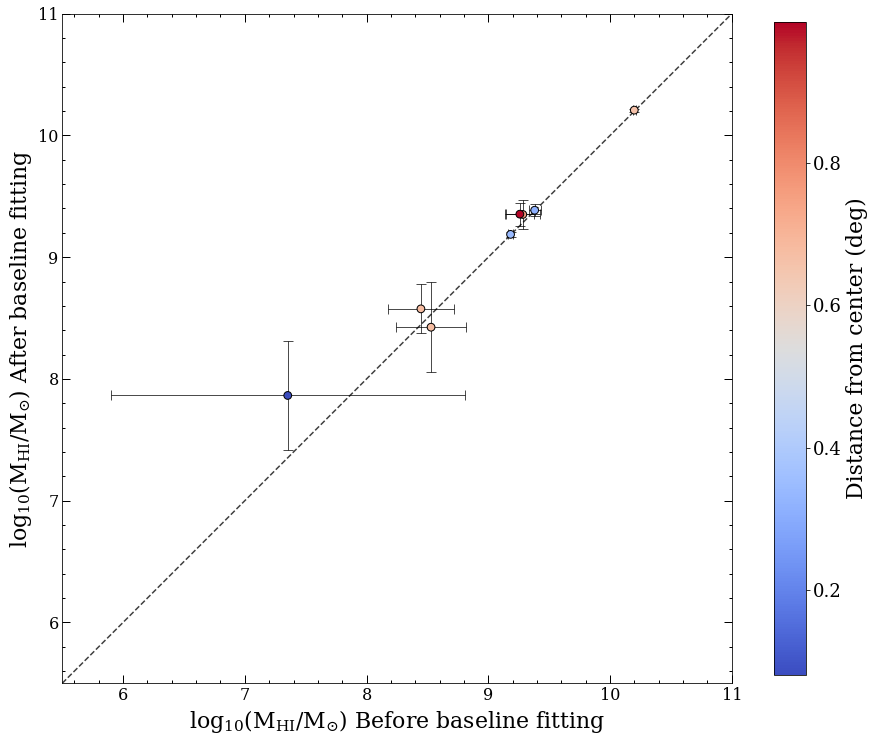

In [188]:
fig = plt.figure(figsize=(15, 15))
ax = pl.gca()
ax.set_xlabel('$\mathrm{log_{10}(M_{HI}/M_{\odot}})$ Before baseline fitting',fontsize=22)
ax.set_ylabel('$\mathrm{log_{10}(M_{HI}/M_{\odot}})$ After baseline fitting',fontsize=22)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in')
ax.tick_params(which='minor', length=3, width=1, direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.ylim([5.5,11])
plt.xlim([5.5,11])

cmap = cm.coolwarm
colorlist = [i for i in distance_from_center]

scatter = plt.scatter(logM_nf, logM, s=60, c=colorlist,edgecolor='k',cmap=cmap)
pl.errorbar(logM_nf, logM, yerr = log10_err2, xerr = log10_err_nf2,lw=1, capsize=5, color='k',alpha=0.7,fmt='none', solid_capstyle='projecting',markerfacecolor='white',zorder=0)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

cbar = pl.colorbar(scatter, shrink=0.8, pad=0.05)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Distance from center (deg)', fontsize=22)
#pl.savefig('/users/aycha/MIGHTEE/Analysis/1380/plots/bf_af_baseline_fit.png')

## Noise Distribution

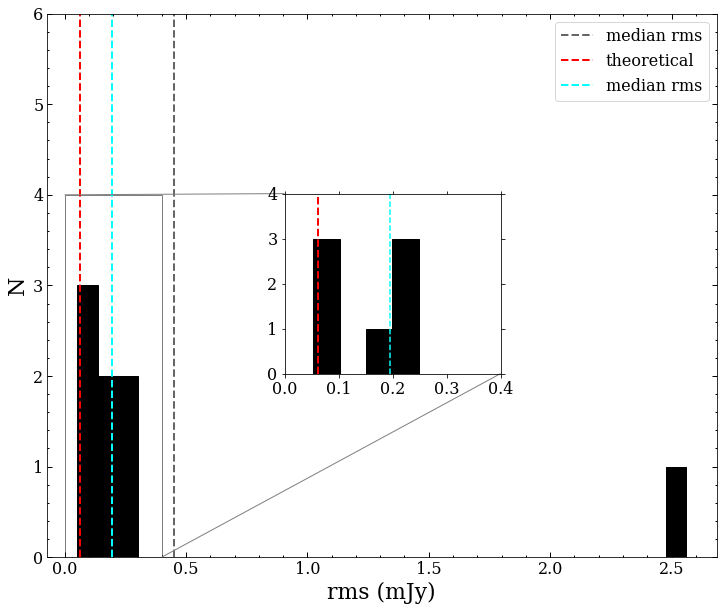

In [84]:
fig = plt.figure(figsize=(12, 10))
plt.hist(mean_rms_mJy,histtype='step',bins=30, fill='black',color='black')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.minorticks_on()
plt.tick_params(which='major', length=5, width=1, direction='in')
plt.tick_params(which='minor', length=2, width=1, direction='in')
pl.axvline(x=mean_mf, color='0.40', zorder=1,linestyle='dashed',label='median rms',linewidth=2)
pl.axvline(x=0.06251, color='red', zorder=1,linestyle='dashed',label='theoretical',linewidth=2)
pl.axvline(x=median_mf, color='cyan', zorder=1,linestyle='dashed',label='median rms',linewidth=2)
pl.legend(fontsize=16)

ax = pl.gca()
ax.set_xlabel('rms (mJy)',fontsize=22)
ax.set_ylabel('N',fontsize=22)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_ylim(0,6)

# location for the zoomed portion 
sub_axes = plt.axes([.4, .380, .25, .25]) 
sub_axes.hist(mean_rms_mJy[:-1],histtype='step', bins='auto', fill='black',color='black')
sub_axes.axvline(x=mean_mf, color='0.40', zorder=1,linestyle='dashed',label='mean rms')
sub_axes.axvline(x=median_mf, color='cyan', zorder=1,linestyle='dashed',label='median rms')
sub_axes.axvline(x=0.06251, color='red', zorder=1,linestyle='dashed',label='theoretical',linewidth=2)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
x1, x2, y1, y2 = 0, .4, 0, 4 # specify the limits
sub_axes.set_xlim(x1, x2) # apply the x-limits
sub_axes.set_ylim(y1, y2) # apply the y-limits
mark_inset(ax, sub_axes, loc1=2, loc2=4, fc="none", ec="0.5")

#sub_axes.set_xlabel('rms (mJy)',fontsize=22)
#sub_axes.set_ylabel('N',fontsize=22)
sub_axes.yaxis.set_ticks_position('both')
sub_axes.xaxis.set_ticks_position('both')
#plt.savefig('fits_detections/rms_hist.png')

## Distribution in the cube

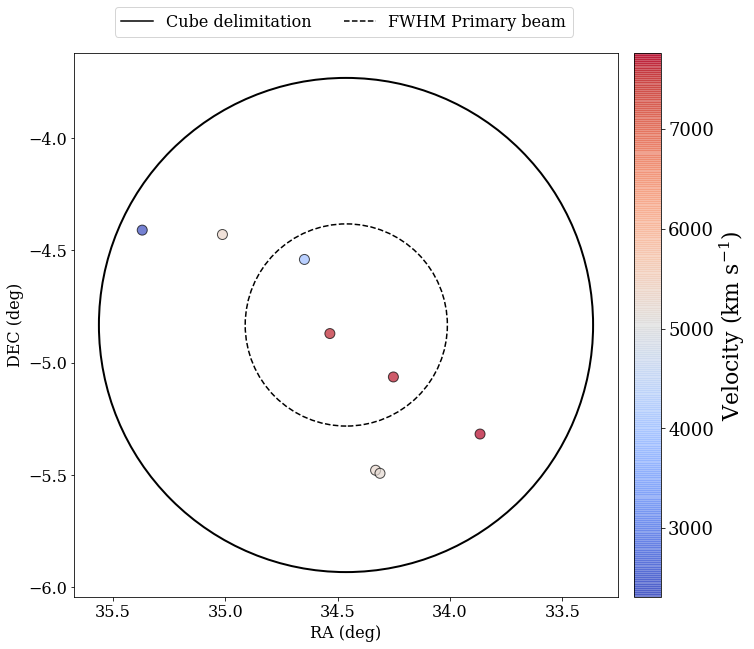

In [85]:
from matplotlib.patches import Circle

fig, ax = pl.subplots(figsize=(12, 10))

#colors for the colorbars
cmap = cm.coolwarm
colorlist = [i for i in central_vel]


SC = ax.scatter(ra_deg, dec_deg, marker = 'o',edgecolor='k',c=colorlist, cmap=cmap, s=100, lw=1,label='detection '+str(i+1),alpha=0.7)
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.plot(central_ra, central_dec,'*k',markersize=20,label='cube center')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlim(ax.get_xlim()[::-1]) #reversing the RA

c_1 = Circle((central_ra, central_dec), 1.1, fc='none', lw=2, ec='k')
c_2 = Circle((34.4612537723, -4.832992), 0.9/2, fc='none', lw=1.5, ec='k', ls = '--')
ax.add_patch(c_1)
ax.add_patch(c_2)

#legends
import matplotlib.lines as mlines
FWHM_pb = mlines.Line2D([], [], color='black', marker='None', linestyle='--',linewidth=1.5,
                          markersize=10, label='FWHM Primary beam')
cubesize = mlines.Line2D([], [], color='black', marker='None', linestyle='solid',linewidth=1.5,
                          markersize=10, label='Cube delimitation')


l1 = plt.legend(handles=[cubesize,FWHM_pb],bbox_to_anchor=(0.06,1.1), loc="upper left",ncol=2,fontsize=16)

cbar = plt.colorbar(SC, shrink=1, pad=0.01)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Velocity (km $\mathrm{s^{-1}}$)', fontsize=22)

plt.axis('scaled') 
plt.show()

## Theoretical calculations

### Theoretical noise with MeerKAT:

https://www.atnf.csiro.au/people/Keith.Bannister/senscalc/ (giving similar results)

From the listobs file and observations details seen [here](https://docs.google.com/spreadsheets/d/1vSoKUNcS6s8aykKYEE2eVabhaOjymM3QeMuECZj2lB0/edit#gid=0]), we can read the details abut the observations:
* Antenna N on target = 59 and 63,
* Integration time on target only = 45864 seconds or 12.74 hours (from listobs)
* Integration time on target only = 6.2 hours + 6.23 hours = 12.43 hours (from the google doc)

In [86]:
k_B = const.k_B.to(u.Jy*(u.m)**2*(u.K)**-1)
def noise(integration_time,bandwidth=0.209,N=1,Tsys=22.0,k = k_B.value,D=13.5,neta=1,retfreq=1.4):
    '''Antenna number N'''
    '''Integration time in seconds'''
    '''bandwidth in MHz'''
    '''T_sys/neta = 22.0 K in MeerKAT, if we suppose neta = 1 then T_sys = 22 K'''
    '''k_B = 1380.6485 Jy m^2 K^-1'''
    '''rest frequency for HI 1.4 Ghz'''
    A = math.pi*(D/2)**2
    S = (math.sqrt(2)*k*Tsys) / (neta*A*math.sqrt(N*(N-1)*integration_time*bandwidth))
    S = S*u.mJy
    print(S)
    return S

def M_HI_1_z_square(distance,int_flux): #M_HI global
    Ho = 67.4
    c=299792.458
    z = (distance*Ho)/c
    m = 2.356e5*((distance/(1+z))**2)*int_flux
    return m

def M_HI(distance,flux): #M_HI global, redshift independant
    m = 2.356e5*(distance**2)*flux
    return m

def N_HI(flux, bmaj, bmin, dv = 44.751305):
    '''for z = 0'''
    n = 1.10e24*flux*dv/(bmaj*bmin)
    return n

def N_HI_Hz(flux, bmaj, bmin, dv_hz = 208.984e3):
    '''for z = 0'''
    n = 2.33e20*flux*dv_hz/(bmaj*bmin)
    return n

### Velocity and frequency coverage

$$ \frac{\Delta f}{f} = \frac{\Delta V}{c}$$

For a spectral resolution of 209 KHz, we expect a channel width at 1.4 GHz at:

In [87]:
df = 208.984*1e3 #Hz
f = 1.4*1e9 #21 cm
dv = const.c.to(u.km/u.s)*df/f
dv #mean channel width

<Quantity 44.75130503 km / s>

The common beam we have is PSF = $11.5'' \times 9.5''$, so we can calculate the HI column density for a 3$\sigma$ line and the HI mass and sensitivity for a 5$\sigma$ linewidth pof 300 km/s at a distance of 100 Mpc

In [90]:
theoret_noise = noise(12.43*3600, N=59)
theoret_mass_z = M_HI_1_z_square(100, (theoret_noise.to(u.Jy).value*5*300))
theoret_mass = M_HI(100, (theoret_noise.to(u.Jy).value*5*300))
theoret_column_Hz = N_HI_Hz(theoret_noise.to(u.Jy).value*3, 20, 20) #circular
theoret_column = N_HI_Hz(theoret_noise.to(u.Jy).value*3, 11.5, 9.5) #common
print(theoret_mass, theoret_mass_z,theoret_column_Hz, theoret_column) 

0.05304731802071895 mJy
187469221.8852208 179315754.2207821 1.9372856139400274e+19 7.093036572778132e+19


Expected HI column density for a 1$\sigma$ line for the circular and common beams

In [91]:
theoret_column_Hz = N_HI_Hz(theoret_noise.to(u.Jy).value, 20, 20) #circular
theoret_column = N_HI_Hz(theoret_noise.to(u.Jy).value, 11.5, 9.5) #common
print(theoret_column_Hz,theoret_column)

6.457618713133425e+18 2.364345524259377e+19


## Sensitivity curve

Assuming a 5 sigma detection with 300 km/s linewidth

In [88]:
def sensitivity_curve(distance,noise,sigma=5,width=300):
    '''
    noise in Jy
    width in km/s
    '''
    S = sigma*np.array([noise]*len(distance))
    Int_flux = [x * width for x in S]
    mass = M_HI_1_z_square(distance, Int_flux)
    log_mass = np.log10(mass[:])
    return log_mass

In [92]:
#HIPASS
distance = np.linspace(0,300,100) #Mpc
log_mass_HIPASS = sensitivity_curve(distance,0.013,sigma=5,width=300)

#MEERKAT, THEORETICAL
log_mass_MEERKAT = sensitivity_curve(distance,theoret_noise.to(u.Jy).value,sigma=5,width=300)
log_mass_MEERKAT_40 = sensitivity_curve(distance,theoret_noise.to(u.Jy).value+(theoret_noise.to(u.Jy).value*40/100),sigma=5,width=300)


max_mf = np.max(mean_rms)
min_mf = np.min(mean_rms)
mean_mf = np.mean(mean_rms)
median_mf = np.median(mean_rms)

#OBSERVATIONS
log_mass_min = sensitivity_curve(distance,min_mf,sigma=5,width=300)
log_mass_max = sensitivity_curve(distance,max_mf,sigma=5,width=300)
log_mass_mean = sensitivity_curve(distance,mean_mf,sigma=5,width=300)
#log_mass_median = sensitivity_curve(distance,median_mf,sigma=5,width=300)

In [93]:
v = np.linspace(0,19000,100)

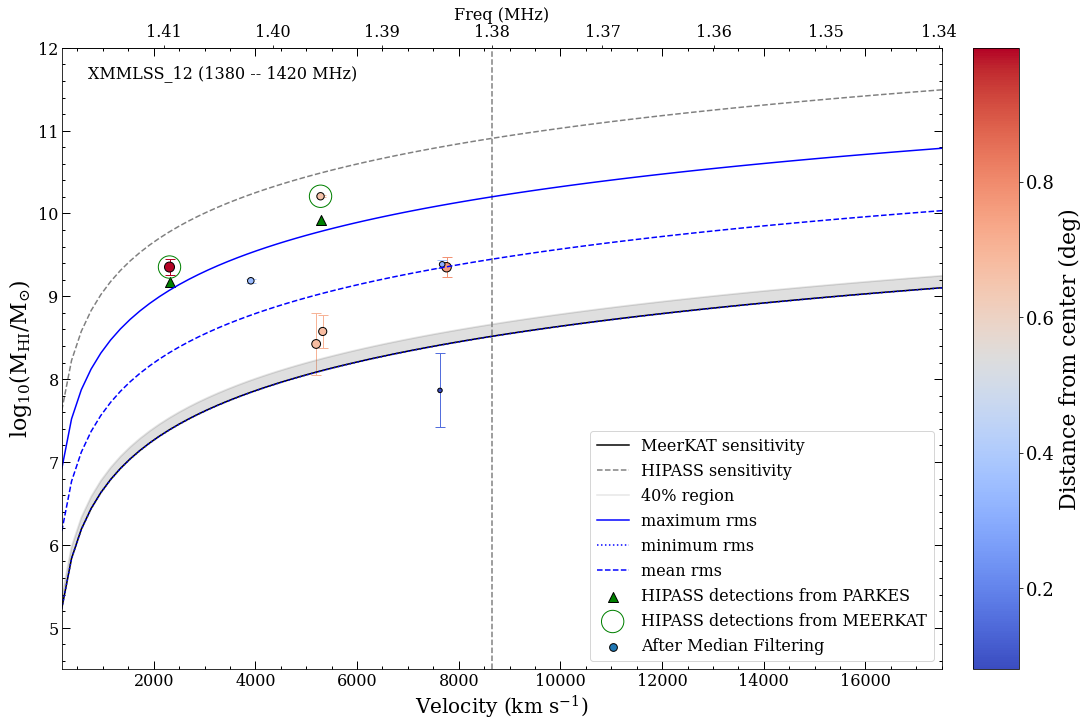

In [94]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(15, 10))
plt.plot(v,log_mass_MEERKAT,'k',label='MeerKAT sensitivity')
plt.plot(v,log_mass_HIPASS,'--',color='grey',label='HIPASS sensitivity')
plt.plot(v,log_mass_MEERKAT_40,'grey',alpha=0.2,label='40% region')

plt.plot(v,log_mass_max,'b',label='maximum rms')
plt.plot(v,log_mass_min,'b',label='minimum rms',linestyle='dotted')
plt.plot(v,log_mass_mean,'b--',label='mean rms')
#plt.plot(v,log_mass_median,'b*-',label='median rms')

cmap = cm.coolwarm
colorlist = [i for i in distance_from_center]

#size depending on the rms noise
index_rms = np.argsort(mean_rms) #index of sorting the rms
size = np.linspace(20,100,len(mean_rms))

def reorder(arr,index, n): 
  
    temp = [0] * n; 
  
    # arr[i] should be 
        # present at index[i] index 
    for i in range(0,n): 
        temp[index[i]] = arr[i] 
  
    # Copy temp[] to arr[] 
    for i in range(0,n): 
        arr[i] = temp[i] 
        index[i] = i
    return arr

s = reorder(size,index_rms,len(index_rms))
s = [n for n in s]

#HIPASS
plt.scatter(central_vel[4],np.log10(M_HI_1_z_square(hubble_D[4],5.7)), s=100, facecolors='g', edgecolors='k',label='HIPASS detections from PARKES',marker='^')
plt.scatter(central_vel[7],np.log10(M_HI_1_z_square(hubble_D[7],5.3)), s=100, facecolors='g', edgecolors='k',marker='^')

plt.scatter(central_vel[4],logM[4], s=500, facecolors='none', edgecolors='g',label='HIPASS detections from MEERKAT')
plt.scatter(central_vel[7],logM[7], s=500, facecolors='none', edgecolors='g')

#DETECTIONS
scatter = plt.scatter(central_vel,logM,marker='o',edgecolors='k',label='After Median Filtering',c=colorlist,cmap=cmap,s=s,zorder=1)
#plt.plot(central_vel,logM_w128_unmasked_common2,'sr',alpha=0.3,label='Before Median Filtering')


#ERRORS
#pl.errorbar(central_vel, logM_mf_unmasked_common2, fmt='none', label="log HI mass error",solid_capstyle='projecting',
             #yerr=log_err_mf_unmasked_common, c=color,cmap=cmap,capsize=5,alpha=0.3)

cbar = pl.colorbar(scatter, shrink=1, pad=0.01)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Distance from center (deg)', fontsize=22)

#Color for errorbars:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
m = cm.ScalarMappable(norm=norm, cmap=cmap)
map_to_color = np.vectorize(m.to_rgba)

color = []
for i in range(len(detections)):
    color.append(map_to_color(colorlist[i]))

#loop over each data point to plot
for x, y, e, c in zip(central_vel, logM, log10_err2, color):
    pl.errorbar(x, y, yerr = e, lw=1, capsize=5, color=c,alpha=1,fmt='none', solid_capstyle='projecting',markerfacecolor='white',zorder=0)


plt.text(6000, 11.8, 'XMMLSS_12 (1380 -- 1420 MHz)', size=16, rotation=0., family='serif', color = 'black',
         ha="right", va="top")

pl.axvline(x=freq_to_vel(1.380), color='grey', zorder=1,linestyle='--')
#delimiting the 1380 MHz

plt.legend(fontsize=16,loc = 'lower right')
plt.ylim([4.5,12])
plt.xlim([200,17500])


secax = ax.secondary_xaxis('top', functions=(vel_to_freq, freq_to_vel))
secax.set_xlabel('Freq (MHz)')

#ax.fill_between(v, log_mass - (log_mass40-log_mass), log_mass + (log_mass40-log_mass), alpha=0.2,color='grey')
plt.fill_between(v,log_mass_MEERKAT,log_mass_MEERKAT_40,color='grey',alpha=0.25,label='40%')
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in')
ax.tick_params(which='minor', length=3, width=1, direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xlabel('Velocity (km $\mathrm{s^{-1}}$)',fontsize=20)
ax.set_ylabel('$\mathrm{log_{10}(M_{HI}/M_{\odot}})$',fontsize=22)
for tick in ax.xaxis.get_majorticklabels():  # example for xaxis
    tick.set_fontsize(16)
for tick in ax.yaxis.get_majorticklabels():  # example for xaxis
    tick.set_fontsize(16)
#plt.savefig('/users/aycha/MIGHTEE/Analysis/1380/plots/completeness_limit_direct_1380.png')



### Comparison with HIPASS spectra

The HIPASS fits files were downloaded from the HIPASS catalogue

In [95]:
hipass_1 = SpectralCube.read('/users/aycha/MIGHTEE/notebooks/HIPASS_data/HIPASS_021717.8-0527_freq.fits') #spectrum
hipass_2 = SpectralCube.read('/users/aycha/MIGHTEE/notebooks/HIPASS_data/HIPASS_022121.2-0423_freq.fits')
hipass_1 #in optical velocity

SpectralCube with shape=(1022, 1, 1) and unit=Jy / beam:
 n_x:      1  type_x: RA---SIN  unit_x: deg    range:    34.324167 deg:   34.324167 deg
 n_y:      1  type_y: DEC--SIN  unit_y: deg    range:    -5.455833 deg:   -5.455833 deg
 n_s:   1022  type_s: VOPT-F2W  unit_s: m / s  range: -1267682.723 m / s:12712401.618 m / s

In [96]:
#Converting into relativstic velocity
#optical velocity into frequency
hipass_1 = hipass_1.with_spectral_unit(u.Hz, velocity_convention='optical', rest_value=1.42040575e9 * u.Hz)
hipass_2 = hipass_2.with_spectral_unit(u.Hz, velocity_convention='optical', rest_value=1.42040575e9 * u.Hz)

#frequency into relativistic velocity
hipass_1 = hipass_1.with_spectral_unit(u.km / u.s, velocity_convention='relativistic', rest_value=1.42040575e9 * u.Hz)
hipass_2 = hipass_2.with_spectral_unit(u.km / u.s, velocity_convention='relativistic', rest_value=1.42040575e9 * u.Hz)

In [97]:
#Getting the velocity axis
vel_hipass1 = hipass_1.spectral_axis.value
vel_hipass2 = hipass_2.spectral_axis.value

#Getting the velocity axis from MIGHTEE range
idx = (vel_hipass1>vel[4][-1].value)*(vel_hipass1<vel[4][0].value)
idx2 = (vel_hipass2>vel[7][-1].value)*(vel_hipass2<vel[7][0].value)

vel_h1 = vel_hipass1[np.where(idx)]
vel_h2 = vel_hipass2[np.where(idx2)]

In [98]:
#Getting the fluxes
hipass_1_sum = hipass_1.sum(axis=(1,2))/hipass_1.unit #Sum of the flux in Jy already scaled
hipass_2_sum = hipass_2.sum(axis=(1,2))/hipass_2.unit

hipass_1_sum = hipass_1_sum[np.where(idx)] #taking the only part needed for the spectra
hipass_2_sum = hipass_2_sum[np.where(idx2)]

In [99]:
flux_hipass = [hipass_1_sum,hipass_2_sum]
vel_hipass = [vel_h1,vel_h2]
text = [[4250,0.07],[1350,0.08]]
name = ['HIPASS J0217-05','HIPASS J0221-04']

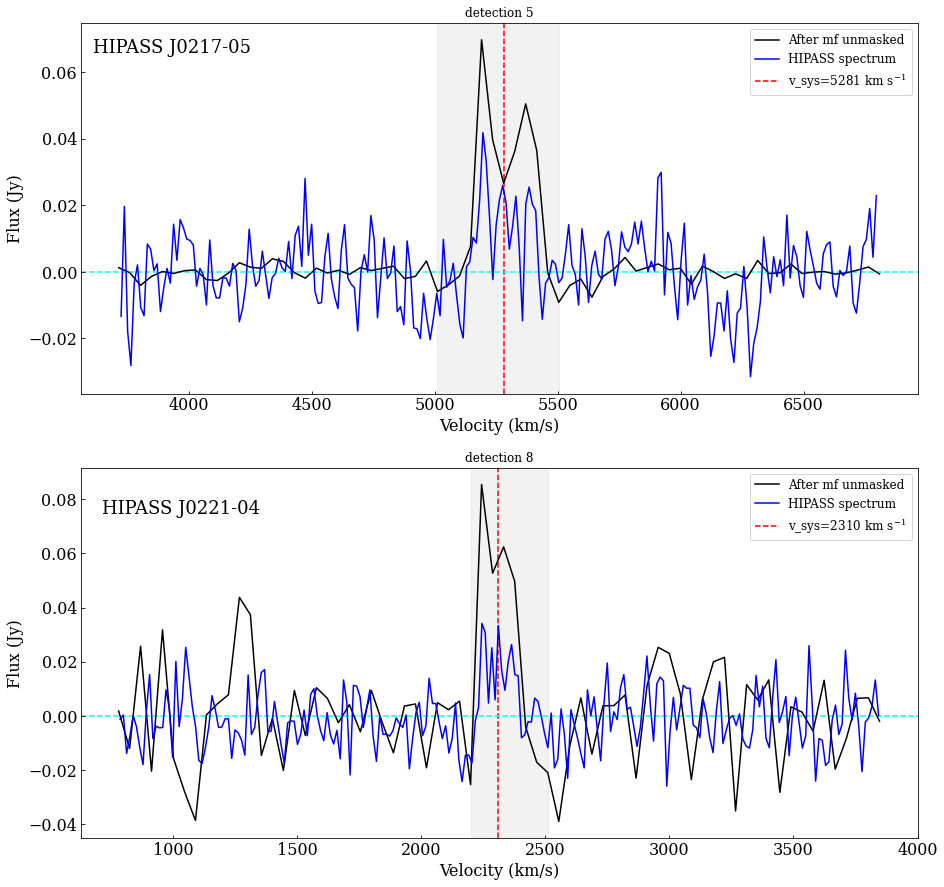

In [100]:
pl.figure(figsize=(15,15))
for i in range(2):
    j = [4,7]
    pl.subplot(2,1,i+1)
    pl.plot(vel[j[i]].value, flux_fit[j[i]],'k',label='After mf unmasked',linewidth=1.5) 
    pl.plot(vel_hipass[i], flux_hipass[i],'blue',label='HIPASS spectrum',linewidth=1.5) 
    pl.axvline(x=central_vel[j[i]], color='r', zorder=1,linestyle='--',label='v_sys='+str(int(central_vel[j[i]]))+' km $\mathrm{s^{-1}}$')
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    ax = pl.gca()
    ax.axvspan(vel[j[i]][index_a[j[i]]].value, vel[j[i]][index_b[j[i]]].value, alpha=0.1, color='grey')
    pl.tick_params(which='major', direction='in')
    pl.title('detection '+str(j[i]+1))
    pl.xlabel('Velocity (km/s)')
    pl.ylabel('Flux (Jy)')
    #pl.tight_layout()
    pl.legend(fontsize=12,loc="upper right")
    plt.text(text[i][0], text[i][1], name[i], size=18, rotation=0., family='serif', color = 'black',
         ha="right", va="top")
pl.subplots_adjust(hspace=0.2,wspace=0.2)
#plt.savefig('/users/aycha/MIGHTEE/Analysis/1380/plots/HIPASS_spectra_meerkat.png')